In [5]:
import ssdeep
import pickle,os,sys,gc
import pandas as pd
# pd.set_option('display.max_columns', None)
import numpy as np
from tqdm import tqdm
from collections import Counter
import multiprocessing as mp
from multiprocessing import Process, Manager, Pool
import time,datetime
from itertools import chain
import math
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
import functools
import itertools
import operator
from itertools import chain
sys.setrecursionlimit(1000000)

In [ ]:
#  import sys,os
print(sys.executable)
print(sys.version)
print(sys.version_info)
import findspark
# os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3' #'/home/antslab/anaconda3/bin/python'
findspark.init()
import pyspark
# from pyspark import SparkContext
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row, SQLContext, SparkSession, window
from pyspark import SparkConf, SparkContext
# Import data types
from pyspark.sql.types import *
import  pyspark.sql.functions as F
conf = SparkConf()
# conf.set("spark.local.dir", "/mnt/ssd240g/data/Leo_Spark_Home/tmp")
conf.set("spark.executor.cores","12")
conf.setMaster("local[12]")
conf.set("spark.driver.memory","85g")
conf.set("spark.executor.memory", "95g")
conf.set("spark.memory.offHeap.enabled","true")
conf.set("spark.memory.offHeap.size","85g")
conf.set("spark.driver.extraJavaOptions","-Xss80g")
conf.set("spark.driver.extraJavaOptions","-Xms80g")
# conf.set("spark.memory.storageFraction","0.2")
# conf.set("spark.driver.maxResultSize","0")
# conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
# conf.set("spark.sql.execution.arrow.enabled", "true")
conf.set("spark.kubernetes.pyspark.pythonVersion","3")
conf.set("spark.sql.shuffle.partitions",100000)
conf.set("spark.driver.maxResultSize", "150g")

# spark = SparkSession.builder.appName("pcap_analyzer").config(conf=conf).getOrCreate() #pcap_analyzer pcapAnalyzer
spark = SparkSession.builder.master("local").appName("Test_spark").config(conf=conf).getOrCreate()
# spark.conf.set("spark.sql.execution.arrow.enabled", True)
spark.conf.set("spark.sql.debug.maxToStringFields", 290000)
spark.conf.set("spark.sql.hive.filesourcePartitionFileCacheSize",100*1024*1024*1024)

import databricks.koalas as ks
ks.options.display.max_rows = 20
ks.set_option('compute.max_rows', None)
# ks.set_option('compute.ops_on_diff_frames', True)
ks.set_option('compute.default_index_type', 'distributed')
print(ks.__version__)
spark.version

### Function

In [6]:
isp = '台固媒體' #改
time_li = ['20200106','20200107','20200108','20200109','20200110','20200111','20200112']
time = str(min(time_li))
picture_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/case_pictures/'


合併三個dict用update來合併以後再通過後面的df function畫圖

In [7]:

def cluster_rep_hash(proto_big_dict,proto_df_payload,proto_df,proto_loners,knee_point,date='0110',protocol='http'):
    '''
    GOAL: create each cluster's representaion ssdeep hash
    proto_df_payload: from prepare_df() function
    proto_big_dict: from similarity_compare() function
    proto_loners: loner idx list
    knee_point: from get_small_cluster() function
    date & protocol: user_defined cluster name
    
    Return: dict[cluster_name]: ssdeep hash
    '''
    upgma_dict = {}
    for key,value in proto_big_dict.items(): #cluster rep ssdeep
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        if len(value)>knee_point:
            upgma_dict[str(protocol)+'_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
        else:
            upgma_dict[str(protocol)+'_S_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    for key in proto_loners: #loner ssdeep
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        upgma_dict[str(protocol)+'_L_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    return upgma_dict



def pair_wise_score(upgma_dict):
    '''
    GOAL: calculate distance matrix by calculating paire-wise similarity score. 
    and pick upper triangle convert to list
    Input: from cluster_rep_hash() function
    ['cluster']: name
    ['ssdeep']: cluster's representation hash
    
    Return: df=>['c_ssdeep_li']:the hashes list compare to, ['score']:list of distances (upper-triangle, exclude self)
    '''
    def compare(target_hash,candidate_hash_li):
        score_li = []
        for c_hash in candidate_hash_li:
            score_li.append(100-ssdeep.compare(target_hash,c_hash)) #相似度滿分100，轉換成距離最近0
        return score_li
    used_idx = []
    def create_hash_li(t_hash):
        idx_set = set(upgma_df[upgma_df.ssdeep == t_hash].index)#[0]
        same_hash_li = sorted(list(idx_set - set(used_idx)))
        idx = same_hash_li[0]
        used_idx.append(idx)
        return upgma_df.loc[idx+1:]['ssdeep'].tolist()
    upgma_df = pd.DataFrame(upgma_dict.items(),columns=['cluster','ssdeep'])
    upgma_df['c_ssdeep_li'] = upgma_df.ssdeep.map(create_hash_li)
    upgma_df['score'] = upgma_df.apply(lambda x: compare(x.ssdeep, x.c_ssdeep_li), axis=1)
    return upgma_df



def draw_upgma(upgma_df,picture_dir=picture_dir,name='upgma'):
    '''
    GOAL: using upper triangle's distance to draw upgma
    Input: from pair_wise_score() function
    Output: diagram of UPGMA、Z info
    '''
    if not os.path.exists(picture_dir):
        os.makedirs(picture_dir,exist_ok=True) 
    score_li = upgma_df['score'].tolist()
    score_li = list(filter(None, score_li))
    score_li = sum(score_li,[])
    Z = linkage(score_li, 'average')
    fig = plt.figure(figsize=(60, 24)) #(25,10) #(5,2)
    # plt.savefig(fig)
    dn = dendrogram(Z,labels=upgma_df.cluster.tolist())
    plt.savefig(picture_dir+str(name)+'.png', dpi=600, format='png', bbox_inches='tight')
    return dn,Z

100%|██████████| 11/11 [24:42<00:00, 134.78s/it]


{'sip_L_137438959845_20200109_Russia_None_193.188.22.236': '3:OXXXL1Vf1V1V1V1RYP/LfIQfdplr+M5DcEYVV91v/vV1V1VV:OQPxdL+M5Avf9',
 'sip_L_1563368101688_20200110_Saint Lucia_None_205.217.228.103': '3:OXXUD8EU1V1V1V1RYP/LfIQfdplr+Mfjfun:O0DVPxdL+Mfjmn'}

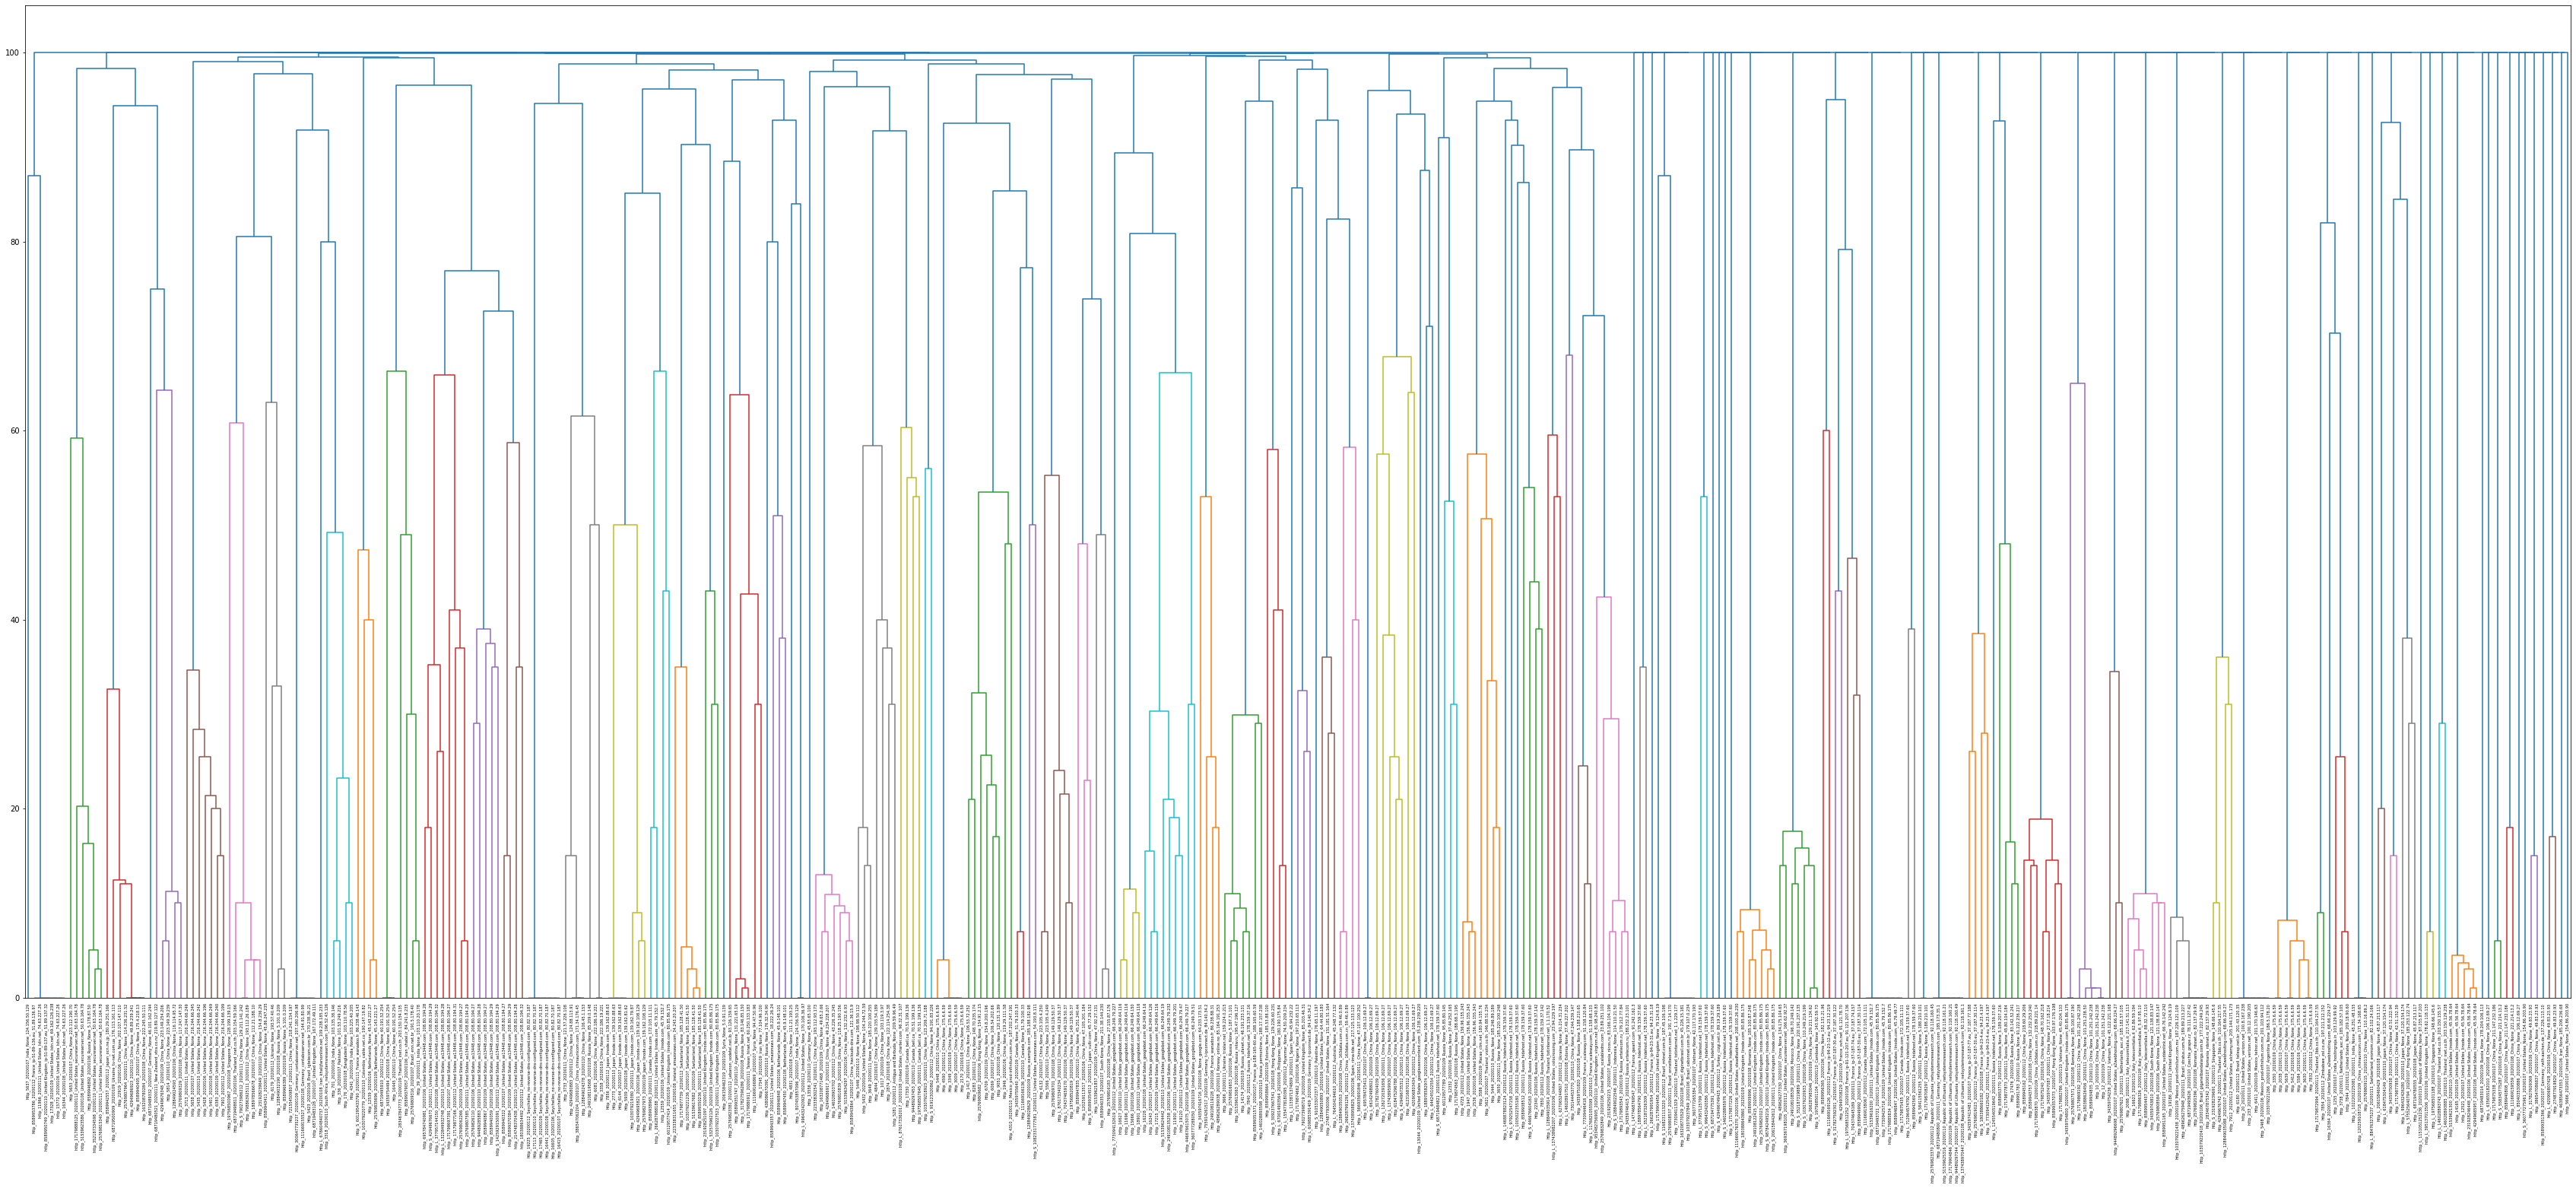

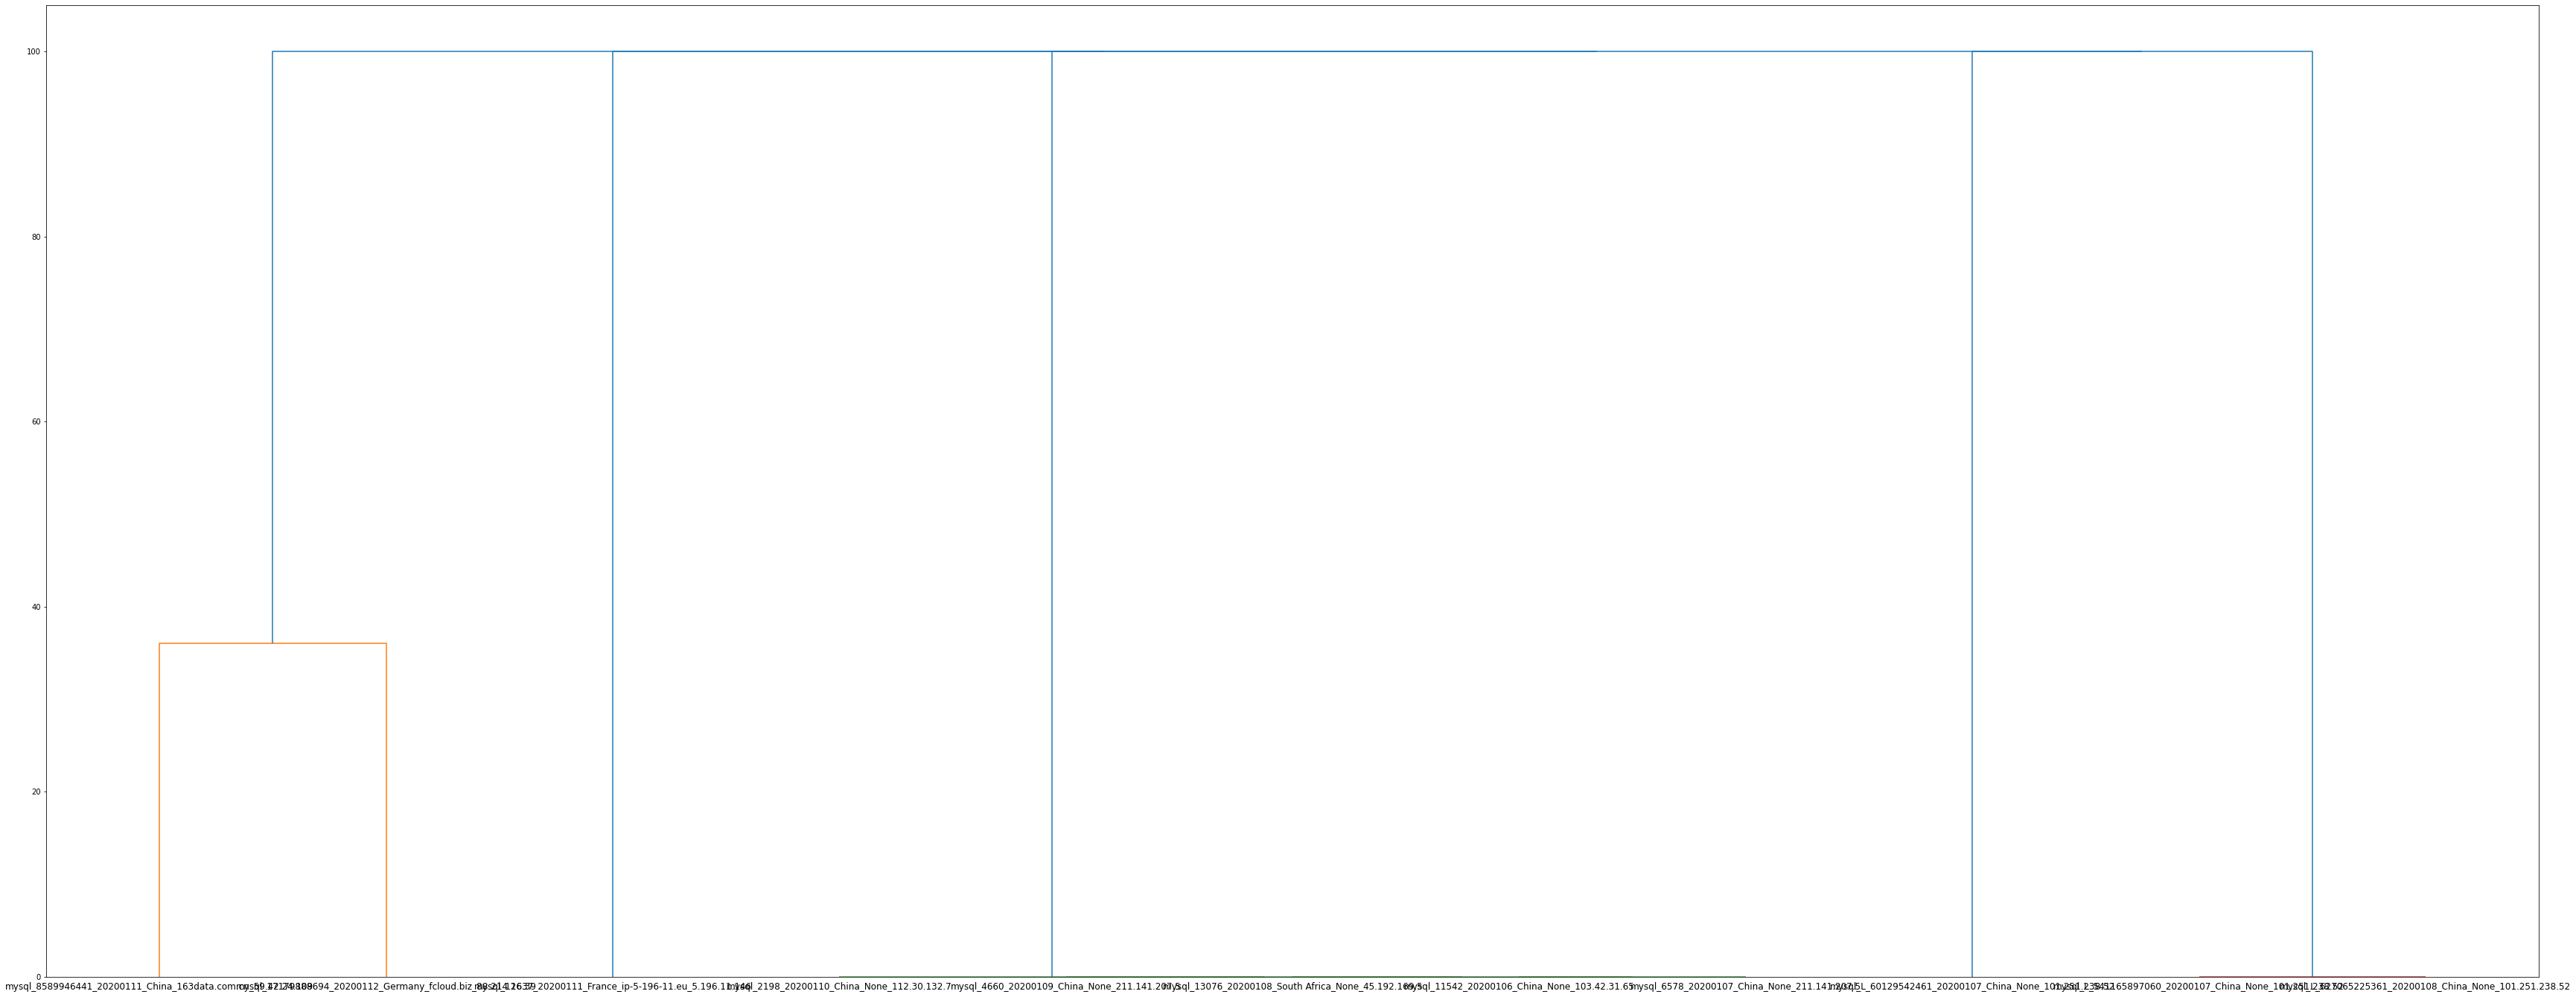

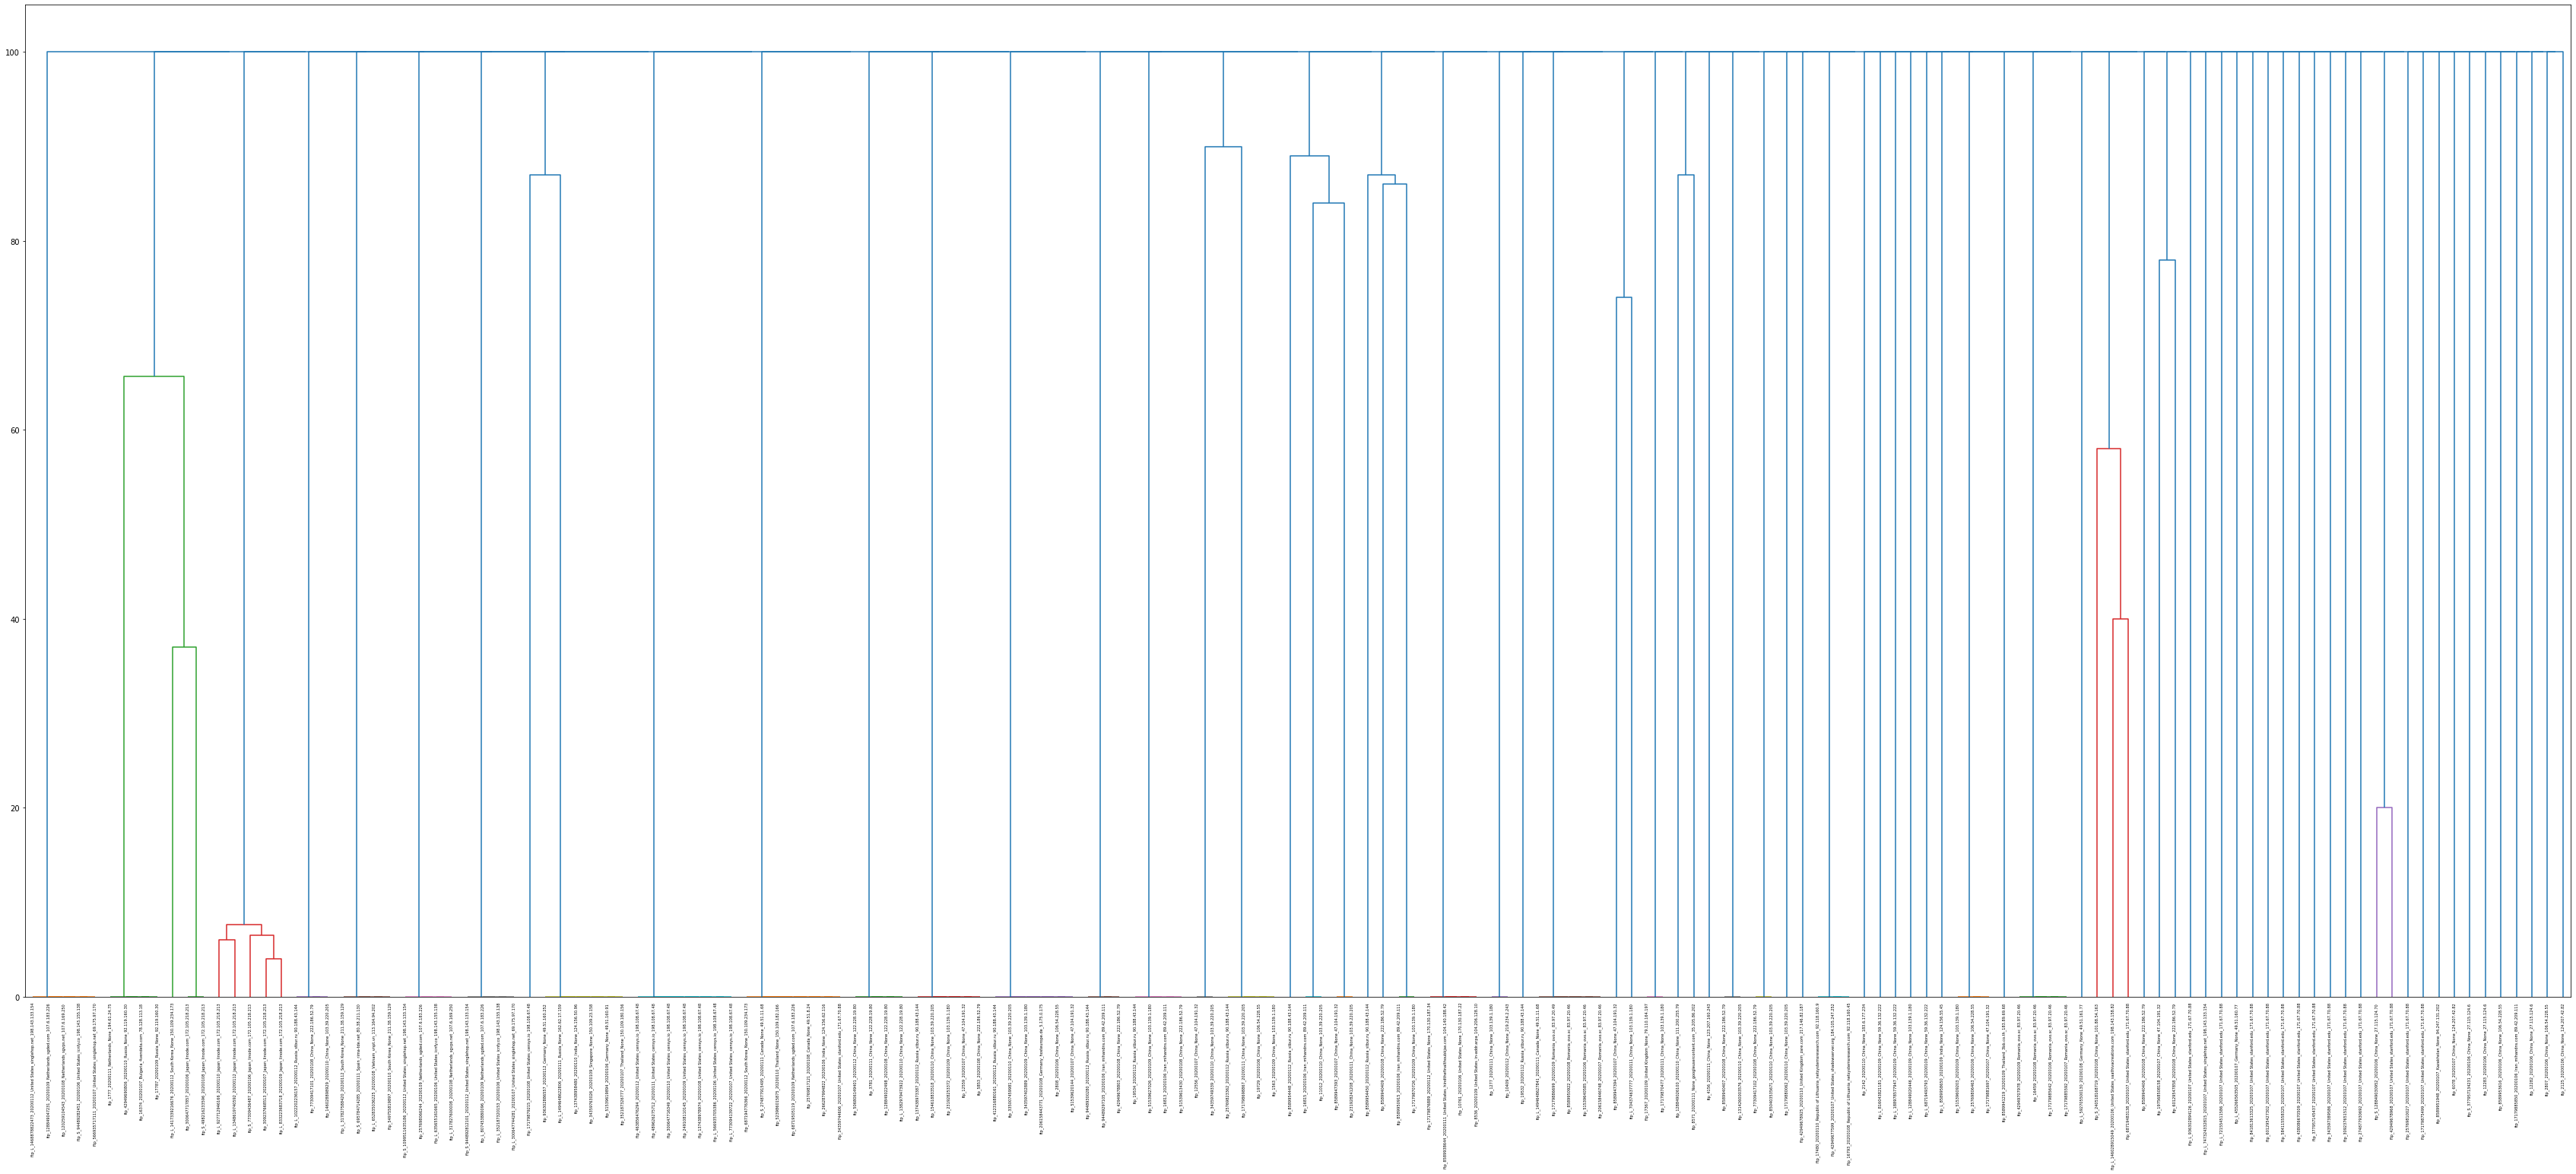

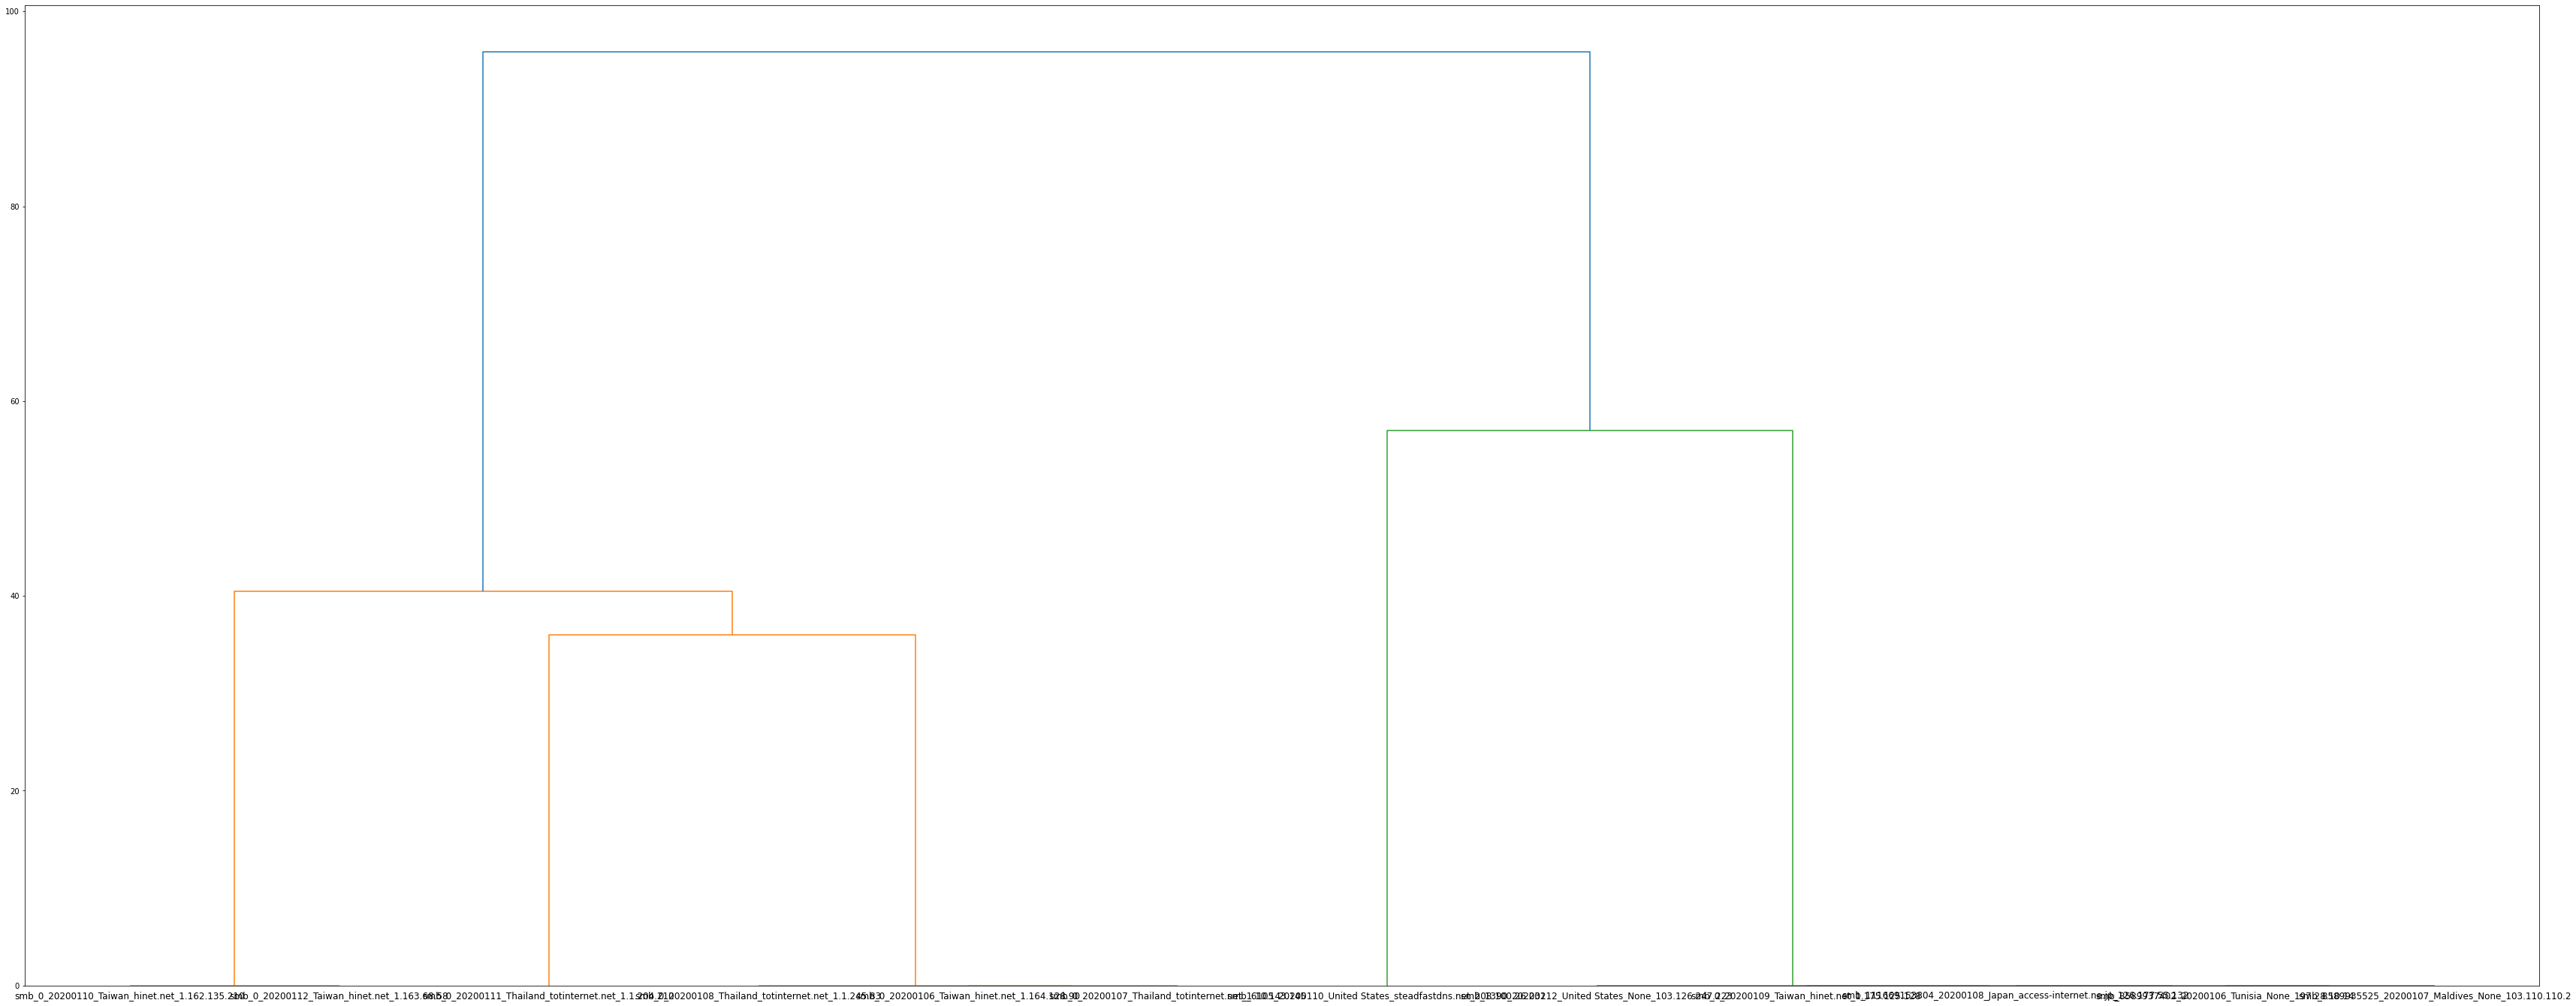

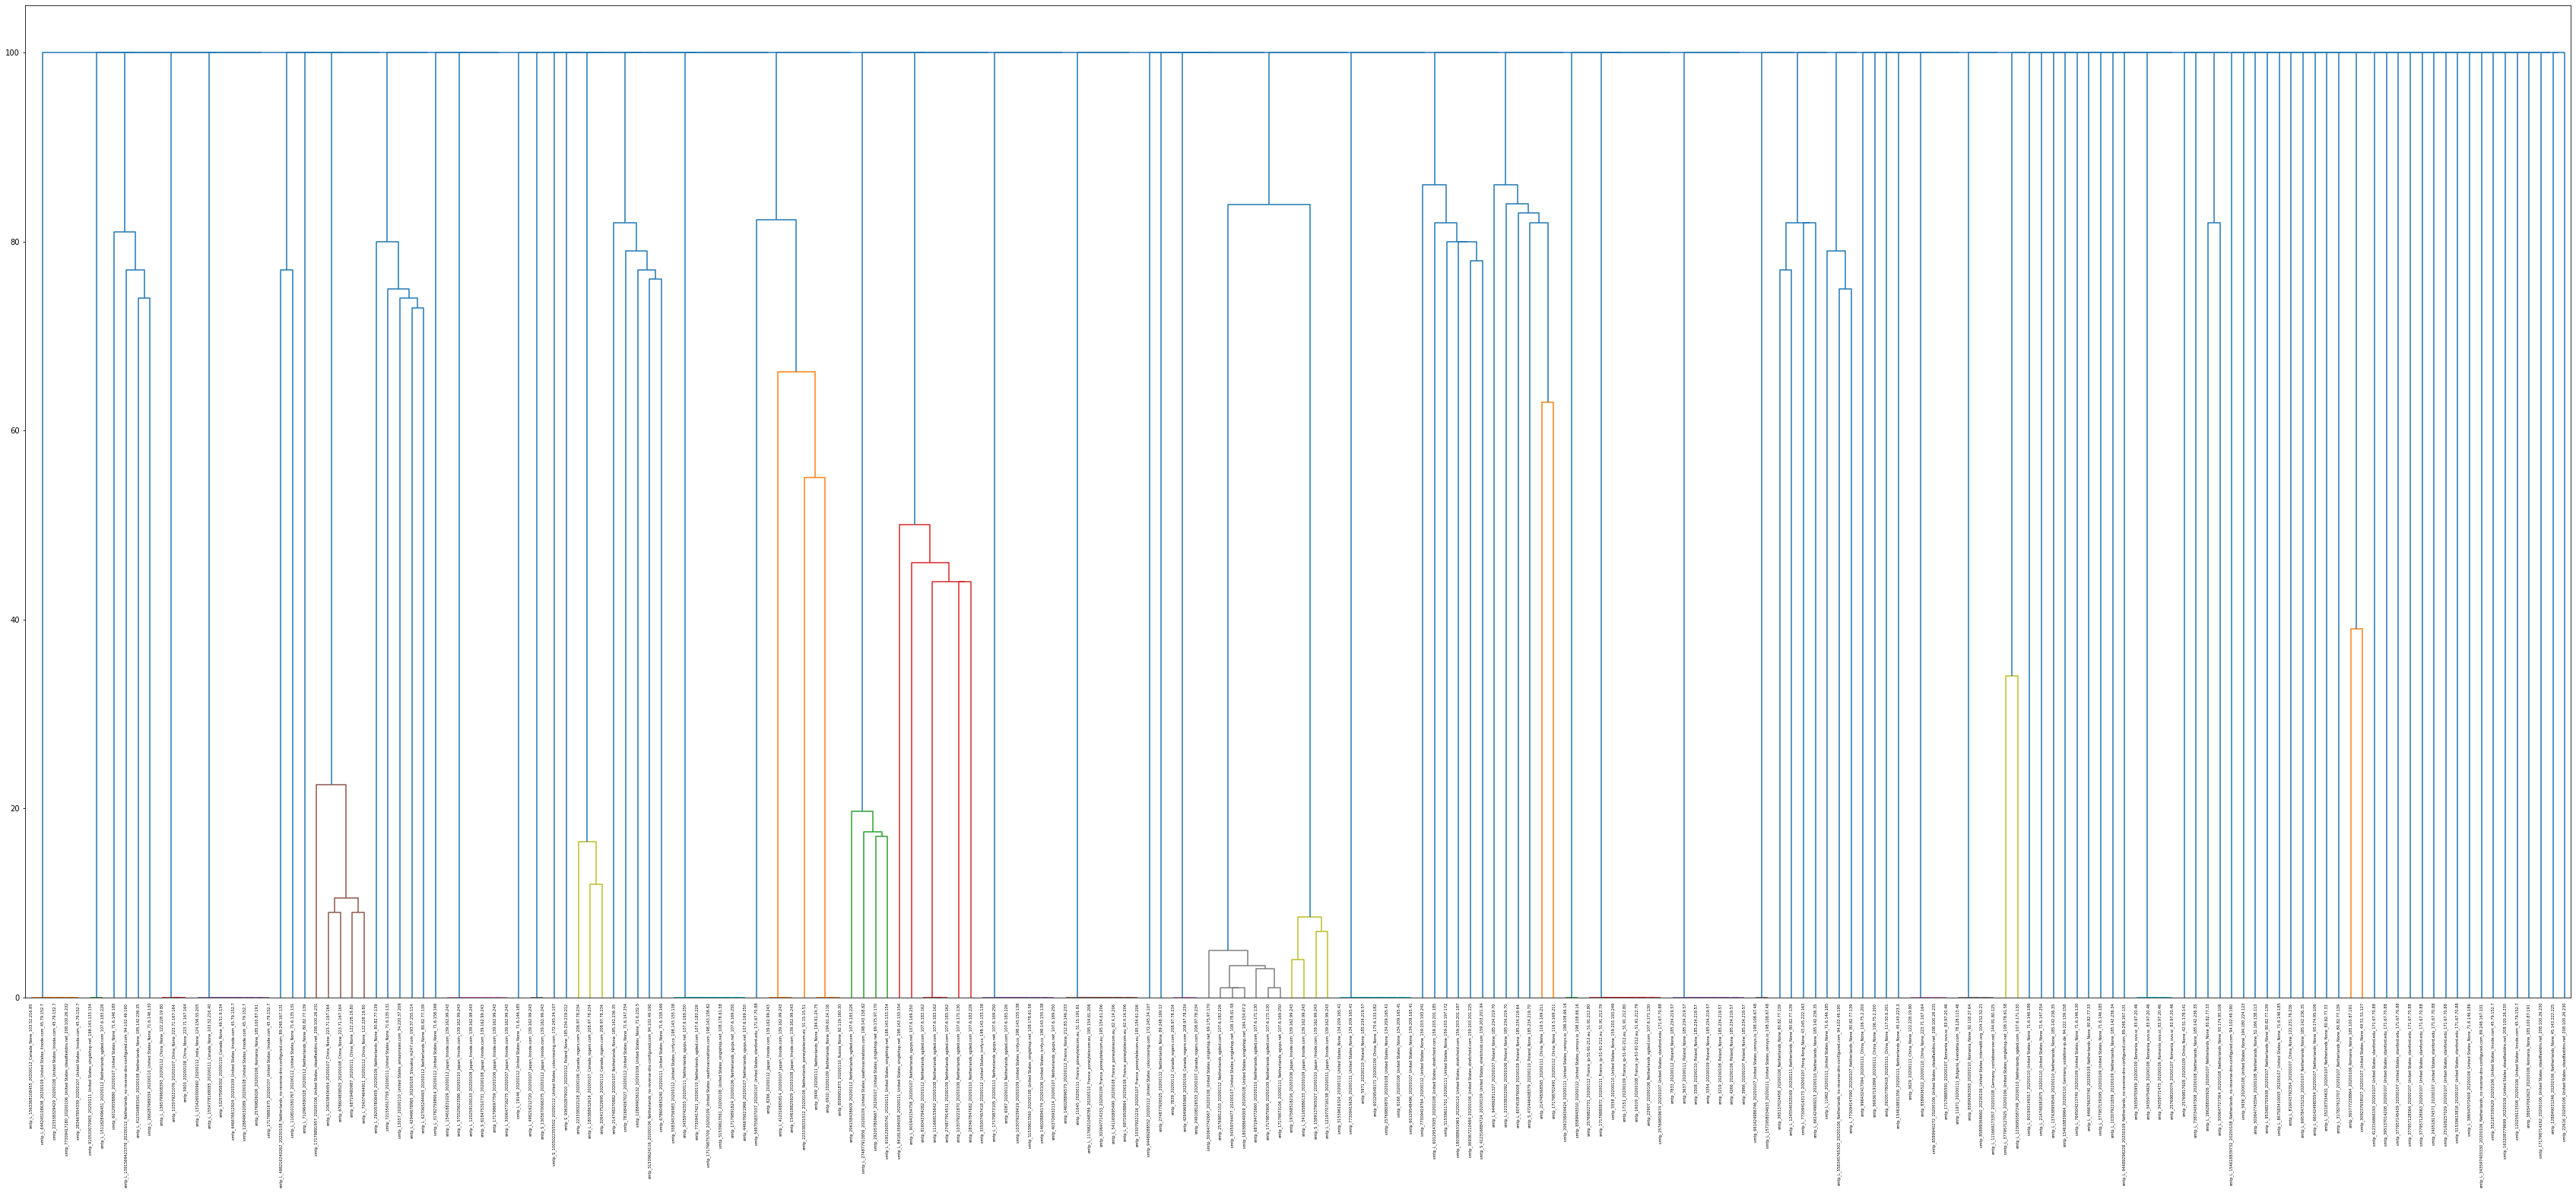

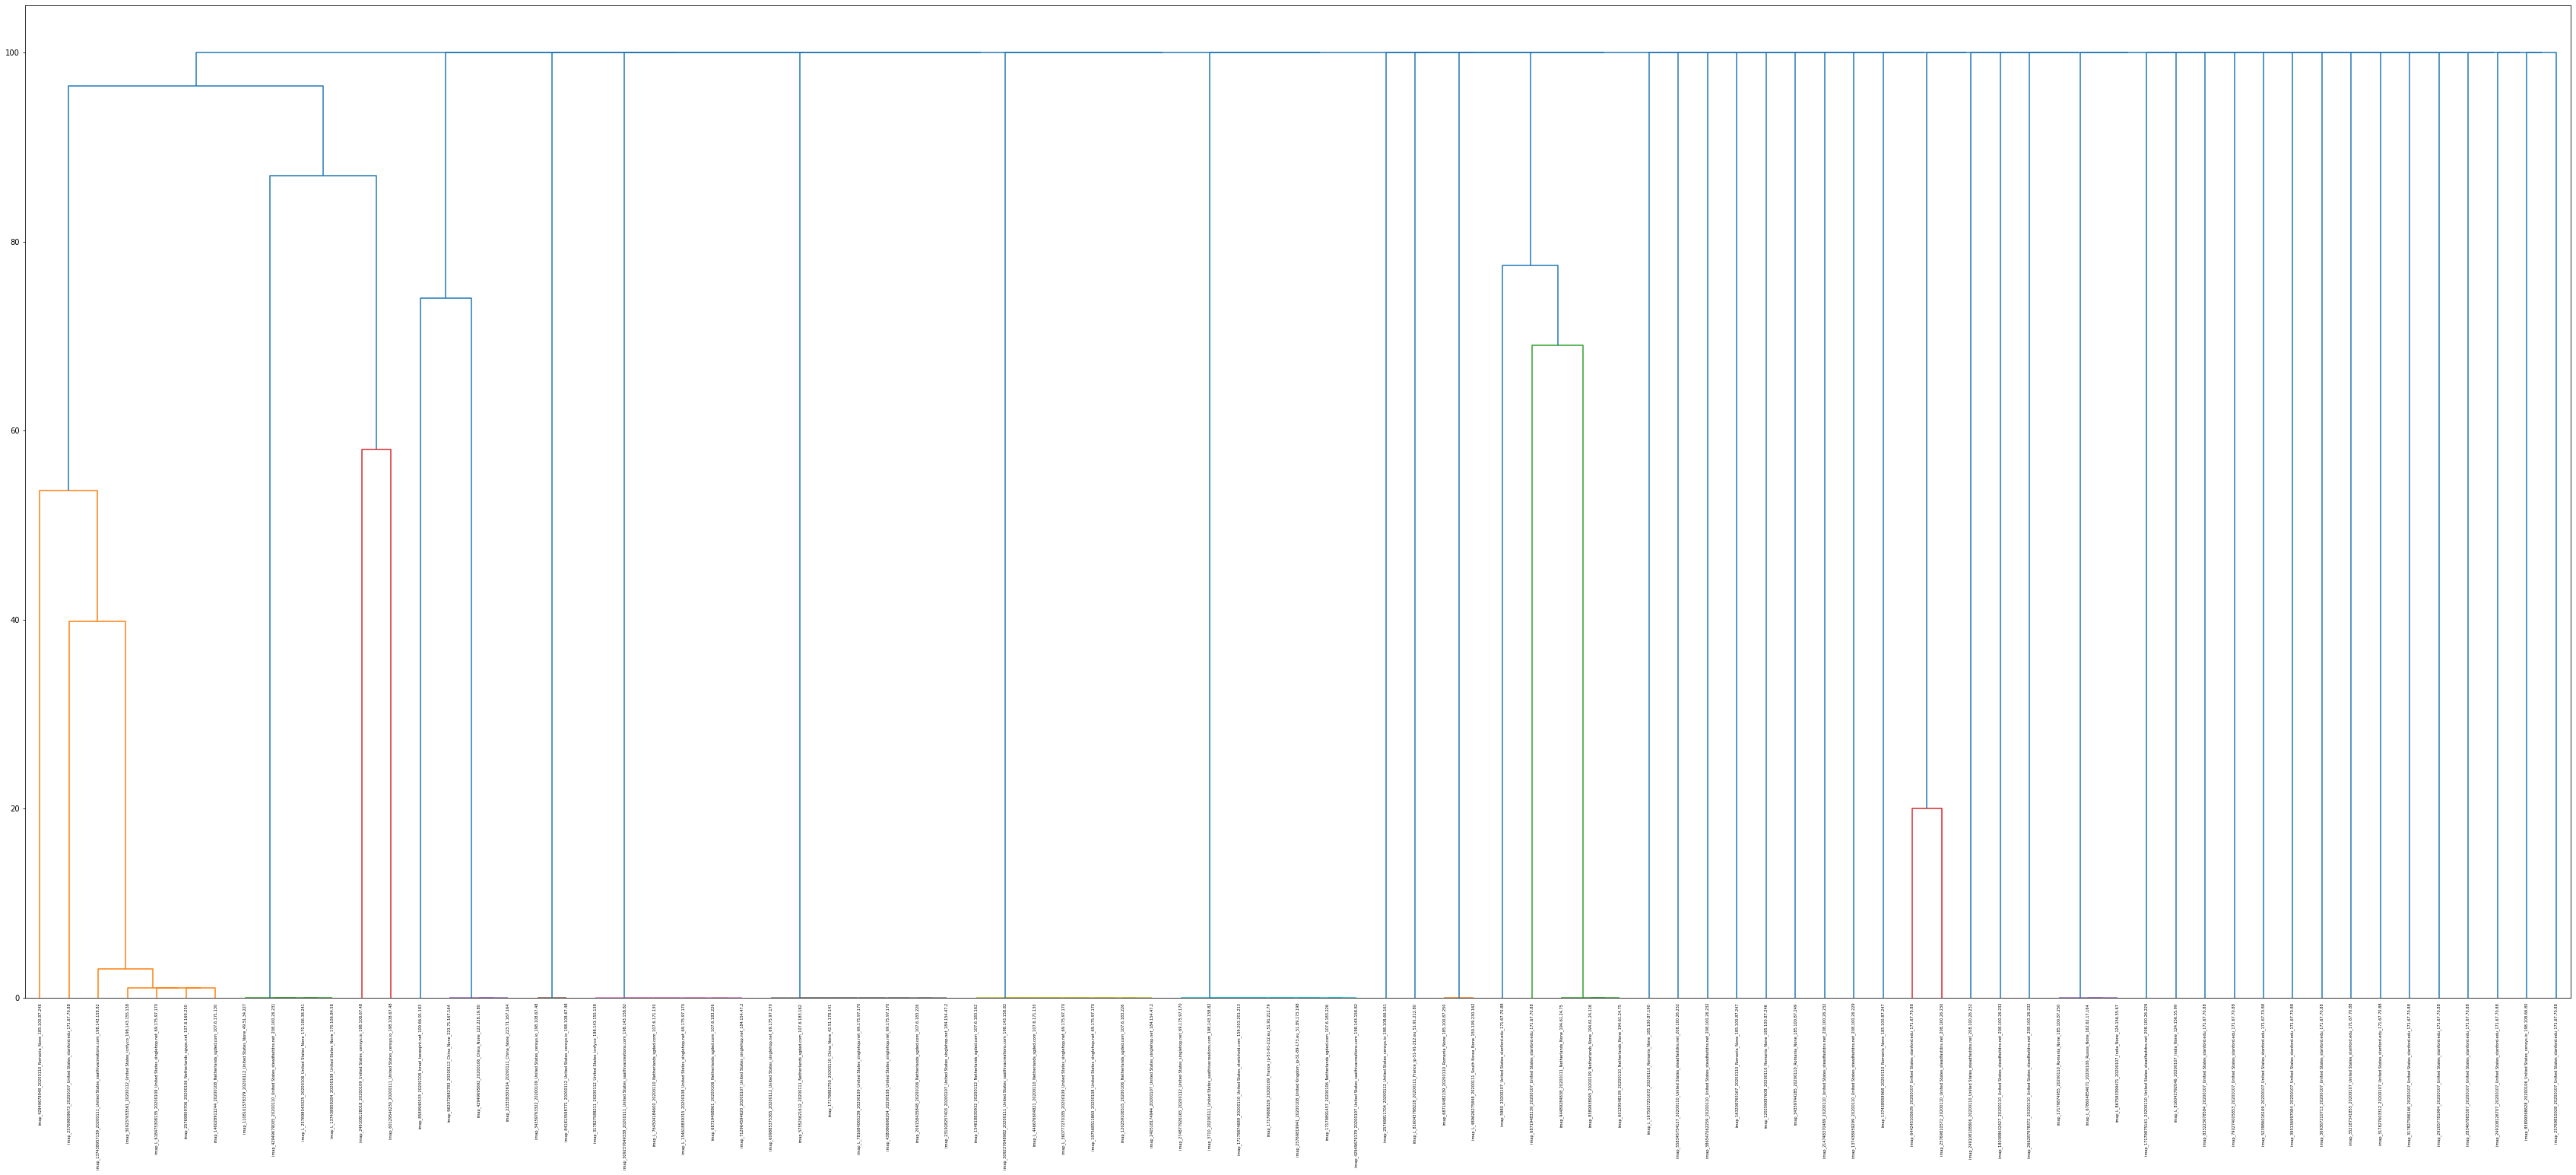

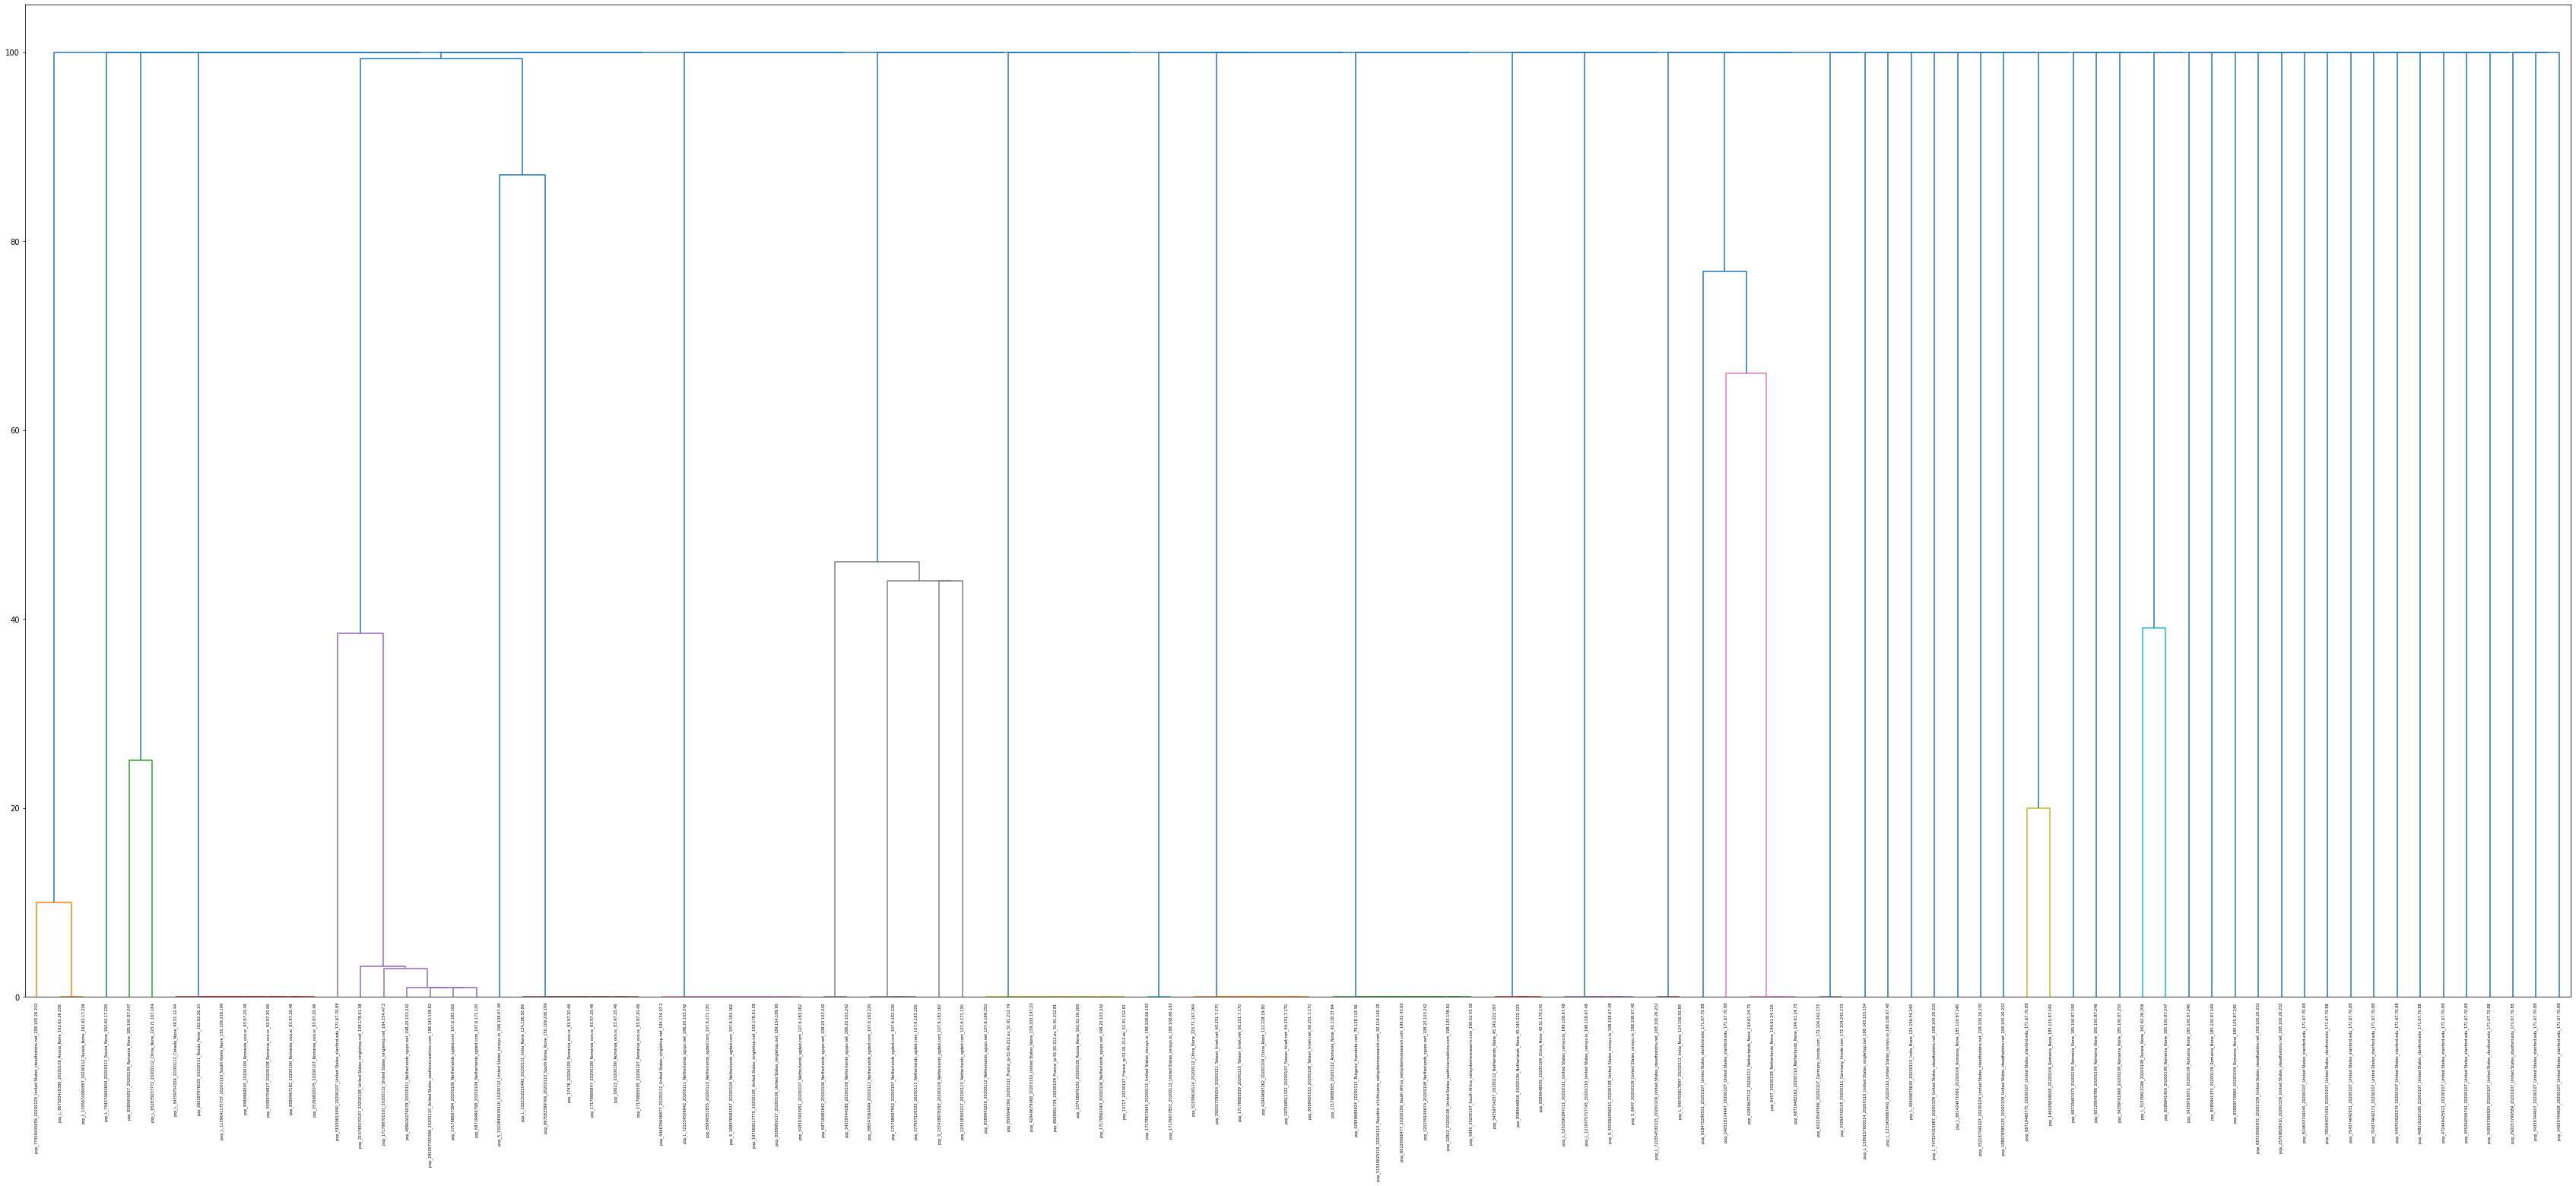

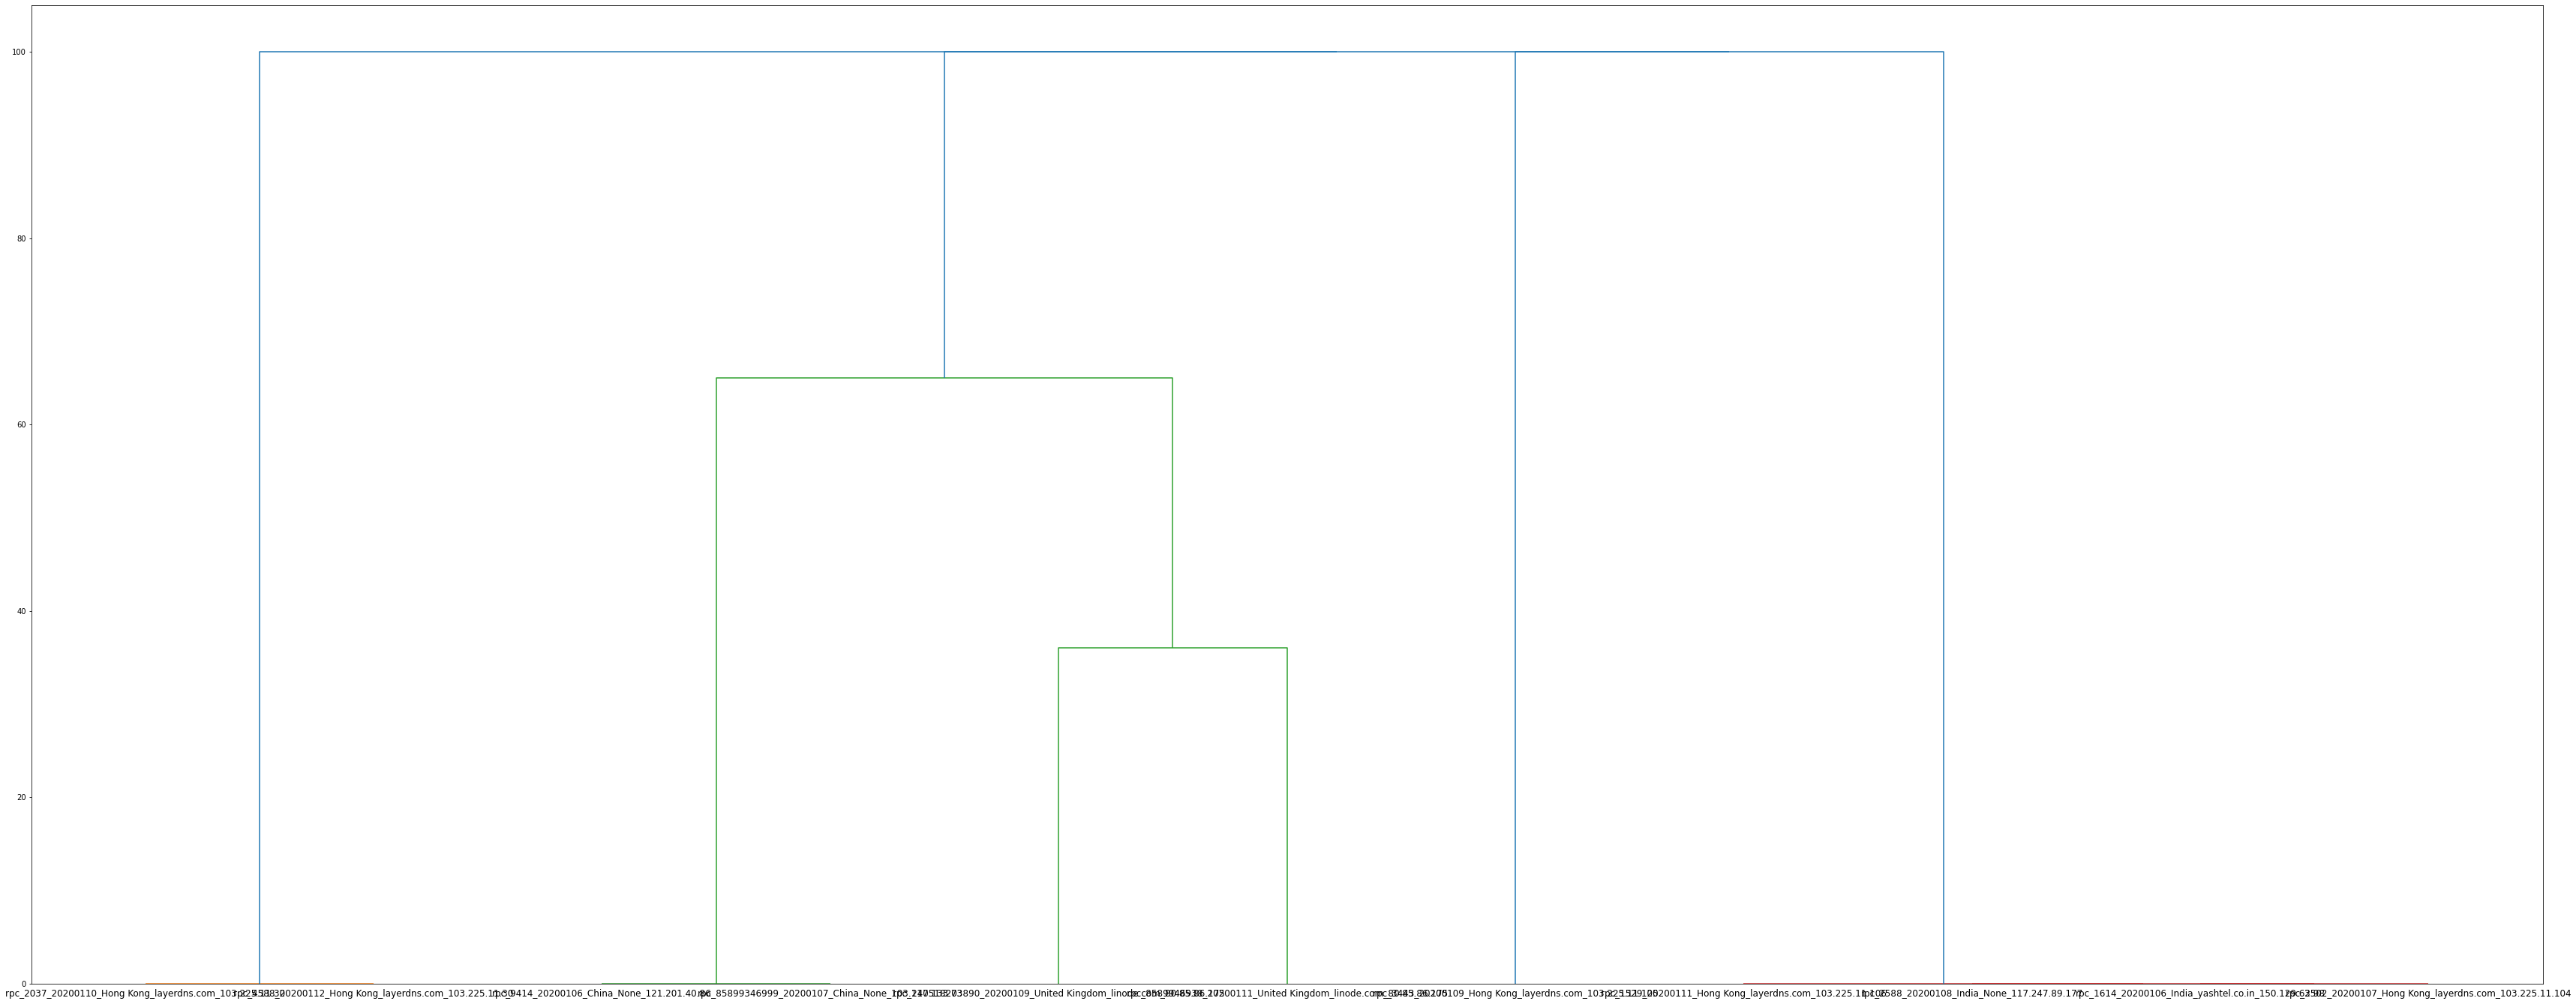

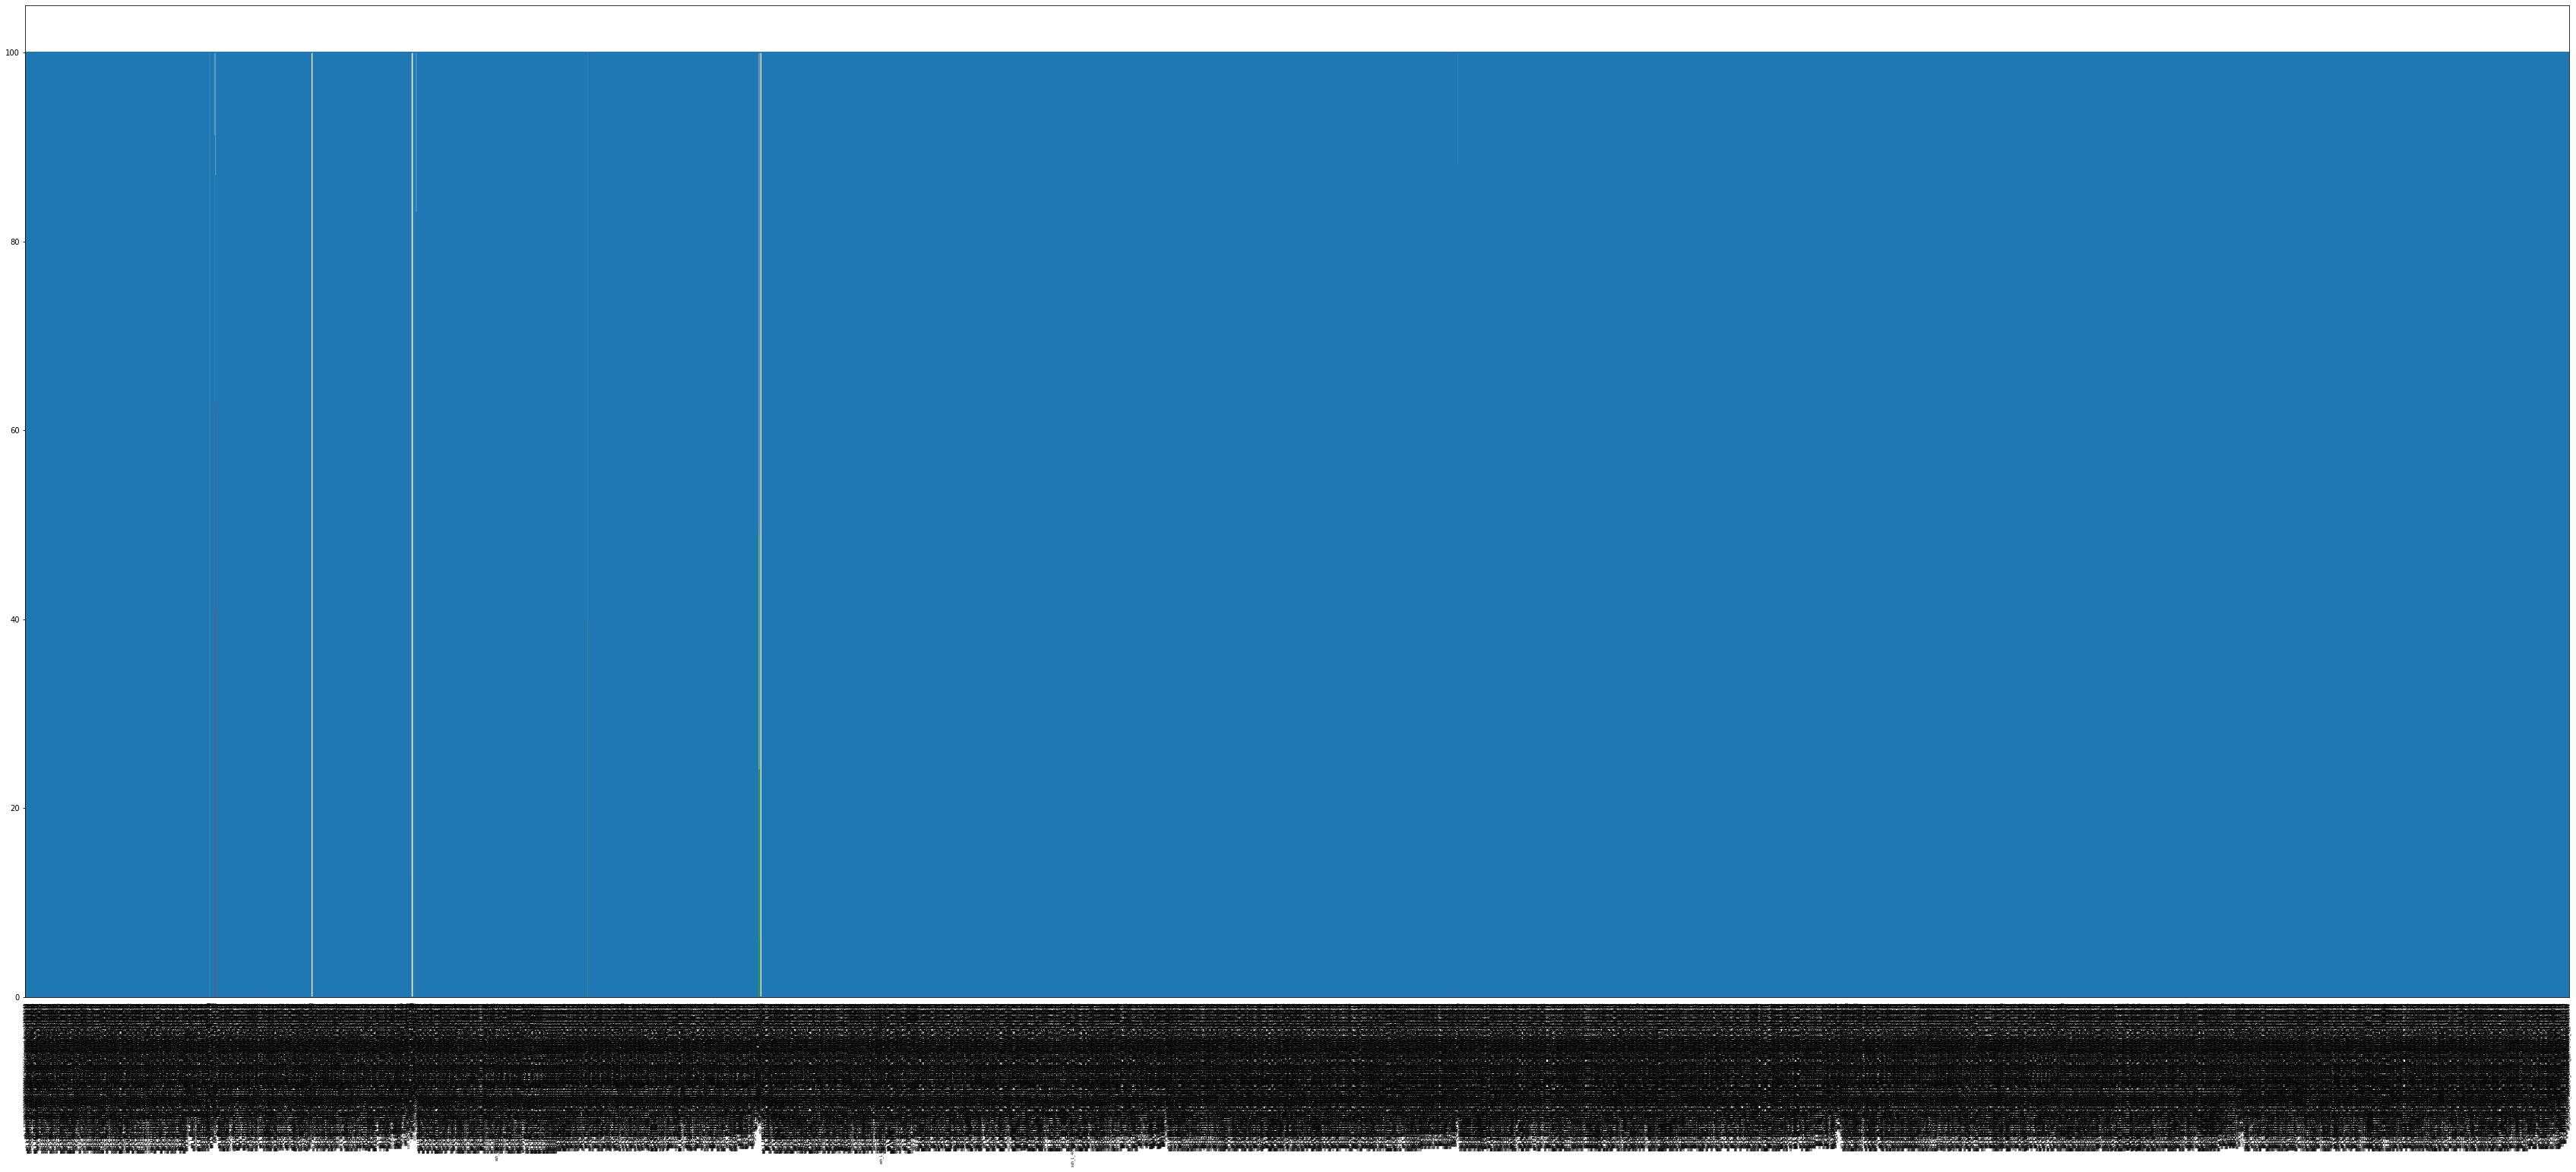

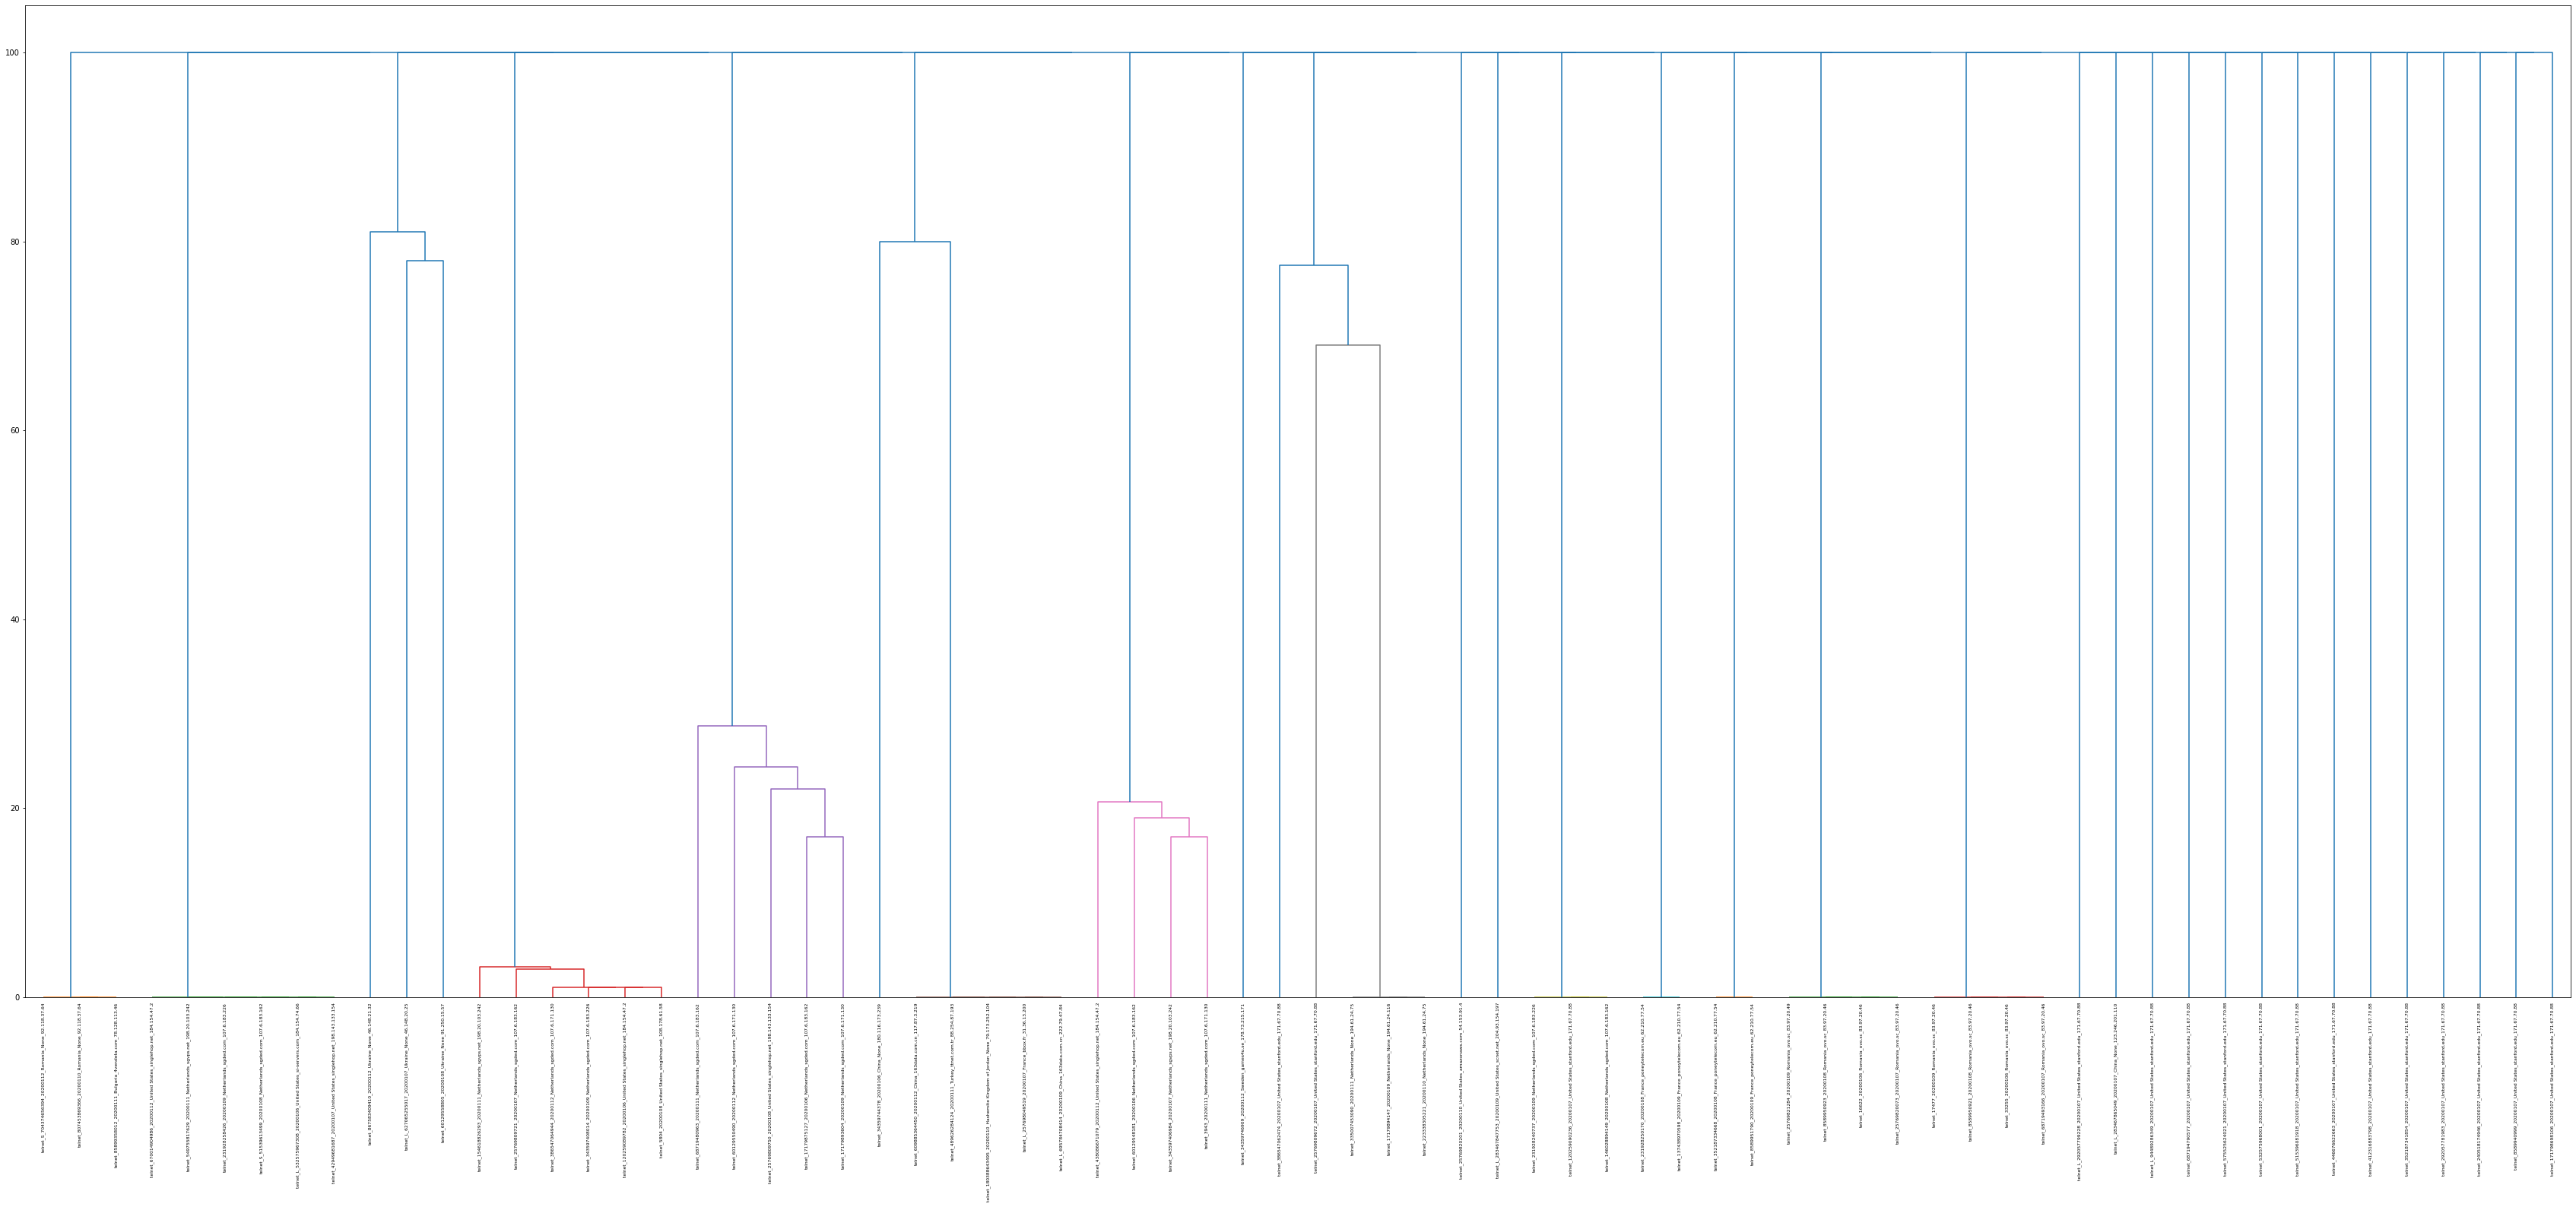

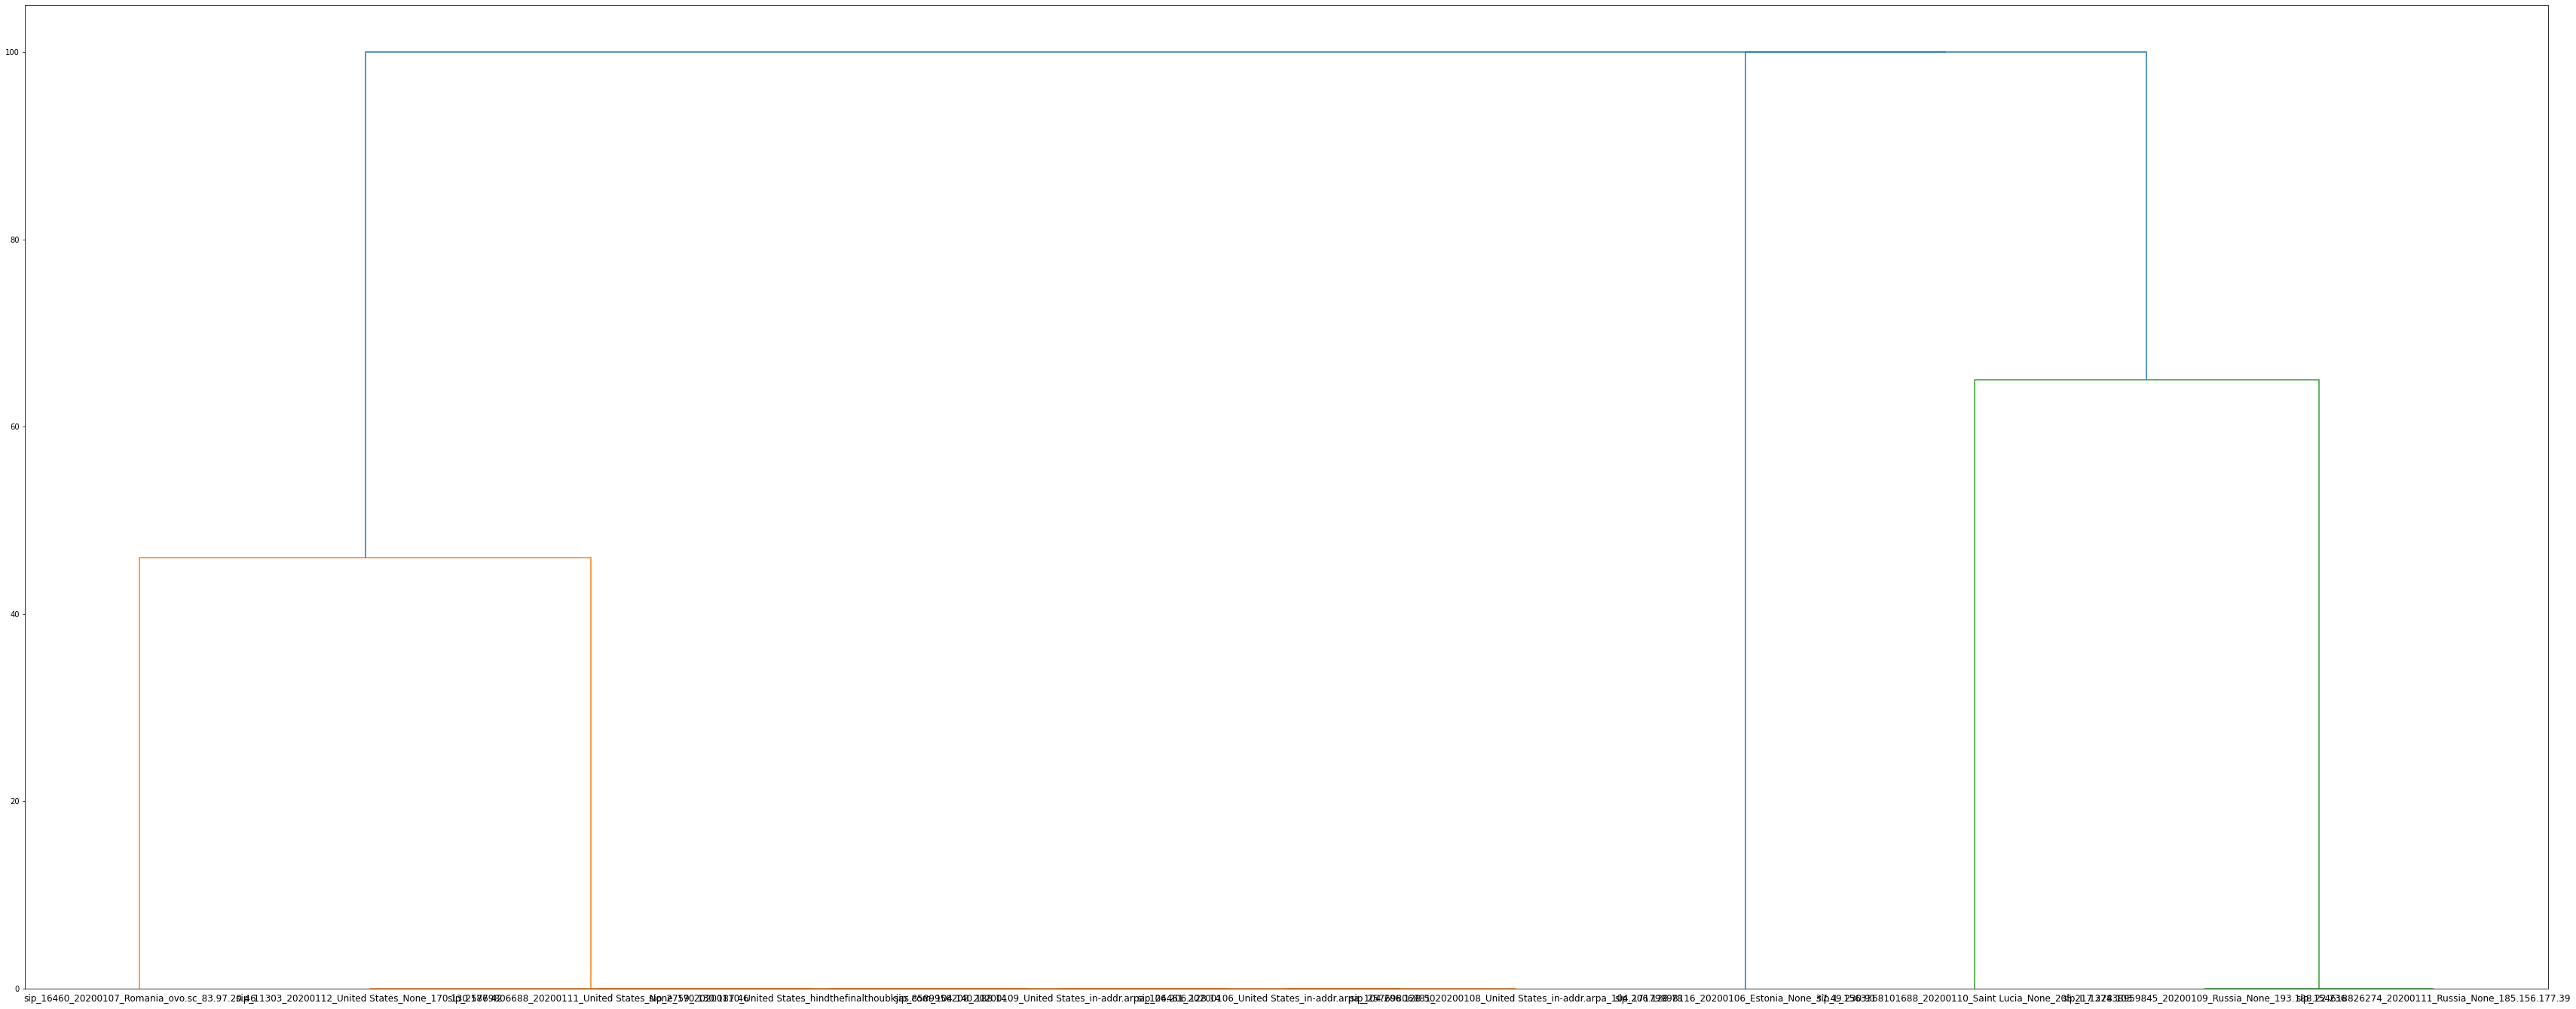

In [8]:
# 大家的pickle_dir都不同0109 0110 0111
# not save?

# time_li = ['02','10','30']
protocols_need = ['http','mysql','ftp','smb','smtp','imap','pop','rpc','ssh','telnet','sip']
# proto = HTTP, FTP, IMAP, MySQL, POP, RPC, SIP, SMB, SMTP, SSH, Telnet
for proto in tqdm(protocols_need):
    three_dict = {}
    for time in time_li:
        path = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/case_pickles/'+proto+'_upgma_dict_'+str(time)+'.pkl'
        try:
            temp = pickle.load(open(path,'rb'))
            three_dict.update(temp)
        except FileNotFoundError:
            print("!!! No file:",path,'!!!')
            continue


    loner_dict = {}
    for k,v in three_dict.items():
        if '_L_' in k:
            loner_dict[k]=v
        if '_S_' in k:
            loner_dict[k] =v
    time_li2 = [int(x) for x in time_li]
    min_time  = str(min(time_li2))
    max_time = str(max(time_li2))
    filename = "_".join(time_li)
    pickle.dump(obj=(three_dict,loner_dict),file=open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_time[:4])+'_'+str(min_time[4:6])+'_'+str(min_time[6:])+'/'+isp+'/case_pickles/combine_dict_loner_dict_'+filename+'.pkl','wb'))
    three_upgma_df = pair_wise_score(three_dict) #改!!
    dn,Z = draw_upgma(three_upgma_df,
               picture_dir='/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_time[:4])+'_'+str(min_time[4:6])+'_'+str(min_time[6:])+'/'+isp+'/case_pictures/' #改!!
               ,name=str(min_time)+'-'+str(max_time)+'_upgma') #改!! 0106-0112_upgma            
gc.collect()
loner_dict

In [ ]:
# three_upgma_df = pair_wise_score(three_dict) #改!!
# dn,Z = draw_upgma(three_upgma_df,
#            picture_dir='/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pictures/' #改!!
#            ,name='0106-0112_upgma') #改!! 0106-0112_upgma

In [ ]:
Z

## 畫跨天protocol大小圖

In [9]:
trend_dict_time_all = {}
trend_dict_country_all = {}
trend_dict_ip_all = {}
trend_dict_ssdeep_all = {}
def draw_trend_pic(date,proto,pickle_dir,trend_dict_time_all=trend_dict_time_all,trend_dict_country_all=trend_dict_country_all,trend_dict_ip_all=trend_dict_ip_all,trend_dict_ssdeep_all=trend_dict_ssdeep_all):
    '''
    GOAL: output dict to draw trend-circle picture
    
    Return: 4 dict for the same proto for the next day
    '''
    try:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
         proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except ValueError:
        try:
            (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
             proto_upgma_dict,stat_df,df2) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
        except ValueError:
            try:
                (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                        proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
            except ValueError:
                (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                        proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except FileNotFoundError:
        print("!!File Not Found:",date,proto,"!!")
        return trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all


    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            if type(candidate_hash) == str:
                return ssdeep.compare(target_hash,candidate_hash)
            else:
                score_li = []
                for c_h in candidate_hash:
                    score_li.append(ssdeep.compare(target_hash,c_h))
                return max(score_li)
        return candidate_df.hash.map(compare)

    trend_dict_time = {}
    trend_dict_country = {}
    trend_dict_ip = {}
    trend_dict_ssdeep = {}
    candidate_df = pd.DataFrame(trend_dict_ssdeep_all.items(),columns=['idx','hash']) #其他已經有的cluster
    for key,value in proto_big_dict.items():
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        t_q2_key = target.iloc[q2,-1] #要跟別人比較的cluster hash
        if trend_dict_ssdeep_all == {}: #第一次
            member_li = value[:]
            
            t_q2_member1 = proto_df_payload[proto_df_payload.idx == member_li[-1]] # member list最後一個
            t_q2_member1 = t_q2_member1.reset_index(drop=True)
            t_len = len(t_q2_member1)
            q2 = int(t_len*0.5)
            t_q2_member1 = t_q2_member1.iloc[q2,-1]
            
            t_q2_member2 = proto_df_payload[proto_df_payload.idx == max(member_li)] #member list最大的那個
            t_q2_member2 = t_q2_member2.reset_index(drop=True)
            t_len = len(t_q2_member2)
            q2 = int(t_len*0.5)
            t_q2_member2 = t_q2_member2.iloc[q2,-1]
            
            trend_dict_ssdeep[str(date)+"_"+str(key)] = [t_q2_key,t_q2_member1,t_q2_member2] #可以增加hash candidate?
            member_li.append(key)
            select_df = proto_df.loc[member_li]
            time_li = select_df.session_time.tolist()
            trend_dict_time[str(date)+"_"+str(key)] = time_li
            country_li = select_df.country.tolist()
            ip_li = select_df.ip_src.tolist()
            assert len(time_li) == len(country_li) == len(ip_li)
            trend_dict_country[str(date)+"_"+str(key)] = country_li
            trend_dict_ip[str(date)+"_"+str(key)] = ip_li
        else: #後面幾次
            candidate_df['score'] = ssdeep_compare(t_q2_key,candidate_df) 
            max_score = candidate_df.score.max()
            if max_score < 1: #都沒有相近的
                
                member_li = value[:]
                
                t_q2_member1 = proto_df_payload[proto_df_payload.idx == member_li[-1]] # member list最後一個
                t_q2_member1 = t_q2_member1.reset_index(drop=True)
                t_len = len(t_q2_member1)
                q2 = int(t_len*0.5)
                t_q2_member1 = t_q2_member1.iloc[q2,-1]

                t_q2_member2 = proto_df_payload[proto_df_payload.idx == max(member_li)] #member list最大的那個
                t_q2_member2 = t_q2_member2.reset_index(drop=True)
                t_len = len(t_q2_member2)
                q2 = int(t_len*0.5)
                t_q2_member2 = t_q2_member2.iloc[q2,-1]
                
                trend_dict_ssdeep[str(date)+"_"+str(key)] = [t_q2_key,t_q2_member1,t_q2_member2]
                member_li.append(key)
                select_df = proto_df.loc[member_li]
                time_li = select_df.session_time.tolist()
                trend_dict_time[str(date)+"_"+str(key)] = time_li
                country_li = select_df.country.tolist()
                ip_li = select_df.ip_src.tolist()
                assert len(time_li) == len(country_li) == len(ip_li)
                trend_dict_country[str(date)+"_"+str(key)] = country_li
                trend_dict_ip[str(date)+"_"+str(key)] = ip_li
            elif max_score>0: #有相近的合併到原本的dict
                try:
                    combine_id = candidate_df[candidate_df.score == max_score].idx.tolist()[0]
                except:
                    print( candidate_df,max_score,target)
                ori_ssdeep_list = trend_dict_ssdeep_all[combine_id][:]
                if type(ori_ssdeep_list) == str:
                    ori_ssdeep_list = [ori_ssdeep_list] #之前只有一個ssdeep hash
                ori_time_list = trend_dict_time_all[combine_id][:]
                ori_country_list = trend_dict_country_all[combine_id][:]
                ori_ip_list = trend_dict_ip_all[combine_id][:]
                member_li = value[:]
                
                t_q2_member1 = proto_df_payload[proto_df_payload.idx == member_li[-1]] # member list最後一個
                t_q2_member1 = t_q2_member1.reset_index(drop=True)
                t_len = len(t_q2_member1)
                q2 = int(t_len*0.5)
                t_q2_member1 = t_q2_member1.iloc[q2,-1]

                t_q2_member2 = proto_df_payload[proto_df_payload.idx == max(member_li)] #member list最大的那個
                t_q2_member2 = t_q2_member2.reset_index(drop=True)
                t_len = len(t_q2_member2)
                q2 = int(t_len*0.5)
                t_q2_member2 = t_q2_member2.iloc[q2,-1]                
                
                t_q2 = [t_q2_key,t_q2_member1,t_q2_member2]
                member_li.append(key)
                select_df = proto_df.loc[member_li]
                time_li = select_df.session_time.tolist()
                ori_time_list.extend(time_li)
                country_li = select_df.country.tolist()
                ip_li = select_df.ip_src.tolist()
                ori_country_list.extend(country_li)
                ori_ip_list.extend(ip_li)
                ori_ssdeep_list.extend(t_q2) #我合併進入別人的群，所以把我群的key hash也加入
                assert len(ori_time_list) == len(ori_country_list) == len(ori_ip_list)
                trend_dict_time_all[combine_id] = ori_time_list
                trend_dict_country_all[combine_id] = ori_country_list
                trend_dict_ip_all[combine_id] = ori_ip_list
                trend_dict_ssdeep_all[combine_id] = ori_ssdeep_list
            else:
                print(max_score)
#         break #debug
    trend_dict_time_all.update(trend_dict_time)
    trend_dict_country_all.update(trend_dict_country)
    trend_dict_ip_all.update(trend_dict_ip)
    trend_dict_ssdeep_all.update(trend_dict_ssdeep)
    return trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all

In [10]:
def sort_li(time_li, country_li):
    '''
    GOAL: sort by time (align with time's order)
    Return: list
    '''
    sort_country_li = [x for _,x in sorted(zip(time_li,country_li))]
    return sort_country_li

In [11]:

# 指定跨天日期們
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"] #,"0102","0130"
# date_li = ["0102","0106","0107","0108","0109","0110","0111","0112","0130"] #,"0102","0130"
# date_li = ['0102','0130','0110']
# isp = '亞太電信'
proto_li =  ['http','mysql','ftp','smb','smtp','imap','pop','rpc','ssh','telnet','sip']
# proto_li =  ['ssh','telnet','sip']
# proto_li = ['tds']
for proto in tqdm(proto_li):
    trend_dict_time_all = {}
    trend_dict_country_all = {}
    trend_dict_ip_all = {}
    trend_dict_ssdeep_all = {}
    for date in date_li:
        pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(date[:4])+'_'+str(date[4:6])+'_'+str(date[6:])+'/'+isp+'/case_pickles/'
        trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all = draw_trend_pic(date,proto,
                                                                                          pickle_dir,trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all)
    trend_dict_time_all = {k: v for k, v in sorted(trend_dict_time_all.items(), key=lambda item: len(item[1]),reverse=True)}
    time_df = pd.DataFrame(trend_dict_time_all.items(),columns=['idx','timestamp'])
    trend_dict_country_all = {k: v for k, v in sorted(trend_dict_country_all.items(), key=lambda item: len(item[1]),reverse=True)}
    country_df = pd.DataFrame(trend_dict_country_all.items(),columns=['idx','country'])
    trend_dict_ip_all = {k: v for k, v in sorted(trend_dict_ip_all.items(), key=lambda item: len(item[1]),reverse=True)}
    ip_df =  pd.DataFrame(trend_dict_ip_all.items(),columns=['idx','src_ip'])
    ssdeep_df = pd.DataFrame(trend_dict_ssdeep_all.items(),columns=['idx','ssdeep'])
    all_df = pd.merge(time_df,country_df,on='idx')
    all_df =  pd.merge(all_df,ip_df,on='idx')
    all_df = pd.merge(all_df,ssdeep_df,on='idx')
    all_df['country'] = all_df.apply(lambda x: sort_li(x.timestamp, x.country), axis=1)
    all_df['src_ip'] = all_df.apply(lambda x: sort_li(x.timestamp, x.src_ip), axis=1)
    all_df['timestamp'] = all_df.timestamp.map(sorted)
    file_name = "_".join(sorted(date_li))
    date_li2 = [int(x) for x in date_li]
    min_date = str(min(date_li2))
    pickle.dump(obj=all_df,
                file=open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','wb'))
    print("Protocol Pattern draw save path:",'/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl')

  9%|▉         | 1/11 [3:04:19<30:43:17, 11059.71s/it]

Protocol Pattern draw save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/http_trend_df_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 18%|█▊        | 2/11 [3:04:20<19:21:17, 7741.94s/it] 

Protocol Pattern draw save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/mysql_trend_df_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 27%|██▋       | 3/11 [3:04:20<12:02:36, 5419.60s/it]

Protocol Pattern draw save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/ftp_trend_df_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 36%|███▋      | 4/11 [3:04:32<7:22:59, 3797.06s/it] 

Protocol Pattern draw save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/smb_trend_df_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 45%|████▌     | 5/11 [3:04:33<4:25:49, 2658.30s/it]

Protocol Pattern draw save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/smtp_trend_df_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 55%|█████▍    | 6/11 [3:04:33<2:35:04, 1860.88s/it]

Protocol Pattern draw save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/imap_trend_df_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 64%|██████▎   | 7/11 [3:04:33<1:26:50, 1302.72s/it]

Protocol Pattern draw save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/pop_trend_df_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 73%|███████▎  | 8/11 [3:04:34<45:36, 912.04s/it]   

Protocol Pattern draw save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/rpc_trend_df_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 82%|████████▏ | 9/11 [3:07:36<23:05, 692.96s/it]

Protocol Pattern draw save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/ssh_trend_df_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


100%|██████████| 11/11 [3:07:36<00:00, 1023.35s/it]

Protocol Pattern draw save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/telnet_trend_df_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl
Protocol Pattern draw save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/sip_trend_df_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


In [ ]:
all_df

In [ ]:
# trend_dict_time_all = {}
# trend_dict_country_all = {}
# trend_dict_ip_all = {}
# trend_dict_ssdeep_all = {}
# # def draw_trend_pic(date,proto,pickle_dir,trend_dict_time_all=trend_dict_time_all,trend_dict_country_all=trend_dict_country_all,trend_dict_ip_all=trend_dict_ip_all,trend_dict_ssdeep_all=trend_dict_ssdeep_all):
# #     '''
# #     GOAL: output dict to draw trend-circle picture
    
# #     Return: 4 dict for the same proto for the next day
# #     '''
# date = '20200106'
# proto = 'http'
# pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(date[:4])+'_'+str(date[4:6])+'_'+str(date[6:])+'/'+isp+'/case_pickles/'
# (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
#  proto_upgma_dict,stat_df,df2) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))



# def ssdeep_compare(target_hash,candidate_df):
#     '''
#     Input1: string of hash
#     Input2: dataframe of candidate
#     '''
#     def compare(candidate_hash):
#         if type(candidate_hash) == str:
#             return ssdeep.compare(target_hash,candidate_hash)
#         else:
#             score_li = []
#             for c_h in candidate_hash:
#                 score_li.append(ssdeep.compare(target_hash,c_h))
#             return max(score_li)
#     return candidate_df.hash.map(compare)

# trend_dict_time = {}
# trend_dict_country = {}
# trend_dict_ip = {}
# trend_dict_ssdeep = {}
# candidate_df = pd.DataFrame(trend_dict_ssdeep_all.items(),columns=['idx','hash']) #其他已經有的cluster
# for key,value in proto_big_dict.items():
#     target = proto_df_payload[proto_df_payload.idx == key]
#     target = target.reset_index(drop=True)
#     t_len = len(target)
#     q2 = int(t_len*0.5)
#     t_q2_key = target.iloc[q2,-1] #要跟別人比較的cluster hash
#     if trend_dict_ssdeep_all == {}: #第一次
#         member_li = value[:]

#         t_q2_member1 = proto_df_payload[proto_df_payload.idx == member_li[-1]] # member list最後一個
#         t_q2_member1 = t_q2_member1.reset_index(drop=True)
#         t_len = len(t_q2_member1)
#         q2 = int(t_len*0.5)
#         t_q2_member1 = t_q2_member1.iloc[q2,-1]

#         t_q2_member2 = proto_df_payload[proto_df_payload.idx == max(member_li)] #member list最大的那個
#         t_q2_member2 = t_q2_member2.reset_index(drop=True)
#         t_len = len(t_q2_member2)
#         q2 = int(t_len*0.5)
#         t_q2_member2 = t_q2_member2.iloc[q2,-1]

#         trend_dict_ssdeep[str(date)+"_"+str(key)] = [t_q2_key,t_q2_member1,t_q2_member2] #可以增加hash candidate?
#         member_li.append(key)
#         select_df = proto_df.loc[member_li]
#         time_li = select_df.session_time.tolist()
#         trend_dict_time[str(date)+"_"+str(key)] = time_li
#         country_li = select_df.country.tolist()
#         ip_li = select_df.ip_src.tolist()
#         assert len(time_li) == len(country_li) == len(ip_li)
#         trend_dict_country[str(date)+"_"+str(key)] = country_li
#         trend_dict_ip[str(date)+"_"+str(key)] = ip_li
#     else: #後面幾次
#         candidate_df['score'] = ssdeep_compare(t_q2,candidate_df) 
#         max_score = candidate_df.score.max()
#         if max_score < 1: #都沒有相近的

#             member_li = value[:]

#             t_q2_member1 = proto_df_payload[proto_df_payload.idx == member_li[-1]] # member list最後一個
#             t_q2_member1 = t_q2_member1.reset_index(drop=True)
#             t_len = len(t_q2_member1)
#             q2 = int(t_len*0.5)
#             t_q2_member1 = t_q2_member1.iloc[q2,-1]

#             t_q2_member2 = proto_df_payload[proto_df_payload.idx == max(member_li)] #member list最大的那個
#             t_q2_member2 = t_q2_member2.reset_index(drop=True)
#             t_len = len(t_q2_member2)
#             q2 = int(t_len*0.5)
#             t_q2_member2 = t_q2_member2.iloc[q2,-1]

#             trend_dict_ssdeep[str(date)+"_"+str(key)] = [t_q2_key,t_q2_member1,t_q2_member2]
#             member_li.append(key)
#             select_df = proto_df.loc[member_li]
#             time_li = select_df.session_time.tolist()
#             trend_dict_time[str(date)+"_"+str(key)] = time_li
#             country_li = select_df.country.tolist()
#             ip_li = select_df.ip_src.tolist()
#             assert len(time_li) == len(country_li) == len(ip_li)
#             trend_dict_country[str(date)+"_"+str(key)] = country_li
#             trend_dict_ip[str(date)+"_"+str(key)] = ip_li
#         elif max_score>0: #有相近的合併到原本的dict
#             try:
#                 combine_id = candidate_df[candidate_df.score == max_score].idx.tolist()[0]
#             except:
#                 print( candidate_df,max_score,target)
#             ori_ssdeep_list = trend_dict_ssdeep_all[combine_id][:]
#             if type(ori_ssdeep_list) == str:
#                 ori_ssdeep_list = [ori_ssdeep_list] #之前只有一個ssdeep hash
#             ori_time_list = trend_dict_time_all[combine_id][:]
#             ori_country_list = trend_dict_country_all[combine_id][:]
#             ori_ip_list = trend_dict_ip_all[combine_id][:]
#             member_li = value[:]

#             t_q2_member1 = proto_df_payload[proto_df_payload.idx == member_li[-1]] # member list最後一個
#             t_q2_member1 = t_q2_member1.reset_index(drop=True)
#             t_len = len(t_q2_member1)
#             q2 = int(t_len*0.5)
#             t_q2_member1 = t_q2_member1.iloc[q2,-1]

#             t_q2_member2 = proto_df_payload[proto_df_payload.idx == max(member_li)] #member list最大的那個
#             t_q2_member2 = t_q2_member2.reset_index(drop=True)
#             t_len = len(t_q2_member2)
#             q2 = int(t_len*0.5)
#             t_q2_member2 = t_q2_member2.iloc[q2,-1]                

#             t_q2 = [t_q2_key,t_q2_member1,t_q2_member2]
#             member_li.append(key)
#             select_df = proto_df.loc[member_li]
#             time_li = select_df.session_time.tolist()
#             ori_time_list.extend(time_li)
#             country_li = select_df.country.tolist()
#             ip_li = select_df.ip_src.tolist()
#             ori_country_list.extend(country_li)
#             ori_ip_list.extend(ip_li)
#             ori_ssdeep_list.extend(t_q2) #我合併進入別人的群，所以把我群的key hash也加入
#             assert len(ori_time_list) == len(ori_country_list) == len(ori_ip_list)
#             trend_dict_time_all[combine_id] = ori_time_list
#             trend_dict_country_all[combine_id] = ori_country_list
#             trend_dict_ip_all[combine_id] = ori_ip_list
#             trend_dict_ssdeep_all[combine_id] = ori_ssdeep_list
#         else:
#             print(max_score)
# #         break #debug
# trend_dict_time_all.update(trend_dict_time)
# trend_dict_country_all.update(trend_dict_country)
# trend_dict_ip_all.update(trend_dict_ip)
# trend_dict_ssdeep_all.update(trend_dict_ssdeep)
# # return trend_dict_time_all,trend_dict_country_all,trend_dict_ip_all,trend_dict_ssdeep_all

輸出cluster之key session的time list

In [12]:
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"]
min(date_li)

'20200106'

In [13]:
proto_li = ['http','mysql','ftp','smb','smtp','imap','pop','rpc','ssh','telnet','sip']
#'http','smb','telnet','ftp','smtp','mysql','ssh','rpc','imap','pop','sip'
# proto = 'tds' 'tds','http',

# date_li = ["0102","0106","0107","0108","0109","0110","0111","0112","0130"] #,"0102","0130"
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"] #,"0102","0130"
# date_li = ['0102','0130','0110']
file_name = "_".join(sorted(date_li))
min_date = str(min(date_li))
for proto in tqdm(proto_li):
    http_df = pickle.load(open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','rb'))

    #輸出cluster之key session的time list
    wireshark_li = http_df.idx.tolist() #.head(15)前15大cluster #改!proto
    wireshark_rank = []
    for i,v in enumerate(wireshark_li):
        wireshark_rank.append(i+1)
    wireshark_rank = [x for _,x in sorted(zip(wireshark_li,wireshark_rank))]
    wireshark_li = sorted(wireshark_li)

    save_path_li = []
    now_date = '00' #現在正在處理的日期
    for i,wireshark in zip(wireshark_rank,wireshark_li):
        date = wireshark.split('_')[0] #該cluster key的同月份日期
        if date!= now_date: #新日期才要重讀
            now_date = date

            pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(date[:4])+'_'+str(date[4:6])+'_'+str(date[6:])+'/'+isp+'/case_pickles/'
            try:
                (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                 proto_upgma_dict,stat_df,df2) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
            except ValueError:
                try:
                    (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                            proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
                except ValueError:
                    (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                            proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
            except FileNotFoundError:
                print("!!File Not Found:",date,proto,"!!")
        idx = wireshark.split('_')[-1] #該cluster在該日期該proto的df中的index
        #     else:
        try:
            time_list = proto_df.loc[int(idx),'session_time_list'].tolist()
        except AttributeError:
            time_list = proto_df.loc[int(idx),'session_time_list']
        timelist_path = pickle_dir+'timelist_'+proto+'_large#'+str(i)+'_clusterID#'+str(idx)+'.pkl'
        pickle.dump(file=open(timelist_path,'wb'),obj=time_list)
#         print(wireshark,'save in:',timelist_path) #truly save path
        save_path_li.append(timelist_path)

    first_date = wireshark_li[0].split('_')[0]#[-2:]
    save_path = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(first_date[:4])+'_'+str(first_date[4:6])+'_'+str(first_date[6:])+'/'+isp+'/case_pickles/'+proto+'_clusterKey_timelist_paths_'+file_name+'.pkl'
    pickle.dump(file=open(save_path,'wb'),obj=save_path_li)  
    print(proto,':',save_path) #for 証鴻 pickle save path


# http_df

  9%|▉         | 1/11 [16:12:36<162:06:08, 58356.81s/it]

http : /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/http_clusterKey_timelist_paths_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 18%|█▊        | 2/11 [16:20:17<102:28:10, 40987.88s/it]

mysql : /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/mysql_clusterKey_timelist_paths_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 27%|██▋       | 3/11 [16:20:17<63:45:33, 28691.70s/it] 

ftp : /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/ftp_clusterKey_timelist_paths_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 36%|███▋      | 4/11 [16:20:20<39:03:14, 20084.91s/it]

smb : /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/smb_clusterKey_timelist_paths_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 45%|████▌     | 5/11 [16:20:21<23:25:58, 14059.77s/it]

smtp : /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/smtp_clusterKey_timelist_paths_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl
imap : /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/imap_clusterKey_timelist_paths_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 73%|███████▎  | 8/11 [16:20:21<5:44:28, 6889.37s/it]  

pop : /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/pop_clusterKey_timelist_paths_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl
rpc : /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/rpc_clusterKey_timelist_paths_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


 82%|████████▏ | 9/11 [16:24:34<2:43:16, 4898.50s/it]

ssh : /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/ssh_clusterKey_timelist_paths_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


100%|██████████| 11/11 [16:24:39<00:00, 5370.90s/it] 

telnet : /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/telnet_clusterKey_timelist_paths_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl
sip : /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/sip_clusterKey_timelist_paths_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl


In [ ]:
# def timestamp_cut_country(time_li,country_li):
#     thr_lower = 1577887200
#     thr_upper = 1577984400 #2020-01-03 01
#     c_li = []
# #     i_li = []
#     for t,c,i in zip(time_li,country_li):
#         if thr_lower<t<thr_upper:
#             c_li.append(c)
# #             i_li.append(i)
#     return c_li

# def timestamp_cut_ip(time_li,country_li,ip_li):
#     thr_lower = 1577887200
#     thr_upper = 1577984400 #2020-01-03 01
#     c_li = []
#     i_li = []
#     for t,c,i in zip(time_li,country_li,ip_li):
#         if 1577887200<t<thr_upper:
#             c_li.append(c)
#             i_li.append(i)
#     return i_li

In [ ]:
# time.mktime(time.strptime('2020-01-03 01','%Y-%m-%d %H'))

In [ ]:
# #輸出cluster之key session的time list
# wireshark_li = http_df.idx.tolist() #.head(15)前15大cluster #改!proto
# wireshark_rank = []
# for i,v in enumerate(wireshark_li):
#     wireshark_rank.append(i+1)
# wireshark_rank = [x for _,x in sorted(zip(wireshark_li,wireshark_rank))]
# wireshark_li = sorted(wireshark_li)

# save_path_li = []
# now_date = '00' #現在正在處理的日期
# for i,wireshark in tqdm(zip(wireshark_rank,wireshark_li)):
#     date = wireshark.split('_')[0] #該cluster key的同月份日期
#     if date!= now_date: #新日期才要重讀
#         now_date = date
        
#         pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(date[-2:])+'/中華電信/case_pickles/'
#         try:
#             (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
#                                     proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
#         except ValueError:
#             (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
#                                     proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
#         except FileNotFoundError:
#             continue
#     idx = wireshark.split('_')[-1] #該cluster在該日期該proto的df中的index
#     #     else:
#     try:
#         time_list = proto_df.loc[int(idx),'session_time_list'].tolist()
#     except AttributeError:
#         time_list = proto_df.loc[int(idx),'session_time_list']
#     timelist_path = pickle_dir+'timelist_'+proto+'_large#'+str(i)+'_clusterID#'+str(idx)+'.pkl'
#     pickle.dump(file=open(timelist_path,'wb'),obj=time_list)
#     print(wireshark,'save in:',timelist_path)
#     save_path_li.append(timelist_path)

# first_date = wireshark_li[0].split('_')[0][-2:]
# save_path = '/home/antslab/spark_data/pcap_inter/2020_01_'+first_date+'/中華電信/case_pickles/'+proto+'_clusterKey_timelist_paths_'+file_name+'.pkl'
# pickle.dump(file=open(save_path,'wb'),obj=save_path_li)  
# print('all paths in:',save_path)

#### 新關聯方法
* topology
    * 我們會先找所給定期間的指定所有protocols之所有sessions與對應IPs
    * 接下來會利用此段期間的各IP，去尋找這個IP在這段期間做的手法(攻擊樣態群集)
    * 找出不同IP所橫跨對應的攻擊樣態群，計算jaccard相似度
    * 將所採用相似手法(score>thr)的IP群聚

In [14]:
#第一次只要跑這格。
proto_li =  ['http','mysql','ftp','smb','smtp','imap','pop','rpc','ssh','telnet','sip'] #改!!'tds',
# date_li2 = ["0106","0107","0108","0109","0110","0111","0112"] 
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"]  #改!!
# date_li = ['0102','0130','0110']
file_name = "_".join(sorted(date_li)) #改!!
min_date = str(min(date_li))
max_date = str(max(date_li))
for i,proto in enumerate(proto_li):
    if i==0:
        all_df = pickle.load(file=open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','rb')) #改!!)
        all_df['idx'] = all_df['idx']+'_'+proto
    else:
        temp = pickle.load(file=open('/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'+proto+'_trend_df_'+file_name+'.pkl','rb')) #改!!
        temp['idx'] = temp['idx']+'_'+proto
        all_df = all_df.append(temp)
all_df = all_df.reset_index(drop=True)
#首次須先輸出noise pkl給証鴻，另外處理後才會獲得noise_clusters
pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'
pickle.dump(file=open(pickle_dir+'clusterName_overview_denoise_df_'+str(min_date)+'_'+str(date_li[-1])+'.pkl','wb'),obj=all_df)
print("Denoise path save in:",
      pickle_dir+'clusterName_overview_denoise_df_'+str(min_date)+'_'+str(date_li[-1])+'.pkl')
all_df

Denoise path save in: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/clusterName_overview_denoise_df_20200106_20200112.pkl


,idx,timestamp,country,src_ip,ssdeep
0,20200106_15666_http,"[1578239454.109651, 1578239470.109467, 1578239...","[United States, United States, United States, ...","[66.249.79.68, 66.249.75.7, 66.249.79.47, 66.2...",[48:+xfTmaK8O918hw18VcM18xdnXtctdLJCAY6S:+9Yt9...
1,20200106_701_http,"[1578239433.558292, 1578239437.866685, 1578239...","[Vietnam, United States, Iran, United States, ...","[103.130.58.27, 216.244.66.196, 5.235.204.10, ...",[12:rHXq6x5i7CIs0+R56Y1awh5UPlVFYNjZpvhm:DaKi7...
2,20200106_1946_http,"[1578239461.751976, 1578239567.092316, 1578239...","[Chile, Chile, France, China, China, China, Fr...","[186.10.66.139, 186.10.66.139, 51.89.100.102, ...",[12:72SEmHXq/I75cuXNFljI4Dx5iWGH46ZY1Zu8m:7eAa...
3,20200106_1947_http,"[1578239434.113271, 1578239450.110779, 1578239...","[United States, United States, United States, ...","[66.249.69.237, 66.249.79.13, 66.249.79.56, 66...",[24:uaKiWMS18YH+w18YHxKafv4qHZt1HBlxiWlbMzc9:u...
4,20200106_249108135258_http,"[1578242571.285274, 1578303819.407774, 1578325...","[United States, United States, United States, ...","[66.249.79.27, 66.249.79.232, 66.249.79.54, 66...",[24:tAACfDXMcXoaKiBZt1HyxiOfAACfDXKCTjeN1dqg5t...
...,...,...,...,...,...
329,20200107_575525624021_telnet,"[1578382601.017765, 1578383065.829879]","[United States, United States]","[171.67.70.88, 171.67.70.88]",[48:rvD/IH5W0q0WKRAR2Tt9rZi8DCNnvD/CCgvi9cLMlQ...
330,20200107_687194790577_telnet,"[1578382539.191471, 1578382995.980119]","[United States, United States]","[171.67.70.88, 171.67.70.88]","[3:QVE:Qu, 3:QVE:Qu, 3:QVE:Qu]"
331,20200106_26461_sip,"[1578239673.253204, 1578239712.515272, 1578240...","[United States, United States, United States, ...","[104.206.128.30, 104.206.128.30, 104.206.128.7...",[24:qgOf3vI7mDL5gizTKiqf3vX4v/DRt0UUgbYMfy1wUX...
332,20200106_17179898116_sip,"[1578274141.536307, 1578274141.540034, 1578274...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[37.49.230.91, 37.49.230.91, 37.49.230.91, 37....",[24:pdiWjhnz0QiWLiW2qmDED8g4ijj87BZsKiXYEXl8XQ...


In [15]:
#注意參數!!第二次可以直接從這邊開始跑。
isp = '台固媒體'
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"]  #改!!
file_name = "_".join(sorted(date_li)) #date_li 改!!
min_date = str(min(date_li))
max_date = str(max(date_li))

In [16]:
#第二次從這邊跑:
noise_path = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/noise_cluster.pkl'
denoise_path = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/denoise_cluster.pkl'
pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'
all_df = pickle.load(open(pickle_dir+'clusterName_overview_denoise_df_'+str(min_date)+'_'+str(date_li[-1])+'.pkl','rb'))
noise_clusters = pickle.load(open(noise_path,'rb'))
denoise_clusters = pickle.load(open(denoise_path,'rb'))
assert len(noise_clusters) + len(denoise_clusters) == len(all_df)
all_df = all_df[~all_df.idx.isin(noise_clusters)]
# all_df = all_df[all_df.idx.isin(denoise_clusters)]
# all_df = all_df.reset_index(drop=True)
all_df
# noise_clusters

,idx,timestamp,country,src_ip,ssdeep
0,20200106_15666_http,"[1578239454.109651, 1578239470.109467, 1578239...","[United States, United States, United States, ...","[66.249.79.68, 66.249.75.7, 66.249.79.47, 66.2...",[48:+xfTmaK8O918hw18VcM18xdnXtctdLJCAY6S:+9Yt9...
1,20200106_701_http,"[1578239433.558292, 1578239437.866685, 1578239...","[Vietnam, United States, Iran, United States, ...","[103.130.58.27, 216.244.66.196, 5.235.204.10, ...",[12:rHXq6x5i7CIs0+R56Y1awh5UPlVFYNjZpvhm:DaKi7...
2,20200106_1946_http,"[1578239461.751976, 1578239567.092316, 1578239...","[Chile, Chile, France, China, China, China, Fr...","[186.10.66.139, 186.10.66.139, 51.89.100.102, ...",[12:72SEmHXq/I75cuXNFljI4Dx5iWGH46ZY1Zu8m:7eAa...
3,20200106_1947_http,"[1578239434.113271, 1578239450.110779, 1578239...","[United States, United States, United States, ...","[66.249.69.237, 66.249.79.13, 66.249.79.56, 66...",[24:uaKiWMS18YH+w18YHxKafv4qHZt1HBlxiWlbMzc9:u...
4,20200106_249108135258_http,"[1578242571.285274, 1578303819.407774, 1578325...","[United States, United States, United States, ...","[66.249.79.27, 66.249.79.232, 66.249.79.54, 66...",[24:tAACfDXMcXoaKiBZt1HyxiOfAACfDXKCTjeN1dqg5t...
...,...,...,...,...,...
329,20200107_575525624021_telnet,"[1578382601.017765, 1578383065.829879]","[United States, United States]","[171.67.70.88, 171.67.70.88]",[48:rvD/IH5W0q0WKRAR2Tt9rZi8DCNnvD/CCgvi9cLMlQ...
330,20200107_687194790577_telnet,"[1578382539.191471, 1578382995.980119]","[United States, United States]","[171.67.70.88, 171.67.70.88]","[3:QVE:Qu, 3:QVE:Qu, 3:QVE:Qu]"
331,20200106_26461_sip,"[1578239673.253204, 1578239712.515272, 1578240...","[United States, United States, United States, ...","[104.206.128.30, 104.206.128.30, 104.206.128.7...",[24:qgOf3vI7mDL5gizTKiqf3vX4v/DRt0UUgbYMfy1wUX...
332,20200106_17179898116_sip,"[1578274141.536307, 1578274141.540034, 1578274...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[37.49.230.91, 37.49.230.91, 37.49.230.91, 37....",[24:pdiWjhnz0QiWLiW2qmDED8g4ijj87BZsKiXYEXl8XQ...


In [ ]:
def cut_protocol(cluster_id):
    '''
    GOAL: 將cluster index轉換為protocol名稱
    '''
    return cluster_id.split("_")[-1]
def count_sessions_num(time_li):
    '''
    GOAL: 依據timestamp list計算每個cluster所具有的session數量
    '''
    return len(time_li)
all_df['protocol'] = all_df.idx.map(cut_protocol)
all_df['session_num'] = all_df.timestamp.map(count_sessions_num)
print(isp,"經濾除noiseClusters後在",min_date,"至",max_date,"的期間中各protocols的session數量:")
#all_df.groupby("protocol")['timestamp'].sum().apply(len) #alternative
temp = pd.DataFrame(all_df.groupby('protocol')['session_num'].sum()).sort_values('session_num',ascending=False)
temp

In [17]:
#find all ips
all_ips = all_df.src_ip.tolist()
all_ips = sum(all_ips,[])
all_ips = list(set(all_ips))
all_ips = sorted(all_ips)
# col_li = ['Country']
# col_li.extend(all_df.idx.tolist())
col_li = all_df.idx.tolist()
# col_li = [x for x in col_li if 'tds' not in x]
# col_li.append('tds') #改!!
jc_matrix = pd.DataFrame(0, index=all_ips, columns=col_li)
col_li

['20200106_15666_http',
 '20200106_701_http',
 '20200106_1946_http',
 '20200106_1947_http',
 '20200106_249108135258_http',
 '20200106_5584_http',
 '20200106_25769809682_http',
 '20200106_68719498811_http',
 '20200106_85899379057_http',
 '20200106_5468_http',
 '20200107_1255_http',
 '20200106_10_http',
 '20200106_6081_http',
 '20200106_16605_http',
 '20200106_5428_http',
 '20200106_5432_http',
 '20200106_25769808584_http',
 '20200106_5423_http',
 '20200107_128849035088_http',
 '20200106_15772_http',
 '20200106_8589946892_http',
 '20200106_22919_http',
 '20200106_25769816653_http',
 '20200106_17179875240_http',
 '20200106_231928246448_http',
 '20200106_103079220418_http',
 '20200106_51539634297_http',
 '20200107_94489297344_http',
 '20200106_8589946848_http',
 '20200106_12559_http',
 '20200106_12539_http',
 '20200109_120259108718_http',
 '20200106_25769826110_http',
 '20200107_94489296698_http',
 '20200106_8589946847_http',
 '20200106_111669176370_http',
 '20200107_5666_http',
 '20200107

In [18]:
for col in tqdm(jc_matrix.columns.tolist()):
    if 'tds' in col: # 統一tds欄位，如果有的話
        select_df = all_df[all_df.idx.str.contains('tds')]
        ip_li = list(select_df.src_ip.values)
        try:
            for ips in ip_li:
                jc_matrix.loc[ips,'tds'] = 1
#             jc_matrix = jc_matrix.drop([col])
        except IndexError:
            print("Didn't load tds protocol to all_ip. SKIPPING!")
            pass
    else:
        select_df = all_df[all_df.idx == col]
        ip_li = list(select_df.src_ip.values)
        for ips in ip_li:      
            jc_matrix.loc[ips,col] = 1
# jc_matrix['np_array'] = list(jc_matrix.values)#.ravel()
jc_matrix

100%|██████████| 325/325 [00:04<00:00, 79.09it/s]


,20200106_15666_http,20200106_701_http,20200106_1946_http,20200106_1947_http,20200106_249108135258_http,20200106_5584_http,20200106_25769809682_http,20200106_68719498811_http,20200106_85899379057_http,20200106_5468_http,...,20200107_352187341854_telnet,20200107_412316883798_telnet,20200107_446676622663_telnet,20200107_515396081918_telnet,20200107_532575968001_telnet,20200107_575525624021_telnet,20200107_687194790577_telnet,20200106_26461_sip,20200106_17179898116_sip,20200111_154618826274_sip
1.0.131.207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0.156.77,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0.160.216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0.169.6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0.194.31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99.49.113.248,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99.74.142.43,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
99.76.129.18,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
99.8.113.206,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
jc_matrix_stat = jc_matrix.append(pd.Series(jc_matrix.sum(),name='stat'))
jc_matrix_stat['np_array'] = list(jc_matrix_stat.values)
def sum_arr(npy):
    return sum(npy)
jc_matrix_stat['sum'] = jc_matrix_stat.np_array.apply(sum_arr)
jc_matrix_stat

,20200106_15666_http,20200106_701_http,20200106_1946_http,20200106_1947_http,20200106_249108135258_http,20200106_5584_http,20200106_25769809682_http,20200106_68719498811_http,20200106_85899379057_http,20200106_5468_http,...,20200107_446676622663_telnet,20200107_515396081918_telnet,20200107_532575968001_telnet,20200107_575525624021_telnet,20200107_687194790577_telnet,20200106_26461_sip,20200106_17179898116_sip,20200111_154618826274_sip,np_array,sum
1.0.131.207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1.0.156.77,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1.0.160.216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1.0.169.6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1.0.194.31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99.74.142.43,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1
99.76.129.18,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1
99.8.113.206,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
99.89.92.55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3


In [20]:
jc_matrix_stat = jc_matrix_stat.drop(['np_array'],axis=1)
# pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/'
pickle.dump(file=open(pickle_dir+'clusters_ips_stat_df_'+str(min_date)+'_'+str(max_date)+'.pkl','wb'),obj=jc_matrix_stat)
print('One hot統計df:',pickle_dir+'clusters_ips_stat_df_'+str(min_date)+'_'+str(max_date)+'.pkl')

One hot統計df: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/clusters_ips_stat_df_20200106_20200112.pkl


In [21]:
#濾除col:
jc_matrix_new = jc_matrix.append(pd.Series(jc_matrix.sum(),name='stat'))
col_need = []
for col in jc_matrix_new.columns:
    if col == 'np_array':
        continue
    if jc_matrix_new.loc['stat',col] > 1:
        col_need.append(col)
jc_matrix_new = jc_matrix_new[col_need]
#濾除row:
jc_matrix_new['np_array'] = list(jc_matrix_new.values)#.ravel()
jc_matrix_new['sum'] = jc_matrix_new.np_array.apply(sum_arr)
#要存下統計變量!刪掉np_array
jc_matrix_new = jc_matrix_new[jc_matrix_new['sum']>1]
jc_matrix_new
# jc_matrix.head(10).to_excel('/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/clique/picture/one-hot.xlsx')

,20200106_15666_http,20200106_701_http,20200106_1946_http,20200106_1947_http,20200106_249108135258_http,20200106_5584_http,20200106_25769809682_http,20200106_68719498811_http,20200106_85899379057_http,20200106_5468_http,...,20200106_120259089782_telnet,20200108_60129558805_telnet,20200106_17179875127_telnet,20200107_42949681687_telnet,20200106_34359744378_telnet,20200110_807453869366_telnet,20200106_26461_sip,20200111_154618826274_sip,np_array,sum
1.1.216.67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
1.165.33.116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",2
1.175.125.128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",2
1.179.137.10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
1.179.185.50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99.233.204.86,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
99.242.114.107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
99.254.114.95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
99.89.92.55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3


In [22]:
jc_matrix = jc_matrix_new.iloc[0:len(jc_matrix_new)-1]
jc_matrix = jc_matrix.sort_values(['sum'],ascending=False)
jc_matrix = jc_matrix.drop(['sum','np_array'],axis=1)
jc_matrix['np_array'] = list(jc_matrix.values)
jc_matrix

,20200106_15666_http,20200106_701_http,20200106_1946_http,20200106_1947_http,20200106_249108135258_http,20200106_5584_http,20200106_25769809682_http,20200106_68719498811_http,20200106_85899379057_http,20200106_5468_http,...,20200110_25769820201_telnet,20200106_120259089782_telnet,20200108_60129558805_telnet,20200106_17179875127_telnet,20200107_42949681687_telnet,20200106_34359744378_telnet,20200110_807453869366_telnet,20200106_26461_sip,20200111_154618826274_sip,np_array
208.100.26.232,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
208.100.26.230,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
185.100.87.246,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
185.100.87.247,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
107.6.171.130,0,1,0,0,0,0,0,1,1,0,...,0,1,0,1,1,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196.52.43.94,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
196.52.43.119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
196.52.43.112,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
196.52.43.106,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [23]:
#檢查!! 不能有assertion err!!!
def sum_val(npy):
    return sum(npy)
jc_matrix['sum'] = jc_matrix['np_array'].apply(sum_val)
temp = jc_matrix[jc_matrix['sum'] == 0]
weird_ips = temp.index.tolist()
assert len(weird_ips) == 0
jc_matrix = jc_matrix.drop(['sum'],axis=1)
gc.collect()

53

In [24]:
jc_matrix_stat = jc_matrix.append(pd.Series(jc_matrix.sum(),name='stat'))
# jc_matrix_stat['np_array'] = list(jc_matrix_stat.values)
def sum_arr(npy):
    return sum(npy)
jc_matrix_stat['sum'] = jc_matrix_stat.np_array.apply(sum_arr)
jc_matrix_stat = jc_matrix_stat.drop(['np_array'],axis=1)
# pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/'
pickle.dump(file=open(pickle_dir+'clusters_ips_stat_afterFilter_df_'+str(min_date)+'_'+str(max_date)+'.pkl','wb'),obj=jc_matrix_stat)
print("把col=1,row=1以下的濾掉之統計df:",pickle_dir+'clusters_ips_stat_afterFilter_df_'+str(min_date)+'_'+str(max_date)+'.pkl')
jc_matrix_stat

把col=1,row=1以下的濾掉之統計df: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/clusters_ips_stat_afterFilter_df_20200106_20200112.pkl


,20200106_15666_http,20200106_701_http,20200106_1946_http,20200106_1947_http,20200106_249108135258_http,20200106_5584_http,20200106_25769809682_http,20200106_68719498811_http,20200106_85899379057_http,20200106_5468_http,...,20200110_25769820201_telnet,20200106_120259089782_telnet,20200108_60129558805_telnet,20200106_17179875127_telnet,20200107_42949681687_telnet,20200106_34359744378_telnet,20200110_807453869366_telnet,20200106_26461_sip,20200111_154618826274_sip,sum
208.100.26.232,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,48
208.100.26.230,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,45
185.100.87.246,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,41
185.100.87.247,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,39
107.6.171.130,0,1,0,0,0,0,0,1,1,0,...,0,1,0,1,1,0,0,0,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196.52.43.119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
196.52.43.112,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
196.52.43.106,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
193.254.35.138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
jc_matrix_stat[jc_matrix_stat['sum']<2] #要0 rows

In [25]:
def calc_jac(c_value,t_value):
    '''
    GOAL: 同時考量jaccrd計算方式，與人類直覺計算方式
    '''
    j_s = jaccard_score(c_value, t_value)
    c_s = cosine_similarity([c_value], [t_value])[0][0]
    one_portion = max(sum(c_value),sum(t_value))/len(t_value) #最大長度的1的數量
    final_score = (c_s*one_portion)+(j_s*(1-one_portion))
    return final_score
#     return jaccard_score(c_value, t_value)

def calc_cos(c_value,t_value):
    return cosine_similarity(c_value, t_value)

In [ ]:
#koalas
# jc_matrix2 = jc_matrix.drop(['np_array'],axis=1)
# jc_matrix = ks.from_pandas(jc_matrix2)

In [26]:
# 不同thr都會需要重跑一次
gc.collect()
thr_li= [0.1,0.5,0.9] #,0.8,0.7,0.6,0.5,0.4,0.3,0.2
# thr_li = [0.1,0.5]
for thr in tqdm(thr_li):
    jc_dict = {}
    ip_li = jc_matrix.index.tolist() #pandas
#     ip_li = list(jc_matrix.index.to_numpy()) #koalas
    used_ip = []
    for ip in ip_li:
        if ip in used_ip: #合併過得拿掉 single label
            continue
        t_value = jc_matrix.loc[ip,'np_array']# pandas
#         t_value = jc_matrix.loc[ip].values #koalas
        jc_calc = jc_matrix[~jc_matrix.index.isin(used_ip)] #合併過得拿掉 single label
        jc_calc = jc_calc[jc_calc.index != ip] #自己的不比 singleLabel
    #     jc_calc = jc_matrix[jc_matrix.index != ip] #自己的不比    multilabel
        jc_calc['jc_score'] = jc_calc.np_array.apply(calc_jac,args=(t_value,)) #得到t跟每個c的分數
    #     jc_calc['co_score'] = jc_calc.np_array.apply(calc_cos,args=(t_value,)) #得到t跟每個c的分數
        combine_df = jc_calc[jc_calc['jc_score']>thr] #所設定的相似度分數
        c_ips_li = combine_df.index.tolist() #跟這個IP具高度相似度的IPs
        if len(c_ips_li)>0:
            jc_dict[ip] = c_ips_li
            used_ip.extend(c_ips_li) #合併過的不要再比
            used_ip.append(ip) #用過的不要再比

    loner_ip = list(set(ip_li) - set(used_ip))
    min_date = str(min(date_li))
    pickle_path = pickle_dir+'CorrelateIP_APTIP_thr'+str(thr)+'_'+file_name+'.pkl' #改!!
    pickle.dump(obj=(jc_dict,loner_ip),file=open(pickle_path,'wb'))
    print("threshold =",thr,"(jaccard_dictionary,loner_ip) save path:",pickle_path)
    print('集團數量(IP>1,score>'+str(thr)+'):',len(jc_dict),"LonerIP數量:",len(loner_ip))

#thr=0.9: 集團數量(IP>1,score>thr): 996 LonerIP數量: 1897
#thr=0.8: 集團數量(IP>1,score>thr): 1005 LonerIP數量: 1566

 33%|███▎      | 1/3 [01:09<02:18, 69.29s/it]

threshold = 0.1 (jaccard_dictionary,loner_ip) save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/CorrelateIP_APTIP_thr0.1_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl
集團數量(IP>1,score>0.1): 24 LonerIP數量: 5


 67%|██████▋   | 2/3 [12:43<04:16, 256.88s/it]

threshold = 0.5 (jaccard_dictionary,loner_ip) save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/CorrelateIP_APTIP_thr0.5_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl
集團數量(IP>1,score>0.5): 155 LonerIP數量: 86


100%|██████████| 3/3 [1:44:53<00:00, 2097.94s/it]

threshold = 0.9 (jaccard_dictionary,loner_ip) save path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/CorrelateIP_APTIP_thr0.9_20200106_20200107_20200108_20200109_20200110_20200111_20200112.pkl
集團數量(IP>1,score>0.9): 456 LonerIP數量: 497


In [ ]:
# one_portion = max(sum(c_value),sum(t_value))/len(t_value)
# j_s = jaccard_score(c_value,t_value)

# c_s = cosine_similarity([c_value],[t_value])[0][0]
# (c_s*one_portion)+(j_s*(1-one_portion))

In [ ]:
# %%time
# # multi label multi processing
# from multiprocessing import Manager, Pool
# thr=0.9
# ip_li = jc_matrix.index.tolist()

# manager = Manager()
# used_ip = manager.list()
# jc_dict = manager.dict()
# def do_ip(ip):
#     global used_ip
#     global jc_dict
#     global jc_matrix
# #     if ip in used_ip: #合併過得拿掉
# #         continue
#     t_value = jc_matrix.loc[ip,'np_array']#.values
# #     jc_calc = jc_matrix[~jc_matrix.index.isin(used_ip)] #合併過得拿掉
# #     jc_calc = jc_calc[jc_calc.index != ip] #自己的不比
#     jc_calc = jc_matrix[jc_matrix.index != ip] #自己的不比    
#     jc_calc['jc_score'] = jc_calc.np_array.apply(calc_jac,args=(t_value,)) #得到t跟每個c的分數
#     combine_df = jc_calc[jc_calc['jc_score']>thr] #所設定的相似度分數
#     c_ips_li = combine_df.index.tolist() #跟這個IP具高度相似度的IPs
#     if len(c_ips_li)>0:
#         jc_dict[ip] = c_ips_li
#         used_ip.extend(c_ips_li) #合併過的不要再比
#         used_ip.append(ip) #用過的不要再比

# pool = Pool(processes=12)
# pool.map(do_ip, ip_li)
# pool.close()


# loner_ip = list(set(ip_li) - set(used_ip))
# pickle_path = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(min(date_li)[-2:])+'/中華電信/case_pickles/'+'CorrelateIP_APTIP_thr'+str(thr)+'_MultiLabels'+file_name+'.pkl'
# pickle.dump(obj=(jc_dict,loner_ip),file=open(pickle_path,'wb'))
# print('集團數量(IP>1,score>'+str(thr)+'):',len(jc_dict),"LonerIP數量:",len(loner_ip))


In [27]:
def find(myList,target ):
    return [i for i,j in enumerate(myList) if j == target]
def find_time(indexes,li):
    '''
    一個IP回傳一個time list
    '''
    return list(map(li.__getitem__, indexes))
def find_country(need_index,candidate_li):
    '''
    一個IP只回傳一個country
    '''
    return candidate_li[need_index[0]]
def repeat_idx(ori_li,index):
    return [index]*len(ori_li)

In [ ]:
# import more_itertools as mit
# from timeit import timeit

# data = list(range(1000))
# data.extend([1,2,1,1])
# def find_iter(data,target):
#     return list(mit.locate(data, lambda x: x == target))
# value=1
# ttt=2000
# t1 = timeit(lambda: find_iter(data,value), number=ttt)
# t2 = timeit(lambda: find(data, value), number=ttt)
# t1,t2

In [ ]:
%%time
# 綜合所需的表，不同thr只要跑一次 [增加country資訊] [增加loner可使用]
jc_matrix2 = jc_matrix.drop(['np_array'],axis=1)
ori_col = all_df.idx.tolist()
tds_ori_col = []
for col in ori_col:
    if 'tds' in col:
        tds_ori_col.append(col)
def find2(t_ip): #同個target ip
    global temp
    global temp2
    global t_idx
    temp = jc_matrix2[jc_matrix2.index == t_ip]
    t_idx = temp.columns[temp.eq(1).any()]
#     if 'tds' in t_idx:
#         t_idx = list(t_idx)
#         t_idx.extend(tds_ori_col)
    temp2 = all_df[all_df.idx.isin(t_idx)]
    temp2['gen'] = temp2.src_ip.apply(find,args=(t_ip,))
    temp2['time_li'] = temp2.apply(lambda x: find_time(x.gen, x.timestamp), axis=1)
    temp2['idx_li'] = temp2.apply(lambda x: repeat_idx(x.time_li, x.idx), axis=1)
    temp2['country'] =  temp2.apply(lambda x: find_country(x.gen, x.country), axis=1)
#     return temp2['time_li'].tolist() #list of lists
    return functools.reduce(operator.iconcat, temp2['time_li'].tolist(), []),functools.reduce(operator.iconcat, temp2['idx_li'].tolist(), []), temp2['country'].iloc[0] 

ip_li = jc_matrix.index.tolist()
ip_df = pd.DataFrame(ip_li,columns=['src_ip'])
ip_df['session_timelist'],ip_df['session_idlist'],ip_df['session_county'] = zip(*ip_df['src_ip'].apply(find2))
pickle.dump(obj=ip_df,file=open(pickle_dir+'CorrelateIP_ALL_ip_df.pkl','wb'))
# ip_df

In [ ]:
ip_df

In [ ]:
# #TRAIN SAVE:
# min_date = str(min(date_li))
# # pickle_dir = '/home/antslab/spark_data/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/中華電信/case_pickles/'  
# pickle.dump(obj=ip_df,file=open(pickle_dir+'CorrelateIP_ALL_ip_df.pkl','wb')) #改?

INFERENCE
* 可直接跑

In [29]:
date_li = ["20200106","20200107","20200108","20200109","20200110","20200111","20200112"] 
file_name = "_".join(sorted(date_li)) #date_li 改!!
thr_li = [0.1,0.5,0.9] #最後的值可以跑後面幾格的statistics
# thr_li = [0.5,0.9]

min_date = str(min(date_li))
pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/'+isp+'/case_pickles/'
ip_df = pickle.load(open(pickle_dir+'CorrelateIP_ALL_ip_df.pkl','rb')) #改?

for thr in tqdm(thr_li):
    # 改!!
    pickle_path = pickle_dir+'CorrelateIP_APTIP_thr'+str(thr)+'_'+file_name+'.pkl' #改!!
    # pickle_path = '/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/'+'CorrelateIP_APTIP_thr0.8_0106_0107_0108_0109_0110_0111_0112.pkl'
    jc_dict,loner_ip = pickle.load(open(pickle_path,'rb'))

    similarity_id_list = []
    timelist_dict_list = []
    clusterlist_dict_list = []
    # country_dict = []
    country_list = []

    for cluster_id, ip_li in jc_dict.items():
        all_ips = ip_li[:]
        all_ips.append(cluster_id)
        temp = ip_df[ip_df.src_ip.isin(all_ips)]
        temp_time = temp.set_index('src_ip')['session_timelist'].to_dict()
        temp_id = temp.set_index('src_ip')['session_idlist'].to_dict()
    #     temp_country = temp.set_index('src_ip')['country'].to_dict()
        temp_country = temp['session_county'].tolist()
        similarity_id_list.append(cluster_id) #僅識別用
        timelist_dict_list.append(temp_time)
        clusterlist_dict_list.append(temp_id)
        country_list.append(temp_country)
    pattern_select_df = pd.DataFrame([similarity_id_list,timelist_dict_list,clusterlist_dict_list,country_list],
                 index=['pattern_key','sessions_time_dict','cluster_id_dict','country_list']).T
    save_path = pickle_dir+'CorrelateIP_DRAW_'+str(thr)+'.pkl'
    pickle.dump(obj=pattern_select_df,file=open(save_path,'wb'))
    print("集團數量(IP>1,score>"+str(thr)+"):",len(jc_dict),"LonerIP數量:",len(loner_ip))
    print('視覺化路徑:',save_path)
#     print(pattern_select_df)
pattern_select_df

 33%|███▎      | 1/3 [00:00<00:00,  2.62it/s]

集團數量(IP>1,score>0.1): 24 LonerIP數量: 5
視覺化路徑: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/CorrelateIP_DRAW_0.1.pkl


 67%|██████▋   | 2/3 [00:00<00:00,  2.31it/s]

集團數量(IP>1,score>0.5): 155 LonerIP數量: 86
視覺化路徑: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/CorrelateIP_DRAW_0.5.pkl


100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

集團數量(IP>1,score>0.9): 456 LonerIP數量: 497
視覺化路徑: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/CorrelateIP_DRAW_0.9.pkl


,pattern_key,sessions_time_dict,cluster_id_dict,country_list
0,83.97.20.49,"{'83.97.20.49': [1578470862.143656, 1578470877...","{'83.97.20.49': ['20200106_51539640585_ftp', '...","[Romania, Romania]"
1,194.113.106.146,"{'194.113.106.146': [1578325872.521717, 157832...","{'194.113.106.146': ['20200107_1258_ssh', '202...","[Netherlands, Panama, Panama, Russia]"
2,5.188.87.49,"{'5.188.87.49': [1578325831.823656, 1578325837...","{'5.188.87.49': ['20200107_1258_ssh', '2020010...","[Ireland, Ireland, Ireland, Ireland, Ireland, ..."
3,5.188.86.178,"{'5.188.86.178': [1578325830.816701, 157832583...","{'5.188.86.178': ['20200107_1258_ssh', '202001...","[Ireland, Ireland]"
4,5.188.86.207,"{'5.188.86.207': [1578325831.990532, 157832583...","{'5.188.86.207': ['20200107_1258_ssh', '202001...","[Ireland, Ireland]"
...,...,...,...,...
451,45.83.67.75,"{'45.83.67.75': [1578606011.242589, 1578685692...","{'45.83.67.75': ['20200106_1946_http', '202001...","[Germany, Germany, Germany, Germany, Germany, ..."
452,184.75.221.163,"{'184.75.221.163': [1578654107.332955, 1578675...","{'184.75.221.163': ['20200106_19729_ftp', '202...","[Canada, Netherlands]"
453,185.234.219.70,"{'185.234.219.70': [1578266987.14092, 15782675...","{'185.234.219.70': ['20200106_4266_smtp', '202...","[Poland, Poland, Poland, Poland]"
454,185.234.218.50,"{'185.234.218.50': [1578431493.758472, 1578433...","{'185.234.218.50': ['20200106_11542_mysql', '2...","[Poland, Poland, Poland]"


#### Statistics

找IP在哪裡

In [ ]:
def find_ip(di):
    if '194.61.24.75' in di.keys():
        return True
    else:
        return False

In [ ]:
temp = pattern_df[:]
temp['isin'] = temp.sessions_time_dict.map(find_ip)
temp = temp[temp['isin'] == True]
temp

欄列統計資料

In [30]:
#有多少column只有1 (這個行為只有一個人做)
column_df = jc_matrix.drop(['np_array'],axis='columns')
column_df = column_df.sum(axis='index')
column_df = pd.DataFrame(column_df)
column_df = column_df.sort_values(0,ascending=False)
column_df

,0
20200107_5896_ssh,7273
20200107_1258_ssh,6193
20200109_3_ssh,6091
20200111_1_ssh,5859
20200108_165_ssh,5808
...,...
20200108_60129558805_telnet,0
20200106_25769808584_http,0
20200110_25769820201_telnet,0
20200107_34359750938_http,0


In [31]:
col_draw = dict(Counter(column_df[0].tolist()))
col_draw = dict(sorted(col_draw.items()))
file_name = pickle_dir+'BehaviorCluster_ips_statistics'+str(thr)+'_'+str(min_date)+'_'+str(max_date)+'.pkl' #改!!
pickle.dump(file=open(file_name,'wb'),obj=(column_df,col_draw)) #(df,dict)
print("col statistics tuple SAVE IN:",file_name)

col statistics tuple SAVE IN: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/BehaviorCluster_ips_statistics0.9_20200106_20200112.pkl


In [32]:
# 有多少row只有1 (這個人只做一件事情)
row_df = jc_matrix.drop(['np_array'],axis='columns')
row_df = row_df.sum(axis='columns')
row_df = pd.DataFrame(row_df)
row_df = row_df.sort_values(0,ascending=False)
row_df

,0
208.100.26.232,48
208.100.26.230,45
185.100.87.246,41
185.100.87.247,39
107.6.171.130,34
...,...
139.219.143.176,2
139.255.40.138,2
139.255.86.189,2
139.5.18.22,2


In [33]:
row_draw = dict(Counter(row_df[0].tolist()))
row_draw = dict(sorted(row_draw.items()))
file_name = pickle_dir+'ip_behaviorCluster_statistics'+str(thr)+'_'+str(min_date)+'_'+str(max_date)+'.pkl' #改!!
pickle.dump(file=open(file_name,'wb'),obj=(row_df,row_draw)) #(df,dict)
print("row statistics SAVE IN:",file_name)

row statistics SAVE IN: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/ip_behaviorCluster_statistics0.9_20200106_20200112.pkl


In [ ]:
row_df[row_df[0] >=100]

In [34]:
#每個IP有多少個session?
global ip_session_count 
ip_session_count = {}
def find_sessions_number(ip_li):
    '''
    INPUT: list
    
    '''
    global ip_session_count
    for ip in ip_li:
        try:
            val = ip_session_count[ip]
            ip_session_count[ip] = val+1
        except:
            ip_session_count[ip] = 1
all_df.src_ip.apply(find_sessions_number)
ip_session_df = pd.DataFrame(ip_session_count.items())
print("Total sessions#:",ip_session_df[1].sum())
ip_session_df

Total sessions#: 6316512


,0,1
0,66.249.79.68,280
1,66.249.75.7,71
2,66.249.79.47,816
3,66.249.79.157,1077
4,66.249.73.207,461
...,...,...
55587,110.52.29.147,1
55588,78.223.246.55,1
55589,37.49.230.91,10
55590,185.156.177.39,1


In [35]:
#有m個session(key)的IP有幾個(value)
ip_draw = dict(Counter(ip_session_df[1].tolist()))
ip_draw = dict(sorted(ip_draw.items()))
file_name = pickle_dir+'ip_sessions_statistics'+str(thr)+'.pkl' #改!!
pickle.dump(file=open(file_name,'wb'),obj=ip_draw)
print("有m個session(key)的IP有幾個(value) SAVE IN:",file_name)

有m個session(key)的IP有幾個(value) SAVE IN: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/ip_sessions_statistics0.9.pkl


loner ip 所對應的 cluster name

In [36]:
loner_cluster_dict = {}
jc_matrix2 = jc_matrix.drop(['np_array'],axis='columns')
for ip in loner_ip:
    temp = pd.DataFrame(jc_matrix2.loc[ip])
    temp = temp[temp[ip]==1]
    cluster_name_li = temp.index.tolist()
    loner_cluster_dict[ip] = cluster_name_li
print("LonerIP共涵蓋",len(loner_cluster_dict),"個clusters")
 
loner_cluster_df = pd.DataFrame(loner_cluster_dict.items())
loner_cluster_df[2] = loner_cluster_df[1].map(len)
loner_cluster_df.columns = ['src_ip','cluster_name','cluster_num']
file_name = pickle_dir+'lonerip_clusterName_df'+str(thr)+'.pkl' #改!!
pickle.dump(file=open(file_name,'wb'),obj=loner_cluster_df)
print("loner ip 所對應的 cluster name df SAVE IN:",file_name)   
loner_cluster_df

LonerIP共涵蓋 497 個clusters
loner ip 所對應的 cluster name df SAVE IN: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/lonerip_clusterName_df0.9.pkl


,src_ip,cluster_name,cluster_num
0,157.245.213.138,"[20200106_701_http, 20200111_11637_mysql]",2
1,51.77.52.216,"[20200106_701_http, 20200106_1946_http, 202001...",5
2,37.187.30.122,"[20200107_317827592301_http, 20200107_6078_ftp]",2
3,106.13.119.163,"[20200107_1258_ssh, 20200106_342_ssh, 20200112...",4
4,172.105.4.63,"[20200107_1258_ssh, 20200108_165_ssh, 20200109...",4
...,...,...,...
492,196.52.43.93,"[20200106_701_http, 20200106_10761_ftp, 202001...",5
493,141.98.102.227,"[20200106_8589950915_ftp, 20200107_8589951948_...",3
494,207.180.206.98,"[20200106_5423_http, 20200107_42949677599_ftp,...",3
495,66.249.73.81,"[20200106_15666_http, 20200106_701_http, 20200...",4


In [ ]:
loner_cluster_df.cluster_num.describe()

計算國家、IP數量、proto數量、cluster數量

In [ ]:
可不用跑
#pattern_select_df = pickle.load(open('/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/CorrelateIP_DRAW_0.1.pkl','rb'))
# pattern_select_df

In [ ]:
# Deprecated! Need Fix !!
cluster_name_dict = pickle.load(open('/home/antslab/NAS2_RAID5/pcap_inter/2020_01_06/中華電信/case_pickles/intention_dict_0106_0112.pkl','rb'))
print(cluster_name_dict.keys())
intention_dict = {}
for in_name,cluster_li in cluster_name_dict.items():
    for cluster in cluster_li:
        intention_dict[cluster] = in_name
print(set(intention_dict.values()))
intention_dict

In [37]:

def count_ip(di):
    '''
    GOAL: count ip number
    '''
    return len(di)
def count_cluster(di):
    '''
    GOAL: count unique clusters #
    '''
    li =  list(di.values())
    return len(set(functools.reduce(operator.iconcat, li, [])))
def proto_li(di):
    '''
    GOAL: extract protocols names
    Return: unique list
    '''
    li = list(di.values())
    cluster_li = list(set(functools.reduce(operator.iconcat, li, [])))
    proto_li = [x.split('_')[-1] for x in cluster_li]
    return sorted(set(proto_li))
def country_li(li):
    lis = list(set(li))
    lis = [str(x) for x in lis]
    return sorted(lis)
#     return sorted(list(set(li)))
def cluster_li(di):
    '''
    GOAL: extract clusters names
    Return: unique list
    '''
    li = list(di.values())
    cluster_li = list(set(functools.reduce(operator.iconcat, li, [])))
    return sorted(set(cluster_li))
def country_count(li):
    '''
    GOAL: count countries in the group's num
    '''
    count_dict = dict(Counter(li))
    return {k: v for k, v in sorted(count_dict.items(), key=lambda item: item[1],reverse=True)}
def country_portion(di):
    '''
    GOAL: count country's port ion the group
    '''
    all_nums = sum(list(di.values()))
    df = pd.DataFrame(di.items())
    df[1] = df[1]/all_nums
    return df.set_index(0)[1].to_dict()
def main_country(di):
    '''
    GOAL: return main country
    '''
    return list(di.keys())[0]
def cluster_number(di):
    '''
    GOAL: count cluster number in each group
    '''
    li =  list(di.values())
    count_dict = dict(Counter(list(functools.reduce(operator.iconcat, li, []))))
    return {k: v for k, v in sorted(count_dict.items(), key=lambda item: item[1],reverse=True)}
def cluster_portion(di):
    '''
    GOAL: use cluster_num to calculate cluster % in each group
    '''
    all_nums = sum(list(di.values()))
    df = pd.DataFrame(di.items())
    df[1] = df[1]/all_nums
    return df.set_index(0)[1].to_dict()
def intention_number(tmp_di):
    '''
    GOAL: transfer cluster name to intention categories.
    '''
    intention_num = {}
    for c_name,c_num in tmp_di.items():
        try:
            i_name = intention_dict[c_name]
        except KeyError:
            i_name = 'probing'
        try:
            ori_num = intention_num[i_name]
            intention_num[i_name] = ori_num + int(c_num)
        except KeyError:
            intention_num[i_name] = int(c_num)
    return {k: v for k, v in sorted(intention_num.items(), key=lambda item: item[1],reverse=True)}
def intention_portion(di):
    '''
    GOAL: calculate intention category's portion in dict type.
    '''
    all_nums = sum(list(di.values()))
    df = pd.DataFrame(di.items())
    df[1] = df[1]/all_nums
    return df.set_index(0)[1].to_dict()    

pattern_select_df['country_set'] = pattern_select_df.country_list.map(country_li)
pattern_select_df['country_nums'] = pattern_select_df['country_list'].map(country_count)
pattern_select_df['country_portion'] = pattern_select_df['country_nums'].map(country_portion)
pattern_select_df['main_country'] = pattern_select_df['country_nums'].map(main_country)
pattern_select_df['proto_set'] = pattern_select_df.cluster_id_dict.map(proto_li)
pattern_select_df['cluster_set'] = pattern_select_df.cluster_id_dict.map(cluster_li)
pattern_select_df['cluster_nums'] = pattern_select_df.cluster_id_dict.map(cluster_number)
pattern_select_df['cluster_portion'] = pattern_select_df.cluster_nums.map(cluster_portion)
# Deprecated! Need Fix!!
# pattern_select_df['intention_nums'] = pattern_select_df.cluster_nums.map(intention_number)
# pattern_select_df['intention_portion'] = pattern_select_df.intention_nums.map(intention_portion)
pattern_select_df['ip_num'] = pattern_select_df.cluster_id_dict.map(count_ip)
pattern_select_df['unique_country_num'] = pattern_select_df.country_set.map(count_ip)
pattern_select_df['unique_cluster_num'] = pattern_select_df.cluster_id_dict.map(count_cluster)
pattern_select_df['unique_protocols_num'] = pattern_select_df.proto_set.map(count_ip)
pattern_select_df

,pattern_key,sessions_time_dict,cluster_id_dict,country_list,country_set,country_nums,country_portion,main_country,proto_set,cluster_set,cluster_nums,cluster_portion,ip_num,unique_country_num,unique_cluster_num,unique_protocols_num
0,83.97.20.49,"{'83.97.20.49': [1578470862.143656, 1578470877...","{'83.97.20.49': ['20200106_51539640585_ftp', '...","[Romania, Romania]",[Romania],{'Romania': 2},{'Romania': 1.0},Romania,"[ftp, pop, sip, smb, smtp, telnet]","[20200106_0_smb, 20200106_16622_telnet, 202001...","{'20200106_16623_pop': 299, '20200106_33255_te...","{'20200106_16623_pop': 0.16455696202531644, '2...",2,1,12,6
1,194.113.106.146,"{'194.113.106.146': [1578325872.521717, 157832...","{'194.113.106.146': ['20200107_1258_ssh', '202...","[Netherlands, Panama, Panama, Russia]","[Netherlands, Panama, Russia]","{'Panama': 2, 'Netherlands': 1, 'Russia': 1}","{'Panama': 0.5, 'Netherlands': 0.25, 'Russia':...",Panama,[ssh],"[20200106_31646_ssh, 20200106_342_ssh, 2020010...","{'20200107_1258_ssh': 25548, '20200108_165_ssh...","{'20200107_1258_ssh': 0.28684668500533317, '20...",4,3,12,1
2,5.188.87.49,"{'5.188.87.49': [1578325831.823656, 1578325837...","{'5.188.87.49': ['20200107_1258_ssh', '2020010...","[Ireland, Ireland, Ireland, Ireland, Ireland, ...",[Ireland],{'Ireland': 7},{'Ireland': 1.0},Ireland,[ssh],"[20200106_31646_ssh, 20200106_342_ssh, 2020010...","{'20200107_1258_ssh': 403944, '20200112_7984_s...","{'20200107_1258_ssh': 0.2794746531854495, '202...",7,1,12,1
3,5.188.86.178,"{'5.188.86.178': [1578325830.816701, 157832583...","{'5.188.86.178': ['20200107_1258_ssh', '202001...","[Ireland, Ireland]",[Ireland],{'Ireland': 2},{'Ireland': 1.0},Ireland,[ssh],"[20200106_13_ssh, 20200106_342_ssh, 20200107_1...","{'20200107_1258_ssh': 108462, '20200111_1_ssh'...","{'20200107_1258_ssh': 0.28067914509079334, '20...",2,1,11,1
4,5.188.86.207,"{'5.188.86.207': [1578325831.990532, 157832583...","{'5.188.86.207': ['20200107_1258_ssh', '202001...","[Ireland, Ireland]",[Ireland],{'Ireland': 2},{'Ireland': 1.0},Ireland,[ssh],"[20200106_342_ssh, 20200107_1258_ssh, 20200107...","{'20200107_1258_ssh': 109472, '20200111_1_ssh'...","{'20200107_1258_ssh': 0.2752399222594052, '202...",2,1,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,45.83.67.75,"{'45.83.67.75': [1578606011.242589, 1578685692...","{'45.83.67.75': ['20200106_1946_http', '202001...","[Germany, Germany, Germany, Germany, Germany, ...",[Germany],{'Germany': 10},{'Germany': 1.0},Germany,"[http, ssh]","[20200106_1946_http, 20200111_1_ssh]","{'20200106_1946_http': 10, '20200111_1_ssh': 10}","{'20200106_1946_http': 0.5, '20200111_1_ssh': ...",10,1,2,2
452,184.75.221.163,"{'184.75.221.163': [1578654107.332955, 1578675...","{'184.75.221.163': ['20200106_19729_ftp', '202...","[Canada, Netherlands]","[Canada, Netherlands]","{'Canada': 1, 'Netherlands': 1}","{'Canada': 0.5, 'Netherlands': 0.5}",Canada,[ftp],"[20200106_19729_ftp, 20200106_8589950915_ftp]","{'20200106_8589950915_ftp': 4, '20200106_19729...",{'20200106_8589950915_ftp': 0.6666666666666666...,2,2,2,1
453,185.234.219.70,"{'185.234.219.70': [1578266987.14092, 15782675...","{'185.234.219.70': ['20200106_4266_smtp', '202...","[Poland, Poland, Poland, Poland]",[Poland],{'Poland': 4},{'Poland': 1.0},Poland,[smtp],"[20200106_4266_smtp, 20200110_472446408379_smtp]","{'20200106_4266_smtp': 7669, '20200110_4724464...","{'20200106_4266_smtp': 0.9988278197447252, '20...",4,1,2,1
454,185.234.218.50,"{'185.234.218.50': [1578431493.758472, 1578433...","{'185.234.218.50': ['20200106_11542_mysql', '2...","[Poland, Poland, Poland]",[Poland],{'Poland': 3},{'Poland': 1.0},Poland,[mysql],"[20200106_11542_mysql, 20200111_11637_mysql]","{'20200106_11542_mysql': 69, '20200111_11637_m...","{'20200106_11542_mysql': 0.92, '20200111_11637...",3,1,2,1


In [ ]:
pattern_select_df.describe()

In [38]:
# thr=0.1
# pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/'
save_path = pickle_dir+'CorrelateIP_DRAW_stat'+str(thr)+'.pkl'
pickle.dump(obj=pattern_select_df,file=open(save_path,'wb'))
print('IP群統計做圖用df路徑:',save_path)

IP群統計做圖用df路徑: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/CorrelateIP_DRAW_stat0.9.pkl


loner ip's country

In [ ]:
#可不跑
thr = 0.9
pickle_path = '/home/antslab/spark_data/pcap_inter/'+str(min_date[:4])+'_'+str(min_date[4:6])+'_'+str(min_date[6:])+'/中華電信/case_pickles/'+'CorrelateIP_APTIP_thr'+str(thr)+'_'+file_name+'.pkl' #改!!
ip_df = pickle.load(open(pickle_dir+'CorrelateIP_ALL_ip_df.pkl','rb')) #改
loner_ip = pickle.load(open(pickle_path,'rb'))[1]
loner_ip

In [39]:
loner_country_info = ip_df[ip_df.src_ip.isin(loner_ip)]
loner_country_info = loner_country_info.reset_index(drop=True)
loner_country_info

,src_ip,session_timelist,session_idlist,session_county
0,208.100.26.232,"[1578325716.418049, 1578326213.491189, 1578326...","[20200106_701_http, 20200106_701_http, 2020010...",United States
1,208.100.26.230,"[1578325640.54085, 1578325642.54506, 157832564...","[20200106_701_http, 20200106_701_http, 2020010...",United States
2,185.100.87.246,"[1578401369.970726, 1578401371.223498, 1578401...","[20200106_701_http, 20200106_701_http, 2020010...",Romania
3,185.100.87.247,"[1578401934.683486, 1578401934.68936, 15784019...","[20200106_701_http, 20200106_701_http, 2020010...",Romania
4,107.6.171.130,"[1578284862.794291, 1578368829.160548, 1578413...","[20200106_701_http, 20200106_701_http, 2020010...",Netherlands
...,...,...,...,...
492,193.38.139.182,"[1578472655.194204, 1578472655.81395, 15784727...","[20200108_165_ssh, 20200108_165_ssh, 20200108_...",Japan
493,195.206.183.79,"[1578327863.657337, 1578512374.691597]","[20200107_8589951948_ftp, 20200108_8589940406_...",United Kingdom
494,196.2.9.177,"[1578253007.971465, 1578273316.93518, 15783335...","[20200106_701_http, 20200106_701_http, 2020010...",Burundi
495,196.52.43.119,"[1578535673.822742, 1578761808.816568]","[20200106_10761_ftp, 20200112_4470_ssh]",South Africa


In [ ]:
loner_country_info.session_county.value_counts()

In [ ]:
loner_country_info.session_county.value_counts().head(60)

In [40]:
pickle.dump(file=open(pickle_dir+'loner_draw_country'+str(thr)+'.pkl','wb'),obj=loner_country_info)
print("loner df資訊(可畫圖):",pickle_dir+'loner_draw_country'+str(thr)+'.pkl')
loner_country_info

loner df資訊(可畫圖): /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/loner_draw_country0.9.pkl


,src_ip,session_timelist,session_idlist,session_county
0,208.100.26.232,"[1578325716.418049, 1578326213.491189, 1578326...","[20200106_701_http, 20200106_701_http, 2020010...",United States
1,208.100.26.230,"[1578325640.54085, 1578325642.54506, 157832564...","[20200106_701_http, 20200106_701_http, 2020010...",United States
2,185.100.87.246,"[1578401369.970726, 1578401371.223498, 1578401...","[20200106_701_http, 20200106_701_http, 2020010...",Romania
3,185.100.87.247,"[1578401934.683486, 1578401934.68936, 15784019...","[20200106_701_http, 20200106_701_http, 2020010...",Romania
4,107.6.171.130,"[1578284862.794291, 1578368829.160548, 1578413...","[20200106_701_http, 20200106_701_http, 2020010...",Netherlands
...,...,...,...,...
492,193.38.139.182,"[1578472655.194204, 1578472655.81395, 15784727...","[20200108_165_ssh, 20200108_165_ssh, 20200108_...",Japan
493,195.206.183.79,"[1578327863.657337, 1578512374.691597]","[20200107_8589951948_ftp, 20200108_8589940406_...",United Kingdom
494,196.2.9.177,"[1578253007.971465, 1578273316.93518, 15783335...","[20200106_701_http, 20200106_701_http, 2020010...",Burundi
495,196.52.43.119,"[1578535673.822742, 1578761808.816568]","[20200106_10761_ftp, 20200112_4470_ssh]",South Africa


In [ ]:
loner_country_info[loner_country_info.session_county == "China"]

手法(clusters)出現在哪些group、出現次數頻率
* all_df搭配pattern_select_df

In [41]:
# pattern_select_df = pickle.load(open('/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/CorrelateIP_DRAW_stat0.9.pkl','rb'))
cluster_names_li = all_df.idx.tolist()
pattern_select_df

,pattern_key,sessions_time_dict,cluster_id_dict,country_list,country_set,country_nums,country_portion,main_country,proto_set,cluster_set,cluster_nums,cluster_portion,ip_num,unique_country_num,unique_cluster_num,unique_protocols_num
0,83.97.20.49,"{'83.97.20.49': [1578470862.143656, 1578470877...","{'83.97.20.49': ['20200106_51539640585_ftp', '...","[Romania, Romania]",[Romania],{'Romania': 2},{'Romania': 1.0},Romania,"[ftp, pop, sip, smb, smtp, telnet]","[20200106_0_smb, 20200106_16622_telnet, 202001...","{'20200106_16623_pop': 299, '20200106_33255_te...","{'20200106_16623_pop': 0.16455696202531644, '2...",2,1,12,6
1,194.113.106.146,"{'194.113.106.146': [1578325872.521717, 157832...","{'194.113.106.146': ['20200107_1258_ssh', '202...","[Netherlands, Panama, Panama, Russia]","[Netherlands, Panama, Russia]","{'Panama': 2, 'Netherlands': 1, 'Russia': 1}","{'Panama': 0.5, 'Netherlands': 0.25, 'Russia':...",Panama,[ssh],"[20200106_31646_ssh, 20200106_342_ssh, 2020010...","{'20200107_1258_ssh': 25548, '20200108_165_ssh...","{'20200107_1258_ssh': 0.28684668500533317, '20...",4,3,12,1
2,5.188.87.49,"{'5.188.87.49': [1578325831.823656, 1578325837...","{'5.188.87.49': ['20200107_1258_ssh', '2020010...","[Ireland, Ireland, Ireland, Ireland, Ireland, ...",[Ireland],{'Ireland': 7},{'Ireland': 1.0},Ireland,[ssh],"[20200106_31646_ssh, 20200106_342_ssh, 2020010...","{'20200107_1258_ssh': 403944, '20200112_7984_s...","{'20200107_1258_ssh': 0.2794746531854495, '202...",7,1,12,1
3,5.188.86.178,"{'5.188.86.178': [1578325830.816701, 157832583...","{'5.188.86.178': ['20200107_1258_ssh', '202001...","[Ireland, Ireland]",[Ireland],{'Ireland': 2},{'Ireland': 1.0},Ireland,[ssh],"[20200106_13_ssh, 20200106_342_ssh, 20200107_1...","{'20200107_1258_ssh': 108462, '20200111_1_ssh'...","{'20200107_1258_ssh': 0.28067914509079334, '20...",2,1,11,1
4,5.188.86.207,"{'5.188.86.207': [1578325831.990532, 157832583...","{'5.188.86.207': ['20200107_1258_ssh', '202001...","[Ireland, Ireland]",[Ireland],{'Ireland': 2},{'Ireland': 1.0},Ireland,[ssh],"[20200106_342_ssh, 20200107_1258_ssh, 20200107...","{'20200107_1258_ssh': 109472, '20200111_1_ssh'...","{'20200107_1258_ssh': 0.2752399222594052, '202...",2,1,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,45.83.67.75,"{'45.83.67.75': [1578606011.242589, 1578685692...","{'45.83.67.75': ['20200106_1946_http', '202001...","[Germany, Germany, Germany, Germany, Germany, ...",[Germany],{'Germany': 10},{'Germany': 1.0},Germany,"[http, ssh]","[20200106_1946_http, 20200111_1_ssh]","{'20200106_1946_http': 10, '20200111_1_ssh': 10}","{'20200106_1946_http': 0.5, '20200111_1_ssh': ...",10,1,2,2
452,184.75.221.163,"{'184.75.221.163': [1578654107.332955, 1578675...","{'184.75.221.163': ['20200106_19729_ftp', '202...","[Canada, Netherlands]","[Canada, Netherlands]","{'Canada': 1, 'Netherlands': 1}","{'Canada': 0.5, 'Netherlands': 0.5}",Canada,[ftp],"[20200106_19729_ftp, 20200106_8589950915_ftp]","{'20200106_8589950915_ftp': 4, '20200106_19729...",{'20200106_8589950915_ftp': 0.6666666666666666...,2,2,2,1
453,185.234.219.70,"{'185.234.219.70': [1578266987.14092, 15782675...","{'185.234.219.70': ['20200106_4266_smtp', '202...","[Poland, Poland, Poland, Poland]",[Poland],{'Poland': 4},{'Poland': 1.0},Poland,[smtp],"[20200106_4266_smtp, 20200110_472446408379_smtp]","{'20200106_4266_smtp': 7669, '20200110_4724464...","{'20200106_4266_smtp': 0.9988278197447252, '20...",4,1,2,1
454,185.234.218.50,"{'185.234.218.50': [1578431493.758472, 1578433...","{'185.234.218.50': ['20200106_11542_mysql', '2...","[Poland, Poland, Poland]",[Poland],{'Poland': 3},{'Poland': 1.0},Poland,[mysql],"[20200106_11542_mysql, 20200111_11637_mysql]","{'20200106_11542_mysql': 69, '20200111_11637_m...","{'20200106_11542_mysql': 0.92, '20200111_11637...",3,1,2,1


In [42]:
all_clusters = pattern_select_df['cluster_set'].tolist()
all_clusters = list(functools.reduce(operator.iconcat, all_clusters, []))
all_clusters = dict(Counter(all_clusters))
all_clusters = {k: v for k, v in sorted(all_clusters.items(), key=lambda item: item[1],reverse=True)}
all_clusters 

{'20200108_165_ssh': 132,
 '20200107_5896_ssh': 129,
 '20200107_1258_ssh': 127,
 '20200109_3_ssh': 124,
 '20200111_1_ssh': 123,
 '20200106_701_http': 107,
 '20200106_13_ssh': 96,
 '20200106_342_ssh': 90,
 '20200112_7984_ssh': 87,
 '20200106_1947_http': 79,
 '20200106_1946_http': 67,
 '20200106_68719498811_http': 56,
 '20200106_85899379057_http': 44,
 '20200106_5432_http': 41,
 '20200106_10_http': 37,
 '20200106_15666_http': 36,
 '20200106_249108135258_http': 28,
 '20200106_17179875240_http': 27,
 '20200106_0_smb': 26,
 '20200106_6081_http': 21,
 '20200112_4470_ssh': 16,
 '20200106_5428_http': 16,
 '20200106_51539634297_http': 16,
 '20200106_5468_http': 16,
 '20200106_10761_ftp': 15,
 '20200109_120259108718_http': 14,
 '20200106_25769809682_http': 12,
 '20200106_22822_pop': 10,
 '20200111_10593_ssh': 9,
 '20200107_94489297344_http': 9,
 '20200107_42949677599_ftp': 8,
 '20200107_1255_http': 8,
 '20200106_8589937402_smb': 7,
 '20200110_8589949089_ssh': 6,
 '20200106_25769816653_http': 6,


In [43]:
pickle.dump(obj=all_clusters,file=open(pickle_dir+'clusterINgroup_stat_'+str(thr)+'_'+str(min_date)+'_'+str(max_date)+'.pkl','wb')) #改
print("手法(clusters)出現次數頻率:",pickle_dir+'clusterINgroup_stat_'+str(min_date)+'_'+str(max_date)+'.pkl')

手法(clusters)出現次數頻率: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/clusterINgroup_stat_20200106_20200112.pkl


不同的IP會做哪些事情

In [44]:
%%time
def find_country(ip):
    return ip_df[ip_df['src_ip'] == ip]['session_county'].iloc[0]
jc_matrix3 = jc_matrix2.reset_index()
jc_matrix3['country'] = jc_matrix3['index'].map(find_country)


CPU times: user 12.7 s, sys: 0 ns, total: 12.7 s
Wall time: 12.7 s


In [45]:
jc_matrix_country = jc_matrix3.groupby('country').sum()
jc_matrix_country_final = jc_matrix3.groupby('country').sum()

In [46]:
jc_matrix_country = jc_matrix3.groupby('country').sum()
jc_matrix_country_final = jc_matrix3.groupby('country').sum()
jc_matrix_country_final['max_behavior'] = jc_matrix_country.idxmax(axis=1)
s = pd.Series(jc_matrix_country.idxmax(axis=0), name="max_country")
jc_matrix_country_final = jc_matrix_country_final.append(s)
pickle.dump(file=open(pickle_dir+'country_behavior_table_'+str(min_date)+'_'+str(max_date)+'.pkl','wb'),obj=jc_matrix_country_final)
print('Country Cluster df save in:',pickle_dir+'country_behavior_table_'+str(min_date)+'_'+str(max_date)+'.pkl')
jc_matrix_country_final


Country Cluster df save in: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/country_behavior_table_20200106_20200112.pkl


,20200106_15666_http,20200106_701_http,20200106_1946_http,20200106_1947_http,20200106_249108135258_http,20200106_5584_http,20200106_25769809682_http,20200106_68719498811_http,20200106_85899379057_http,20200106_5468_http,...,20200110_25769820201_telnet,20200106_120259089782_telnet,20200108_60129558805_telnet,20200106_17179875127_telnet,20200107_42949681687_telnet,20200106_34359744378_telnet,20200110_807453869366_telnet,20200106_26461_sip,20200111_154618826274_sip,max_behavior
country,,,,,,,,,,,,,,,,,,,,,
Albania,0,2,0,1,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,20200106_701_http
Algeria,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20200106_0_smb
Antigua and Barbuda,0,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,20200106_701_http
Argentina,0,22,6,12,0,0,0,8,6,2,...,0,0,0,0,0,0,0,0,0,20200107_1258_ssh
Armenia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20200107_1258_ssh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,0,11,3,3,0,0,2,6,2,5,...,0,0,0,0,0,0,0,0,0,20200106_0_smb
Yemen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20200108_165_ssh
Zambia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20200111_1_ssh


In [ ]:
jc_matrix_country.nlargest(3,jc_matrix_country.columns)

將patern select df合併經緯度、抓出ssdeep hash

In [ ]:
#可不跑
test_path = pickle_dir+'CorrelateIP_DRAW_stat0.9.pkl' #改thr
paatern_select_df = pickle.load(open(test_path,'rb'))
paatern_select_df

In [47]:
# Deprecated! Need Fix!!#Need Fix intention dict
def convert2intention(cluster_name):
    try:
        intention = intention_dict[cluster_name]
    except KeyError:
        intention = 'probing'
    return intention
all_df['intention'] = all_df.idx.apply(convert2intention)
all_df

NameError: name 'intention_dict' is not defined

In [48]:
%%time
import geoip2.database
from geoip2.errors import AddressNotFoundError
#改
city_reader = geoip2.database.Reader('/home/antslab/NAS1_RAID6/GeoIP2-DB/GeoIP2-City_20200526/GeoIP2-City.mmdb')
city_reader_response = dict()
def find_lalo_all(ip_li):
    ip_df = pd.DataFrame(ip_li,columns=['ip'])
    def find_lalo(ip):
        try:
            city_response = city_reader.city(ip)
            latitude = city_response.location.latitude
            longitude = city_response.location.longitude
            return (latitude,longitude)
        except (AddressNotFoundError,NameError):
            return ('None','None')
    ip_df['lalo'] = ip_df['ip'].apply(find_lalo)
    return ip_df['lalo'].tolist()
all_df['lalo'] = all_df.src_ip.map(find_lalo_all)
all_df

CPU times: user 19min 41s, sys: 0 ns, total: 19min 41s
Wall time: 19min 42s


,idx,timestamp,country,src_ip,ssdeep,lalo
0,20200106_15666_http,"[1578239454.109651, 1578239470.109467, 1578239...","[United States, United States, United States, ...","[66.249.79.68, 66.249.75.7, 66.249.79.47, 66.2...",[48:+xfTmaK8O918hw18VcM18xdnXtctdLJCAY6S:+9Yt9...,"[(37.751, -97.822), (37.751, -97.822), (37.751..."
1,20200106_701_http,"[1578239433.558292, 1578239437.866685, 1578239...","[Vietnam, United States, Iran, United States, ...","[103.130.58.27, 216.244.66.196, 5.235.204.10, ...",[12:rHXq6x5i7CIs0+R56Y1awh5UPlVFYNjZpvhm:DaKi7...,"[(10.8242, 106.6275), (47.7229, -122.1961), (3..."
2,20200106_1946_http,"[1578239461.751976, 1578239567.092316, 1578239...","[Chile, Chile, France, China, China, China, Fr...","[186.10.66.139, 186.10.66.139, 51.89.100.102, ...",[12:72SEmHXq/I75cuXNFljI4Dx5iWGH46ZY1Zu8m:7eAa...,"[(-33.4513, -70.6653), (-33.4513, -70.6653), (..."
3,20200106_1947_http,"[1578239434.113271, 1578239450.110779, 1578239...","[United States, United States, United States, ...","[66.249.69.237, 66.249.79.13, 66.249.79.56, 66...",[24:uaKiWMS18YH+w18YHxKafv4qHZt1HBlxiWlbMzc9:u...,"[(37.751, -97.822), (37.751, -97.822), (37.751..."
4,20200106_249108135258_http,"[1578242571.285274, 1578303819.407774, 1578325...","[United States, United States, United States, ...","[66.249.79.27, 66.249.79.232, 66.249.79.54, 66...",[24:tAACfDXMcXoaKiBZt1HyxiOfAACfDXKCTjeN1dqg5t...,"[(37.751, -97.822), (37.751, -97.822), (37.751..."
...,...,...,...,...,...,...
329,20200107_575525624021_telnet,"[1578382601.017765, 1578383065.829879]","[United States, United States]","[171.67.70.88, 171.67.70.88]",[48:rvD/IH5W0q0WKRAR2Tt9rZi8DCNnvD/CCgvi9cLMlQ...,"[(37.4446, -122.1835), (37.4446, -122.1835)]"
330,20200107_687194790577_telnet,"[1578382539.191471, 1578382995.980119]","[United States, United States]","[171.67.70.88, 171.67.70.88]","[3:QVE:Qu, 3:QVE:Qu, 3:QVE:Qu]","[(37.4446, -122.1835), (37.4446, -122.1835)]"
331,20200106_26461_sip,"[1578239673.253204, 1578239712.515272, 1578240...","[United States, United States, United States, ...","[104.206.128.30, 104.206.128.30, 104.206.128.7...",[24:qgOf3vI7mDL5gizTKiqf3vX4v/DRt0UUgbYMfy1wUX...,"[(37.751, -97.822), (37.751, -97.822), (37.751..."
332,20200106_17179898116_sip,"[1578274141.536307, 1578274141.540034, 1578274...","[Estonia, Estonia, Estonia, Estonia, Estonia, ...","[37.49.230.91, 37.49.230.91, 37.49.230.91, 37....",[24:pdiWjhnz0QiWLiW2qmDED8g4ijj87BZsKiXYEXl8XQ...,"[(59.0, 26.0), (59.0, 26.0), (59.0, 26.0), (59..."


In [49]:
pickle.dump(file=open(pickle_dir+str(min_date)+'_'+str(max_date)+'_clusterID_time_country_ip_ssdeep.pkl','wb')
            ,obj=all_df)
print("Cluster資訊df path:",
      pickle_dir+str(min_date)+'_'+str(max_date)+'_clusterID_time_country_ip_ssdeep_lalo.pkl')

Cluster資訊df path: /home/antslab/NAS1_RAID6/pcap_inter/2020_01_06/台固媒體/case_pickles/20200106_20200112_clusterID_time_country_ip_ssdeep_lalo.pkl


In [ ]:
#deprecated
def need_col(gb):
    d = {}
    country_li = gb['country'].tolist() #抓出group by後的country欄位，並把所有值轉換為list
    lalo_li = gb['lalo'].tolist()
    time_li = gb['timestamp'].tolist()
    d['country'] = list(functools.reduce(operator.iconcat, country_li, [])) #合併所有list為一個list
    d['lalo'] = list(functools.reduce(operator.iconcat, lalo_li, []))
    d['timestamp'] = list(functools.reduce(operator.iconcat, time_li, []))
    return pd.Series(d,index=['country','lalo','timestamp'])
def sort_li(time_li, country_li):
    '''
    GOAL: sort by time (align with time's order)
    Return: list
    '''
    sort_country_li = [x for _,x in sorted(zip(time_li,country_li))]
    return sort_country_li
# Deprecated! Need Fix!!#Need Fix intention dict
draw_intention_df = all_df.groupby('intention').apply(need_col)
draw_intention_df['country'] = draw_intention_df.apply(lambda x:sort_li(x.timestamp,x.country),axis=1)
draw_intention_df['lalo'] = draw_intention_df.apply(lambda x:sort_li(x.timestamp,x.lalo),axis=1)
draw_intention_df['timestamp'] = draw_intention_df.timestamp.map(sorted)
pickle.dump(file=open(pickle_dir+str(min_date)+'_'+str(max_date)+'_intention_country_lalo_drawdf.pkl','wb'),obj=draw_intention_df)
print("全球視覺化地圖df path:",
      pickle_dir+str(min_date)+'_'+str(max_date)+'_intention_country_lalo_drawdf.pkl')
draw_intention_df
# intention_lalo_df = pd.DataFrame(all_df.groupby(['intention'])['country'].apply(list))
# def combine_li(liolis):
#     return list(functools.reduce(operator.iconcat, liolis, []))
# print(intention_lalo_df.columns)
# intention_lalo_df['country'] = intention_lalo_df.country.map(combine_li)
# intention_lalo_df['lalo'] = intention_lalo_df.lalo.map(combine_li)
# intention_lalo_df.loc['brute_force_login','country']

In [ ]:
len(draw_intention_df['timestamp'].iloc[1])

# THE END
第一名: 146.88.51.234	、 Thailand
第二名: 101.4.136.34、China
第三名:194.167.44.91(117)、France
第四名:151.253.165.70(111)、United Arab Emirates阿拉伯聯合大公國
第五名:46.235.53.26(102)、Russia

輸出clique圖的case study (跨天、跨protocol)
* Deprecated

In [ ]:
#輸出clique圖的case study (跨天、跨protocol)
clique_dir = '/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/clique/'
save_path_li = []
file_names_li = next(os.walk(clique_dir))[2]
file_names_li = list(filter(lambda k: 'clique_' in k, file_names_li))
file_names_li = list(filter(lambda k: 'cluster' not in k, file_names_li))
file_names_li = list(filter(lambda k: 'http' not in k, file_names_li))
len(file_names_li)
file_names_li

In [ ]:
def convert_date(s):
    '''
    將日期加上月份
    '''
    mo = '01' #改?
    date = str(s)
    if len(date)==1:
        return mo+'0'+date
    elif len(date)==2:
        return mo+date
    elif len(date)==4:
        return date

In [ ]:
#輸出clique圖的case study (跨天、跨protocol)
for file_name in tqdm(file_names_li):
# in_file = '/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pickles/clique_34459.pkl'
    in_file = clique_dir+file_name
    out_filename = in_file.split('/')[-1].split('.')[0]
#     if out_filename != 'clique_34478': #DEBUG!!
#         continue
    list_tuples = pickle.load(open(in_file,'rb'))
    case_wireshark_df = pd.DataFrame(list_tuples,columns =['Date', 'Protocol', 'SessionTime'])
    case_wireshark_df['Date'] = case_wireshark_df.Date.map(convert_date)
    case_wireshark_df = case_wireshark_df.sort_values(['Date','Protocol'],ascending=[True,True])
    case_wireshark_df = case_wireshark_df.reset_index(drop=True)
    
    date_li = list(set(case_wireshark_df.Date.tolist()))
    date_li = sorted(date_li)
    for i,date in enumerate(date_li):
#         print('===',date,'===') #DEBUG!!!
        date_df = case_wireshark_df[case_wireshark_df.Date == date]
        all_time_li = [] #所有protocl一起存放成一個當案
        proto_li = list(set(date_df.Protocol.tolist()))
        proto_li = sorted(proto_li)
        for proto in proto_li:
#             if proto == 'imap' or proto == 'pop': ##DEBUG
#                 print(proto,date)
            pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_'+str(date[:2])+'_'+str(date[-2:])+'/中華電信/case_pickles/'
            try:
                (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                        proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
            except ValueError:
                (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                        proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
            except FileNotFoundError:
#                 print('!!NO FILE:',date,proto,'!!')
                date_tmp = str(int(date)+1)
                if len(date_tmp)==3: #限用同月份
                    date_tmp = '0'+date_tmp
                pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_'+str(date_tmp[:2])+'_'+str(date_tmp[-2:])+'/中華電信/case_pickles/'
                try:
                    (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                            proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date_tmp)+'_'+str(proto)+'_all.pkl','rb'))
                except ValueError:
                    (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                            proto_upgma_dict) = pickle.load(open(pickle_dir+str(date_tmp)+'_'+str(proto)+'_all.pkl','rb'))
                except FileNotFoundError:
                    print('!!NO FILE:',date_tmp,proto,'!!')
                    continue                

            date_proto_df = date_df[date_df.Protocol == proto]
            session_time_li = date_proto_df.SessionTime.tolist()
            need_df = proto_df[proto_df.session_time.isin(session_time_li)]
            not_today_time = list(set(session_time_li) - set(need_df.session_time.tolist()))
            try:
                time_lists = need_df.session_time_list.tolist()
            except AttributeError:
                time_lists = need_df.session_time_list.values
            time_lists = [list(x) for x in time_lists]
            all_time_li.extend(time_lists)
            if len(not_today_time)>1: #有非今天的session time
                date_tmp = str(int(date)+1)
                if len(date_tmp)==3:
                    date_tmp = '0'+date_tmp
                date_df = case_wireshark_df[case_wireshark_df.Date == date_tmp]
                pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_'+str(date_tmp[:2])+'_'+str(date_tmp[-2:])+'/中華電信/case_pickles/'
                try:
                    (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                            proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date_tmp)+'_'+str(proto)+'_all.pkl','rb'))
                except ValueError:
                    (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                            proto_upgma_dict) = pickle.load(open(pickle_dir+str(date_tmp)+'_'+str(proto)+'_all.pkl','rb'))
                except FileNotFoundError:
                    print('!!NO FILE:',date_tmp,proto,'!!')
                    continue
                date_proto_df = date_df[date_df.Protocol == proto]
                session_time_li = date_proto_df.SessionTime.tolist()
                need_df = proto_df[proto_df.session_time.isin(session_time_li)]
                try:
                    time_lists = need_df.session_time_list.tolist()
                except AttributeError:
                    time_lists = need_df.session_time_list.values
                time_lists = [list(x) for x in time_lists]
                if len(time_lists)>1:
                    all_time_li.extend(time_lists)                
                
                
        out_path = pickle_dir+out_filename+'_session_time_list.pkl'
        pickle.dump(file=open(out_path,'wb'),obj=all_time_li)
        save_path_li.append(out_path)
#         if 'clique_34478' in out_path: #DEBUG
#             print(out_filename,date,':',out_path)
pickle.dump(obj=save_path_li,file=open(clique_dir+'ALL_session_time_lists.pkl','wb')) #debug
print('Meta Path Save in :',clique_dir+'ALL_session_time_lists.pkl')        
#         print(out_filename,date,':',out_path)
# print(out_filename)
# case_wireshark_df

In [ ]:
# date_li = list(set(case_wireshark_df.Date.tolist()))
# date_li = sorted(date_li)
# for date in date_li:
#     date_df = case_wireshark_df[case_wireshark_df.Date == date]
#     all_time_li = [] #所有protocl一起存放成一個當案
#     proto_li = list(set(date_df.Protocol.tolist()))
#     proto_li = sorted(proto_li)
#     for proto in proto_li:
#         pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_'+str(date[:2])+'_'+str(date[-2:])+'/中華電信/case_pickles/'
#         try:
#             (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
#                                     proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
#         except ValueError:
#             (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
#                                     proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
#         except FileNotFoundError:
#             print('!!NO FILE:',date,proto,'!!')
#             continue
#         date_proto_df = date_df[date_df.Protocol == proto]
#         session_time_li = date_proto_df.SessionTime.tolist()
#         need_df = proto_df[proto_df.session_time.isin(session_time_li)]
#         try:
#             time_lists = need_df.session_time_list.tolist()
#         except AttributeError:
#             time_lists = need_df.session_time_list.values
#         time_lists = [list(x) for x in time_lists]
#         all_time_li.extend(time_lists)
#     out_path = pickle_dir+out_filename+'_session_time_list.pkl'
#     pickle.dump(file=open(out_path,'wb'),obj=all_time_li)
#     print(out_filename,date,':',out_path)

         

In [ ]:
# #可以直接畫好trend圖、backup plan
# similarity_id_list = []
# timelist_dict_list = []
# clusterlist_dict_list = []
# jc_matrix2 = jc_matrix.drop(['np_array'],axis=1)
# for cluster_id, ip_li in tqdm(jc_dict.items()):
#     similarity_id_list.append(cluster_id) #僅識別用
#     all_ips = ip_li[:]
#     all_ips.append(cluster_id)
#     timelist_dict = {}
#     clusterlist_dict = {}
#     for t_ip in all_ips: #這個IP有橫跨的IDX，都屬於這個ip的
#         temp = jc_matrix2[jc_matrix2.index == t_ip]
#         t_idx = temp.columns[temp.eq(1).any()]
#         temp2 = all_df[all_df.idx.isin(t_idx)]
#         temp2['gen'] = temp2.src_ip.apply(find,args=(t_ip,))
#         temp2['time_li'] = temp2.apply(lambda x: find_time(x.gen, x.timestamp), axis=1)
#         temp2['idx_li'] = temp2.apply(lambda x: repeat_idx(x.time_li, x.idx), axis=1)        
#         timestamps_lists = temp2['time_li'].tolist() #list of lists
#         cluster_name_list = temp2['idx_li'].tolist()#list of lists
#         timelist_dict[t_ip] = functools.reduce(operator.iconcat, timestamps_lists, [])
#         clusterlist_dict[t_ip] = functools.reduce(operator.iconcat, cluster_name_list, [])
        
#     timelist_dict_list.append(timelist_dict)
#     clusterlist_dict_list.append(clusterlist_dict)
#     assert len(similarity_id_list) == len(timelist_dict_list) == len(clusterlist_dict_list)
# pattern_df = pd.DataFrame([similarity_id_list,timelist_dict_list,clusterlist_dict_list],
#              index=['pattern_key','sessions_time_dict','cluster_id_dict']).T
# pattern_df

In [ ]:
# def find(myList,target ):
#     return [i for i,j in enumerate(myList) if j == target]
# #     for i in range(len(myList)):
# #         if myList[i] == target:
# #             yield i
# def find_time(indexes,li):
# #     print(*idx_li)
# #     print(li)
# #     idx_li = list(gen)
#     return list(map(li.__getitem__, indexes))
# #     return list(itemgetter([*idx_li])(li))
# def repeat_idx(ori_li,index):
#     return [index]*len(ori_li)

In [ ]:
# def find(myList,target ):
#     for i in range(len(myList)):
#         if myList[i] == target:
#             yield i
# l = ['aa','bb','aa']
# kk = list(find('aa',l)) #index
# # for k in kk:
# #     print(k)
# import operator
# list(itemgetter(*kk)(l)) #element
# kk

In [ ]:
#可以畫trend圖
def ip_isin(li,t_ip):
    '''
    input: src_ip list & target ip
    Return True False
    '''
    np_array = np.array(li)
    item_index = np.where(np_array==t_ip)
    item_index = list(item_index[0])
    if len(item_index)>0:
        return item_index
    else:
        return False
    
def get_timestamps(need_li,idx_li):
    '''
    GOAL: use idx list to get time stamps
    '''
    need_np = np.array(need_li)
    return list(need_np[idx_li])

def get_country(need_li,idx_li):
    '''
    GOAL: use idx list to get country
    '''
    return need_li[idx_li[0]]

In [ ]:
#可以畫trend圖
similarity_id_list = []
timelist_dict_list = []
clusterlist_dict_list = []
all_df2 = all_df[:]
for cluster_id, ip_li in tqdm(jc_dict.items()):
    similarity_id_list.append(cluster_id) #僅識別用
    all_ips = ip_li[:]
    all_ips.append(cluster_id)
    timelist_dict = {}
    clusterlist_dict = {}
    for t_ip in all_ips: #這個IP有橫跨的IDX，都屬於這個ip的
        all_df2['need_idx'] = all_df2.src_ip.apply(ip_isin,args=(t_ip,))
        all_df3 = all_df2[all_df2['need_idx']!=False]
        all_df3['need_timestamp'] = all_df3.apply(lambda x: get_timestamps(x.timestamp, x.need_idx), axis=1)
#         all_df3['need_country'] = all_df3.apply(lambda x: get_country(x.country, x.need_idx), axis=1)
        timestamps_lists = all_df3['need_timestamp'].tolist()
        cluster_name_list = all_df3['idx'].tolist()
        assert len(timestamps_lists) == len(cluster_name_list)
        cluster_names_li = []
        for i,timestamp_li in enumerate(timestamps_lists):
            for _ in range(len(timestamp_li)):
                cluster_names_li.append(cluster_name_list[i])
        final_ip_timestamps = sum(timestamps_lists,[])
        assert len(cluster_names_li) == len(final_ip_timestamps)
        clusterlist_dict[t_ip] = cluster_names_li
        timelist_dict[t_ip] = final_ip_timestamps
    timelist_dict_list.append(timelist_dict)
    clusterlist_dict_list.append(clusterlist_dict)
    assert len(similarity_id_list) == len(timelist_dict_list) == len(clusterlist_dict_list)
pattern_df = pd.DataFrame([similarity_id_list,timelist_dict_list,clusterlist_dict_list],
             columns=['pattern_id','sessions_time_dict','cluster_id_dict'])
pattern_df

In [ ]:
# for ip in tqdm(all_ips):
#     def find_cluster_idx(src_ip_li):
#         '''
#         GOAL: get cluster_id
#         '''
#         if ip in src_ip_li:
#             return True
#         else:
#             return False
#     all_df['temp_in'] = all_df.src_ip.map(find_cluster_idx)
#     c_id_df = all_df[all_df.temp_in == True]
#     c_id_df = c_id_df.idx.tolist()
#     jc_matrix.loc[ip,c_id_df] = 1
# jc_matrix

In [ ]:
def count_distinct_number(li):
    return len(set(li))

In [ ]:
http_df['ip_num'] = http_df.src_ip.map(count_distinct_number)
http_df['ip_num']

小群關聯 (Deprecated)
* L、S
* src_ip

In [ ]:
loner_protocol_dict = {}
loner_time_dict = {}
date_li = ["0110","0111","0109","0112","0108","0107","0106"] #,"0102","0130"
proto_li = ['http','smb','telnet','ftp','smtp','mysql','ssh','rpc','imap','pop','sip']
# for proto in tqdm(proto_li):
for date in date_li:
    pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(date[-2:])+'/中華電信/case_pickles/'
    try:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict,stat_df) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except ValueError:
        (proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                                proto_upgma_dict) = pickle.load(open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','rb'))
    except FileNotFoundError:
        continue
    for k,v in proto_upgma_dict.items():
        if '_L_' not in k: #只拿Loner來做關聯
            continue
        lonerInfo = k.split('_')
        loner_ip = lonerInfo[-1]
        loner_counry = lonerInfo[-3]
        loner_domain = lonerInfo[-2]
        for d in date_li:
            in_file = '/home/antslab/data_hdd4t/pcap_process/pcap_spark/2020_01_'+str(d[-2:])+'/中華電信/parquet/2020_01_'+str(date[-2:])+'_session_v7-2_hashpayload_time_size.parquet' #改!!
            df_loner = ks.read_parquet(in_file)
            ip_df = df_loner[df_loner.ip_src == loner_ip]
            ip_df = ip_df.to_pandas()
            try:
                ori_loner_time_li = loner_time_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip][:]
                ori_loner_protocol_li = loner_protocol_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip][:]
                ori_loner_time_li.extend(ip_df.session_time.tolist())
                ori_loner_protocol_li.extend(ip_df.frame_i_max_protocols.tolist())
                loner_time_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ori_loner_time_li
                loner_protocol_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ori_loner_protocol_li
            except KeyError:
                loner_time_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ip_df.session_time.tolist()
                loner_protocol_dict['L_'+loner_counry+'_'+loner_domain+'_'+loner_ip] = ip_df.frame_i_max_protocols.tolist()
    break #debug
#     break #debug

In [ ]:
proto_upgma_dict

In [ ]:
proto_big_dict

In [ ]:
proto_df_payload

#### Deprecated
畫distribution
* 針對某單一case進行

In [ ]:
def case_study(idx,payload_df):
    '''
    idx: which index is the dataframe's target?
    payload_df: protocol payload dataframe (packet-based)
    下面有一些參數可以改 (line19~23、27註解處)
    
    Return: Big dict
    '''
    big_dict = {}
    idx = int(idx)
    target = payload_df[payload_df.idx == idx]
    target = target.reset_index(drop=True)
    t_len = len(target)
    t_q1 = target.iloc[int(t_len*0.25),-1]
    t_q2 = target.iloc[int(t_len*0.5),-1]
    t_q3 = target.iloc[int(t_len*0.75),-1]
    candidate = payload_df[payload_df.idx != idx]
    candidate['idx'] = candidate.idx.astype(str)
    candidate_q1 = candidate[candidate['size']==target.iloc[int(t_len*0.25),-2]] #是否要match: match改成== 不match改成!=
    candidate['q1'] = ssdeep_compare(t_q1,candidate_q1)
    candidate_q2 = candidate[candidate['size']==target.iloc[int(t_len*0.5),-2]] # == or != (score=0)
    candidate['q2'] = ssdeep_compare(t_q2,candidate_q2)
    candidate_q3 = candidate[candidate['size']==target.iloc[int(t_len*0.75),-2]] #要找不像的時候要改成!=
    candidate['q3'] = ssdeep_compare(t_q3,candidate_q3)
    candidate = candidate.drop(['size','hash'],axis=1)
    candidate['score'] = candidate.max(axis=1)
    candidate = candidate[candidate.score>0] #相似度分數，數字越小速度愈快、數字越大越多群。要抓出幾分的人> == <
    candidate['idx'] = candidate.idx.astype(int)
    idx_li = candidate.idx.tolist()
    if len(idx_li)>0:
        big_dict[idx] = idx_li
    # len(big_dict.keys())
    print("所有該protocol與所給定之target的分數種類:",candidate.score.unique())
    print("總session數量:",len(big_dict[idx]))
    print("分數的分布:",candidate.score.value_counts().sort_index())
    print("分數的分布圖:",candidate.score.hist(bins=25))
    return big_dict, candidate

In [ ]:
candidate.score.value_counts().sort_index()#.sum()

In [ ]:
print(candidate.score.hist(bins=25))

In [ ]:
candidate.score.describe()

In [ ]:
def save_wireshark(df2_protocol,pkl_name,only_one=False):
    '''
    GOAL: save frame time list to pkl for Jerry to output wireshark pcap
    df2_protocol: protocol original dataframe (session-based)
    '''
    protocol_thr = df2_protocol.loc[big_dict_sqlmap[idx]]
    # protocol_thr = df2_protocol.loc[80891]  #也可只輸出一個特定sessiono的time frame list就好
    protocol_thr = protocol_thr.session_time_list.tolist()
    if not only_one:
        protocol_thr = [list(x) for x in protocol_thr]
    pickle.dump(obj=protocol_thr,file=open(pickle_dir+str(pkl_name)+'.pkl','wb'))
    print("總共具有的sessions數量:",len(protocol_thr))
# protocol_thr

sql map http

In [ ]:
df2_http[df2_http.ip_src == '190.92.5.158'].index

In [ ]:
for k,v in big_dict_http.items():
    if 80891 in v:
        print(k)
        break

In [ ]:
case1_diagram = df2_http.loc[list(set(big_dict_http[2394]))]
time_lists = case1_diagram.session_time_list.tolist()
time_lists = [list(x) for x in time_lists]
ips = case1_diagram.ip_src.tolist()
countries = case1_diagram.country.tolist()
print(len(countries),len(ips))
# pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
pickle.dump(obj=(time_lists,ips,countries),file=open(pickle_dir+'case#1_threetuples.pkl','wb'))

In [ ]:
case1_diagram.ip_src.unique()

TEST
* Decode char()

In [ ]:
temp[0][0]

In [ ]:
kk = 'char(91)+char(88)+char(93)+char(91)+char(88)+char(88)+char(93)'
kk = kk.replace('char(','')
kk = kk.replace(')','')
kk_li = kk.split('+')
words = []
for k in kk_li:
    if '(' in k:
        words.append('(')
        words.append(chr(int(k[1:])))
#         print('(',chr(int(k[1:])))
    elif ')' in k:
        words.append(chr(k[:-1]))
        words.append(')')
#         print(chr(k[:-1]),')')
    else:
        words.append(chr(int(k)))
#         print(chr(int(k)))
# chr(kk)
"".join(words)

In [ ]:
'CHAR(45,120,49,45,81,45)'
print(chr(45),chr(120),chr(49),chr(45),chr(81),chr(45))